# Histogram/PDF and Perkins Skill Score (PSS)

Assessment of model histogram/PDF and PSS 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.CRITICAL)
import sys
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import seaborn as sns
from scipy import stats

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def calc_mean(da, var):
    """Calculate the mean"""
    
    mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [3]:
# Data collection and processing

def get_assessment_time_bounds(gcm, task):
    """Get assessment time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date


def get_training_time_bounds(gcm):
    """Get xvalidation training time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '1980-01-01'
        end_date = '1999-12-31'
    else:
        start_date = '1960-01-01' 
        end_date = '1989-12-31'
    
    return start_date, end_date


def get_obs_data(var, start_date, end_date):
    """Get obs data"""
    assert nrm_region in ['EA','SA','NA']
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        nrm_region
    )
    
    return da_obs


def get_gcm_data(var, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert nrm_region in ['EA','SA','NA']
    try:
        da_gcm = utils.get_npcp_data(var, gcm, 'GCM', 'raw', 'task-reference', start_date, end_date, nrm_region)
        return da_gcm
    except OSError:
        print(f"Warning: GCM raw data for {gcm} is missing for the period {start_date} to {end_date}.")
        return None

    

def get_rcm_data(var, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert nrm_region in ['EA','SA','NA']

    try:
        da_rcm = utils.get_npcp_data(var, gcm, rcm, 'raw', 'task-reference', start_date, end_date, nrm_region)   
        return da_rcm
    except OSError:
        print(f"Warning: RCM raw data for {gcm}/{rcm} is missing for the period {start_date} to {end_date}.")
        return None

def get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    assert nrm_region in ['EA','SA','NA']
    
    bc_methods = ['ecdfm', 'qme', 'mbcn', 'mrnbc']
    # TODO: Add additional bias correction methods as data becomes available 
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, rcm, bc, f'task-{task}', start_date, end_date, nrm_region)
            da_dict[bc] = da
        except OSError:
            print(f"Warning: Bias corrected RCM data for {gcm}/{rcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict


def get_bias_corrected_gcm_data(var, gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5', 'NCAR-CESM2', 'EC-Earth-Consortium-EC-Earth3']
    assert task in ['historical', 'xvalidation']
    assert nrm_region in ['EA','SA','NA']
    
    bc_methods = ['ecdfm']
    if task == 'xvalidation':
        bc_methods.append('qdc')

    da_dict = {}
    for bc in bc_methods:
        try:
            da = utils.get_npcp_data(var, gcm, 'GCM', bc, f'task-{task}', start_date, end_date, nrm_region)
            da_dict[bc] = da
        except OSError:
            print(f"Warning: Bias corrected GCM data for {gcm} using {bc} is missing for the period {start_date} to {end_date}.")
            da_dict[bc] = None

    return da_dict

In [4]:
def plot_bias(ax, da_obs, da_model, var, model_name, mode, nrm_region, ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    def calc_pss(ax, mean_obs, mean_model, w, n, start_value, stop_value):
        # get histogram counts and bin edges
        bins = np.arange(start_value, stop_value + w, w)
        obs_counts, obs_bin_edges = np.histogram(mean_obs, bins=bins, density=True)
        model_counts, model_bin_edges = np.histogram(mean_model, bins=bins, density=True)
        # calculate the PSS scores
        min_c_model=[]
        for i in range(0,n):
            min_c_model.append(min(obs_counts[i]/sum(obs_counts), model_counts[i]/sum(model_counts)))
        pss_model = sum(min_c_model)
        return pss_model

    def plot_pdf(ax, mean_obs, mean_model, n, model_name, pss_model):  
        for i,x in enumerate([mean_obs, mean_model]):
            if i == 0:
                label_name='Observation'
                c='blue'
            else:
                label_name = model_name
                c='red'
    
            ax=sns.distplot(x,hist=False, kde=True, ax=ax,
                         bins=n,
                         kde_kws={'linewidth': 1.5},
                        label=label_name,
                        color=c)
            
        ax.set_ylabel('PDF', fontsize=14)
        ax.set_xlabel(da_model.name, fontsize=14)
        ax.grid(linestyle=':', color='grey')
        ax.legend(loc='center right')
        plt.text(0.55, 0.99, 'PSS AGCD-Model = '+str(round(pss_model,2)), fontsize=10, ha='right', va='top', transform=ax.transAxes)
        ax.set_title(model_name+' NRM:'+nrm_region)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)


    def plot_hist(ax, mean_obs, mean_model, n, model_name, pss_model):
        for i,x in enumerate([mean_obs, mean_model]):
            if i == 0:
                label_name='Observation'
                c='blue'
            else:
                label_name= model_name
                c='red'
            ax=sns.distplot(x, hist=True, kde=False, ax=ax, hist_kws={'histtype': 'step', 'linewidth': 2},
                         bins=n,
                        label=label_name,
                        color=c)
        ax.set_yscale('log')
        ax.set_ylabel('Frequency [log]', fontsize=14) 
        ax.set_xlabel(da_model.name, fontsize=14)
        ax.grid(linestyle=':', color='grey')
        ax.legend(loc='center right')
        plt.text(0.55, 0.99, 'PSS AGCD-Model = '+str(round(pss_model,2)), fontsize=10, ha='right', va='top', transform=ax.transAxes)
        ax.set_title(model_name+' NRM:'+nrm_region)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)            


    mean_obs = calc_mean(da_obs, var)
    mean_obs = utils.clip_data(mean_obs, utils.get_aus_shape())
    if ob_fractions is not None:
        mean_obs = utils.mask_by_pr_ob_fraction(mean_obs, ob_fractions, threshold=0.9)  
    mean_model = calc_mean(da_model, var)
    mean_model = mean_model.where(~np.isnan(mean_obs))  
    
    mean_obs = mean_obs.values.flatten()  
    mean_obs = mean_obs[~np.isnan(mean_obs)]
    mean_model = mean_model.values.flatten()
    mean_model = mean_model[~np.isnan(mean_model)]

    # Define bin widths w and number of bins n for histogram, PDF and PSS
    w=0.2
    start_value = min(min(mean_obs), min(mean_model))
    stop_value = max(max(mean_obs), max(mean_model))
    n = len(np.arange(start_value, stop_value + w, w)) - 1
    
    pss_model = calc_pss(ax, mean_obs, mean_model, w, n, start_value, stop_value)
    
    if mode == 'histogram':
        plot_hist(ax, mean_obs, mean_model, n, model_name, pss_model)
    elif mode == 'PDF':
        plot_pdf(ax, mean_obs, mean_model, n, model_name, pss_model)
    else:
        raise ValueError('Invalid mode')


In [5]:
def plot_comparison(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    var,
    gcm,
    rcm,
    task, 
    nrm_region,
    outfile=None,
):
    """Plot the complete comparison"""
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
        
    modes= ['histogram','PDF']
    # for row, mode in enumerate(modes):
    
    for row, mode in enumerate(modes):

        ncols = 5 if task == 'xvalidation' else 3
        nrows = 3
        plot_nums = np.arange(1, (ncols * nrows) + 1)
        if var == 'pr':
            ob_fractions = utils.get_pr_weights(gcm, task)
        else:
            ob_fractions = None
        
        fig = plt.figure(figsize=[35-13,12+10])
        # gs = gridspec.GridSpec(nrows, ncols, figure=fig, height_ratios=[1, 1, 1])  # Adjust height_ratios as needed



        # GCM univariate bias correction
        plot_index = 0
        if da_gcm is not None:
            # ax_gcm1 = fig.add_subplot(gs[0, 0])
            ax_gcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            ax_gcm1.set_aspect('auto')
            plot_bias(
                ax_gcm1, da_obs, da_gcm, var, f'{gcm} ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
        plot_index = plot_index + 1
        if 'ecdfm' in gcm_bc_dict and gcm_bc_dict['ecdfm'] is not None:
            ax_gcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_gcm2 = fig.add_subplot(gs[0, 1])
            ax_gcm2.set_aspect('auto')
            plot_bias(
                ax_gcm2, da_obs, gcm_bc_dict['ecdfm'], var, f'{gcm} (ecdfm) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
        
        plot_index = plot_index + 1   # blank space
    
    
        if task == 'xvalidation':
            plot_index = plot_index + 1
            if 'qdc' in gcm_bc_dict and gcm_bc_dict['qdc'] is not None:
                ax_gcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
                # ax_gcm4 = fig.add_subplot(gs[0, 2])
                ax_gcm4.set_aspect('auto')
                plot_bias(
                    ax_gcm4, da_obs, gcm_bc_dict['qdc'], var, f'{gcm} (qdc) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
                )
    
            plot_index = plot_index + 1
    
        # RCM univariate bias correction
        plot_index = plot_index + 1
        if da_rcm is not None: 
            ax_urcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_urcm1 = fig.add_subplot(gs[1, 0])
            ax_urcm1.set_aspect('auto')
            plot_bias(
                ax_urcm1, da_obs, da_rcm, var, f'{rcm} (raw) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
        plot_index = plot_index + 1
    
        if 'ecdfm' in rcm_bc_dict and rcm_bc_dict['ecdfm'] is not None:
            ax_urcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_urcm2 = fig.add_subplot(gs[1, 1])
            ax_urcm2.set_aspect('auto')
            plot_bias(
                ax_urcm2, da_obs, rcm_bc_dict['ecdfm'], var, f'{rcm} (ecdfm) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )   
        plot_index = plot_index + 1
    
        if 'qme' in rcm_bc_dict and rcm_bc_dict['qme'] is not None:
            ax_urcm3 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_urcm3 = fig.add_subplot(gs[1, 2])
            ax_urcm3.set_aspect('auto')
            plot_bias(
                ax_urcm3, da_obs, rcm_bc_dict['qme'], var, f'{rcm} (qme) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
        if task == 'xvalidation':
            plot_index = plot_index + 1
            if 'qdc' in rcm_bc_dict and rcm_bc_dict['qdc'] is not None: 
                ax_urcm4 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
                # ax_urcm4 = fig.add_subplot(gs[1, 3])
                ax_urcm4.set_aspect('auto')
                plot_bias(
                    ax_urcm4, da_obs, rcm_bc_dict['qdc'], var, f'{rcm} (qdc) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
                )
            
            plot_index = plot_index + 1
            ax_urcm5 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_urcm5 = fig.add_subplot(gs[1, 4])
            ax_urcm5.set_aspect('auto')
            plot_bias(
                ax_urcm5, da_obs, da_training_obs, var, f'AGCD (training data) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
    
    
        # RCM multivariate bias correction
        plot_index = plot_index + 1   # blank space
        
        plot_index = plot_index + 1
    
        if 'mbcn' in rcm_bc_dict and rcm_bc_dict['mbcn'] is not None:
            ax_mrcm1 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_mrcm1 = fig.add_subplot(gs[2, 1])
            ax_mrcm1.set_aspect('auto')
            plot_bias(
                ax_mrcm1, da_obs, rcm_bc_dict['mbcn'], var, f'{rcm} (mbcn) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )
        
        plot_index = plot_index + 1
        if 'mrnbc' in rcm_bc_dict and rcm_bc_dict['mrnbc'] is not None: 
            ax_mrcm2 = fig.add_subplot(nrows, ncols, plot_nums[plot_index])
            # ax_mrcm2 = fig.add_subplot(gs[2, 2])
            ax_mrcm2.set_aspect('auto')
            plot_bias(
                ax_mrcm2, da_obs, rcm_bc_dict['mrnbc'], var, f'{rcm} (mrnbc) ({mode})', mode, nrm_region, ob_fractions=ob_fractions,
            )

        if row == 0:
            if gcm == 'ECMWF-ERA5':
                start_year = '2000' if task == 'xvalidation' else '1980'
            else:
                start_year = '1990' if task == 'xvalidation' else '1980'
            
            plt.suptitle(f'Bias (model minus obs) in the {start_year}-2019 {name} \n', fontsize='x-large')
        fig.tight_layout()
    if outfile:
        print(outfile)
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
def plot_rcm(
    da_obs,
    da_gcm,
    gcm_bc_dict,
    variable,
    gcm,
    rcm,
    task,
    start_date,
    end_date,
    da_training_obs=None,
    save_outfile=False,
):
    """Generate plots for one RCM/GCM combination"""
    
    da_rcm = get_rcm_data(variable, gcm, rcm, start_date, end_date)
    rcm_bc_dict = get_bias_corrected_rcm_data(variable, gcm, rcm, task, start_date, end_date)
    if save_outfile:
        outfile = f'{variable}_extreme-bias_task-{task}_{gcm}_{rcm}_{nrm_region}.png'
    else:
        outfile = None
    
    plot_comparison(
        da_obs,
        da_gcm,
        da_rcm,
        gcm_bc_dict,
        rcm_bc_dict,
        da_training_obs,
        variable,
        gcm,
        rcm,
        task,
        nrm_region,
        outfile=outfile,
    )

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [7]:
variable = 'tasmin'
name = 'daily minimum near-surface air temperature'
units = 'C'

### ACCESS-ESM1-5

In [8]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
nrm_region='NA'

start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

tasmin_extreme-bias_task-historical_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R_NA.png


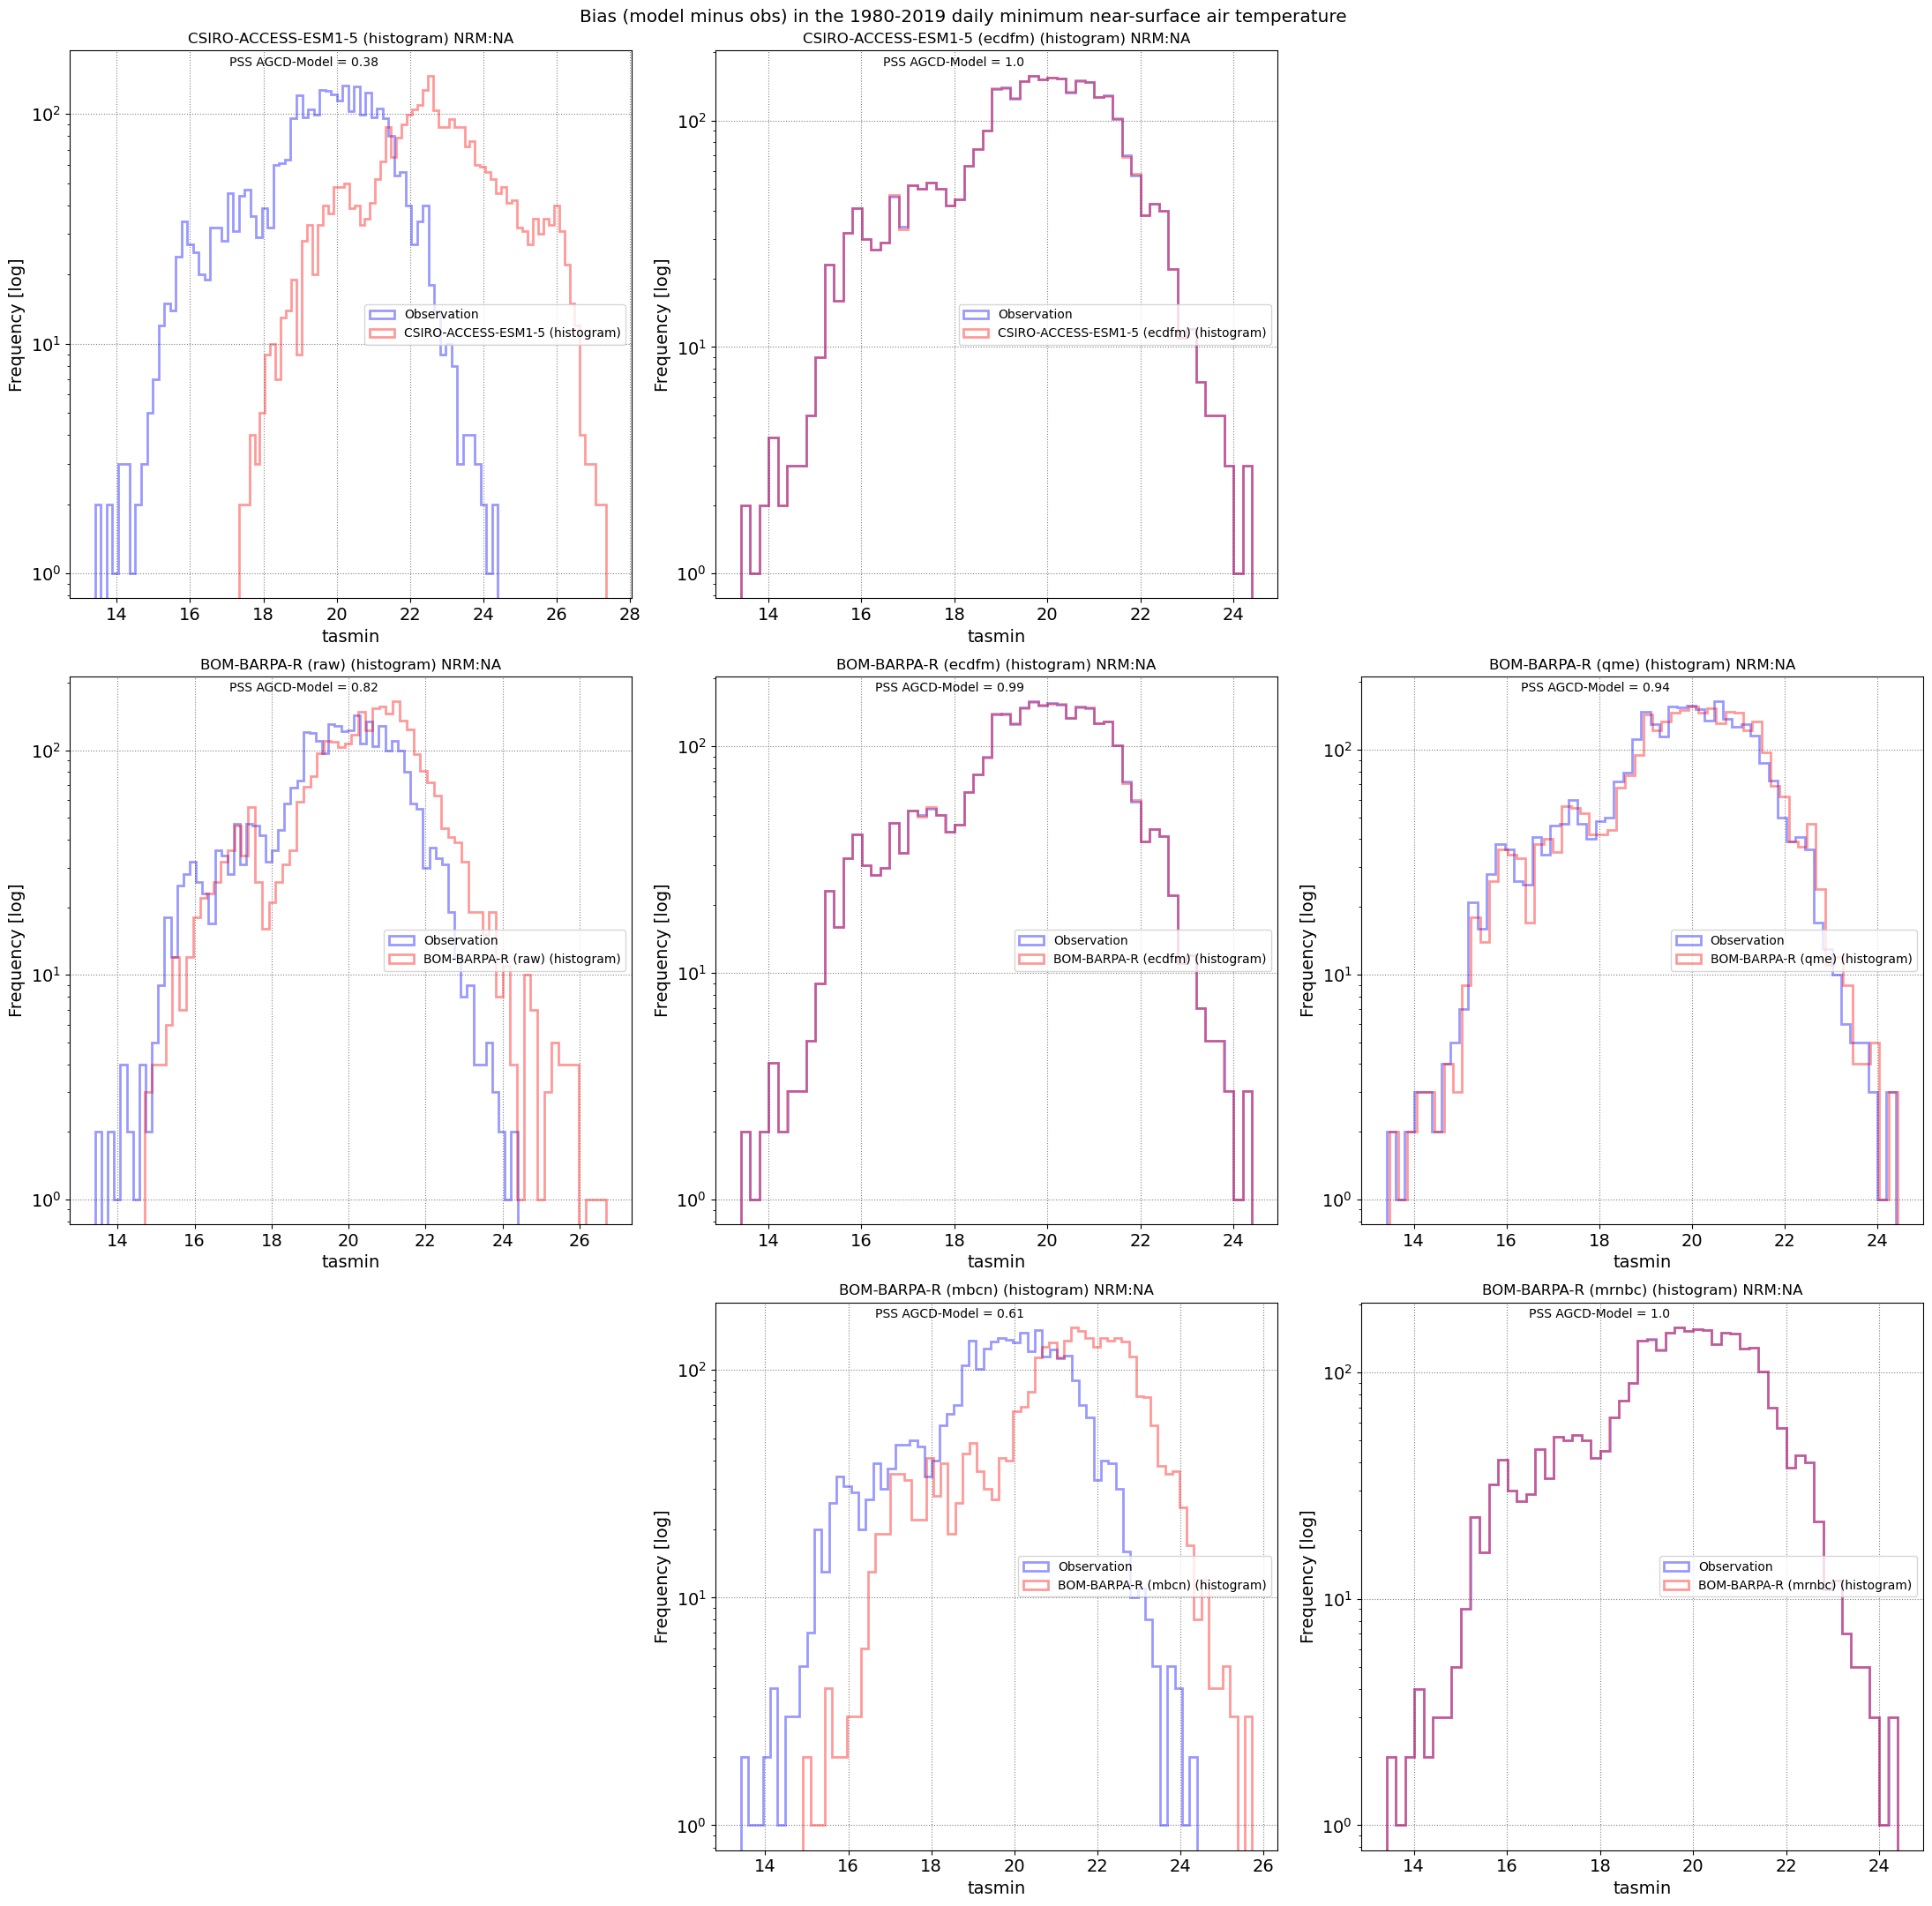

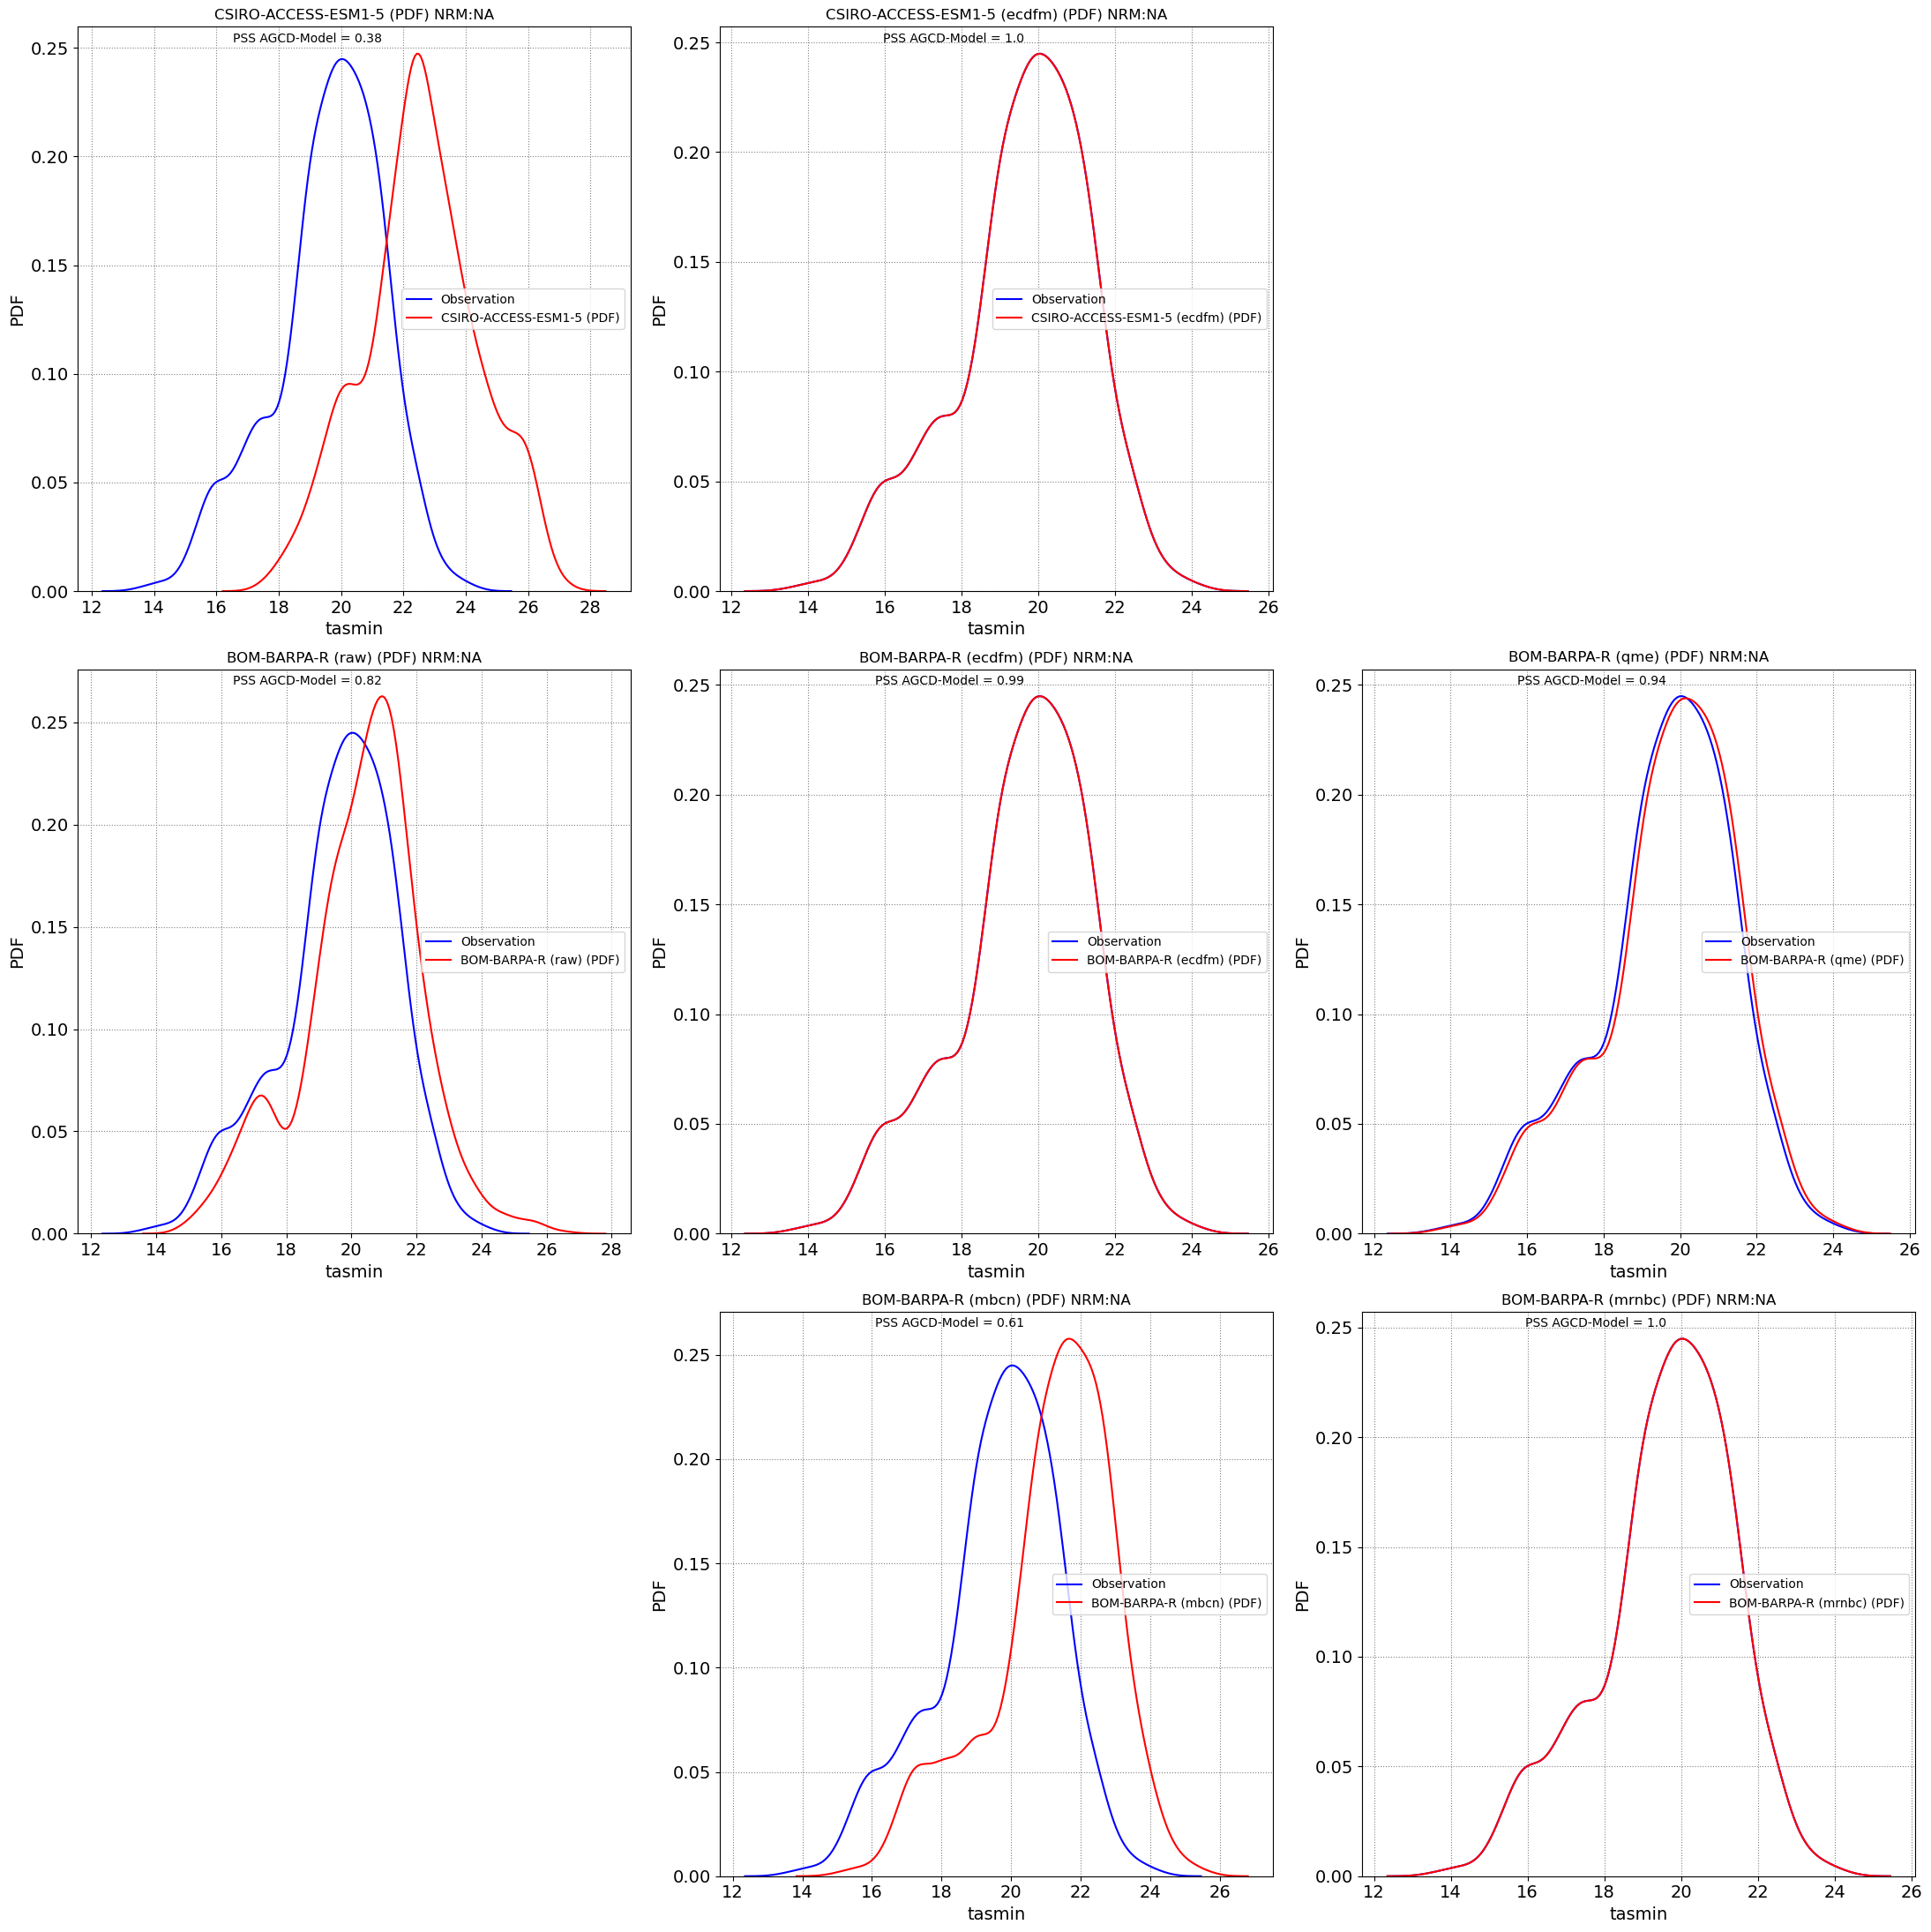

In [9]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=True)

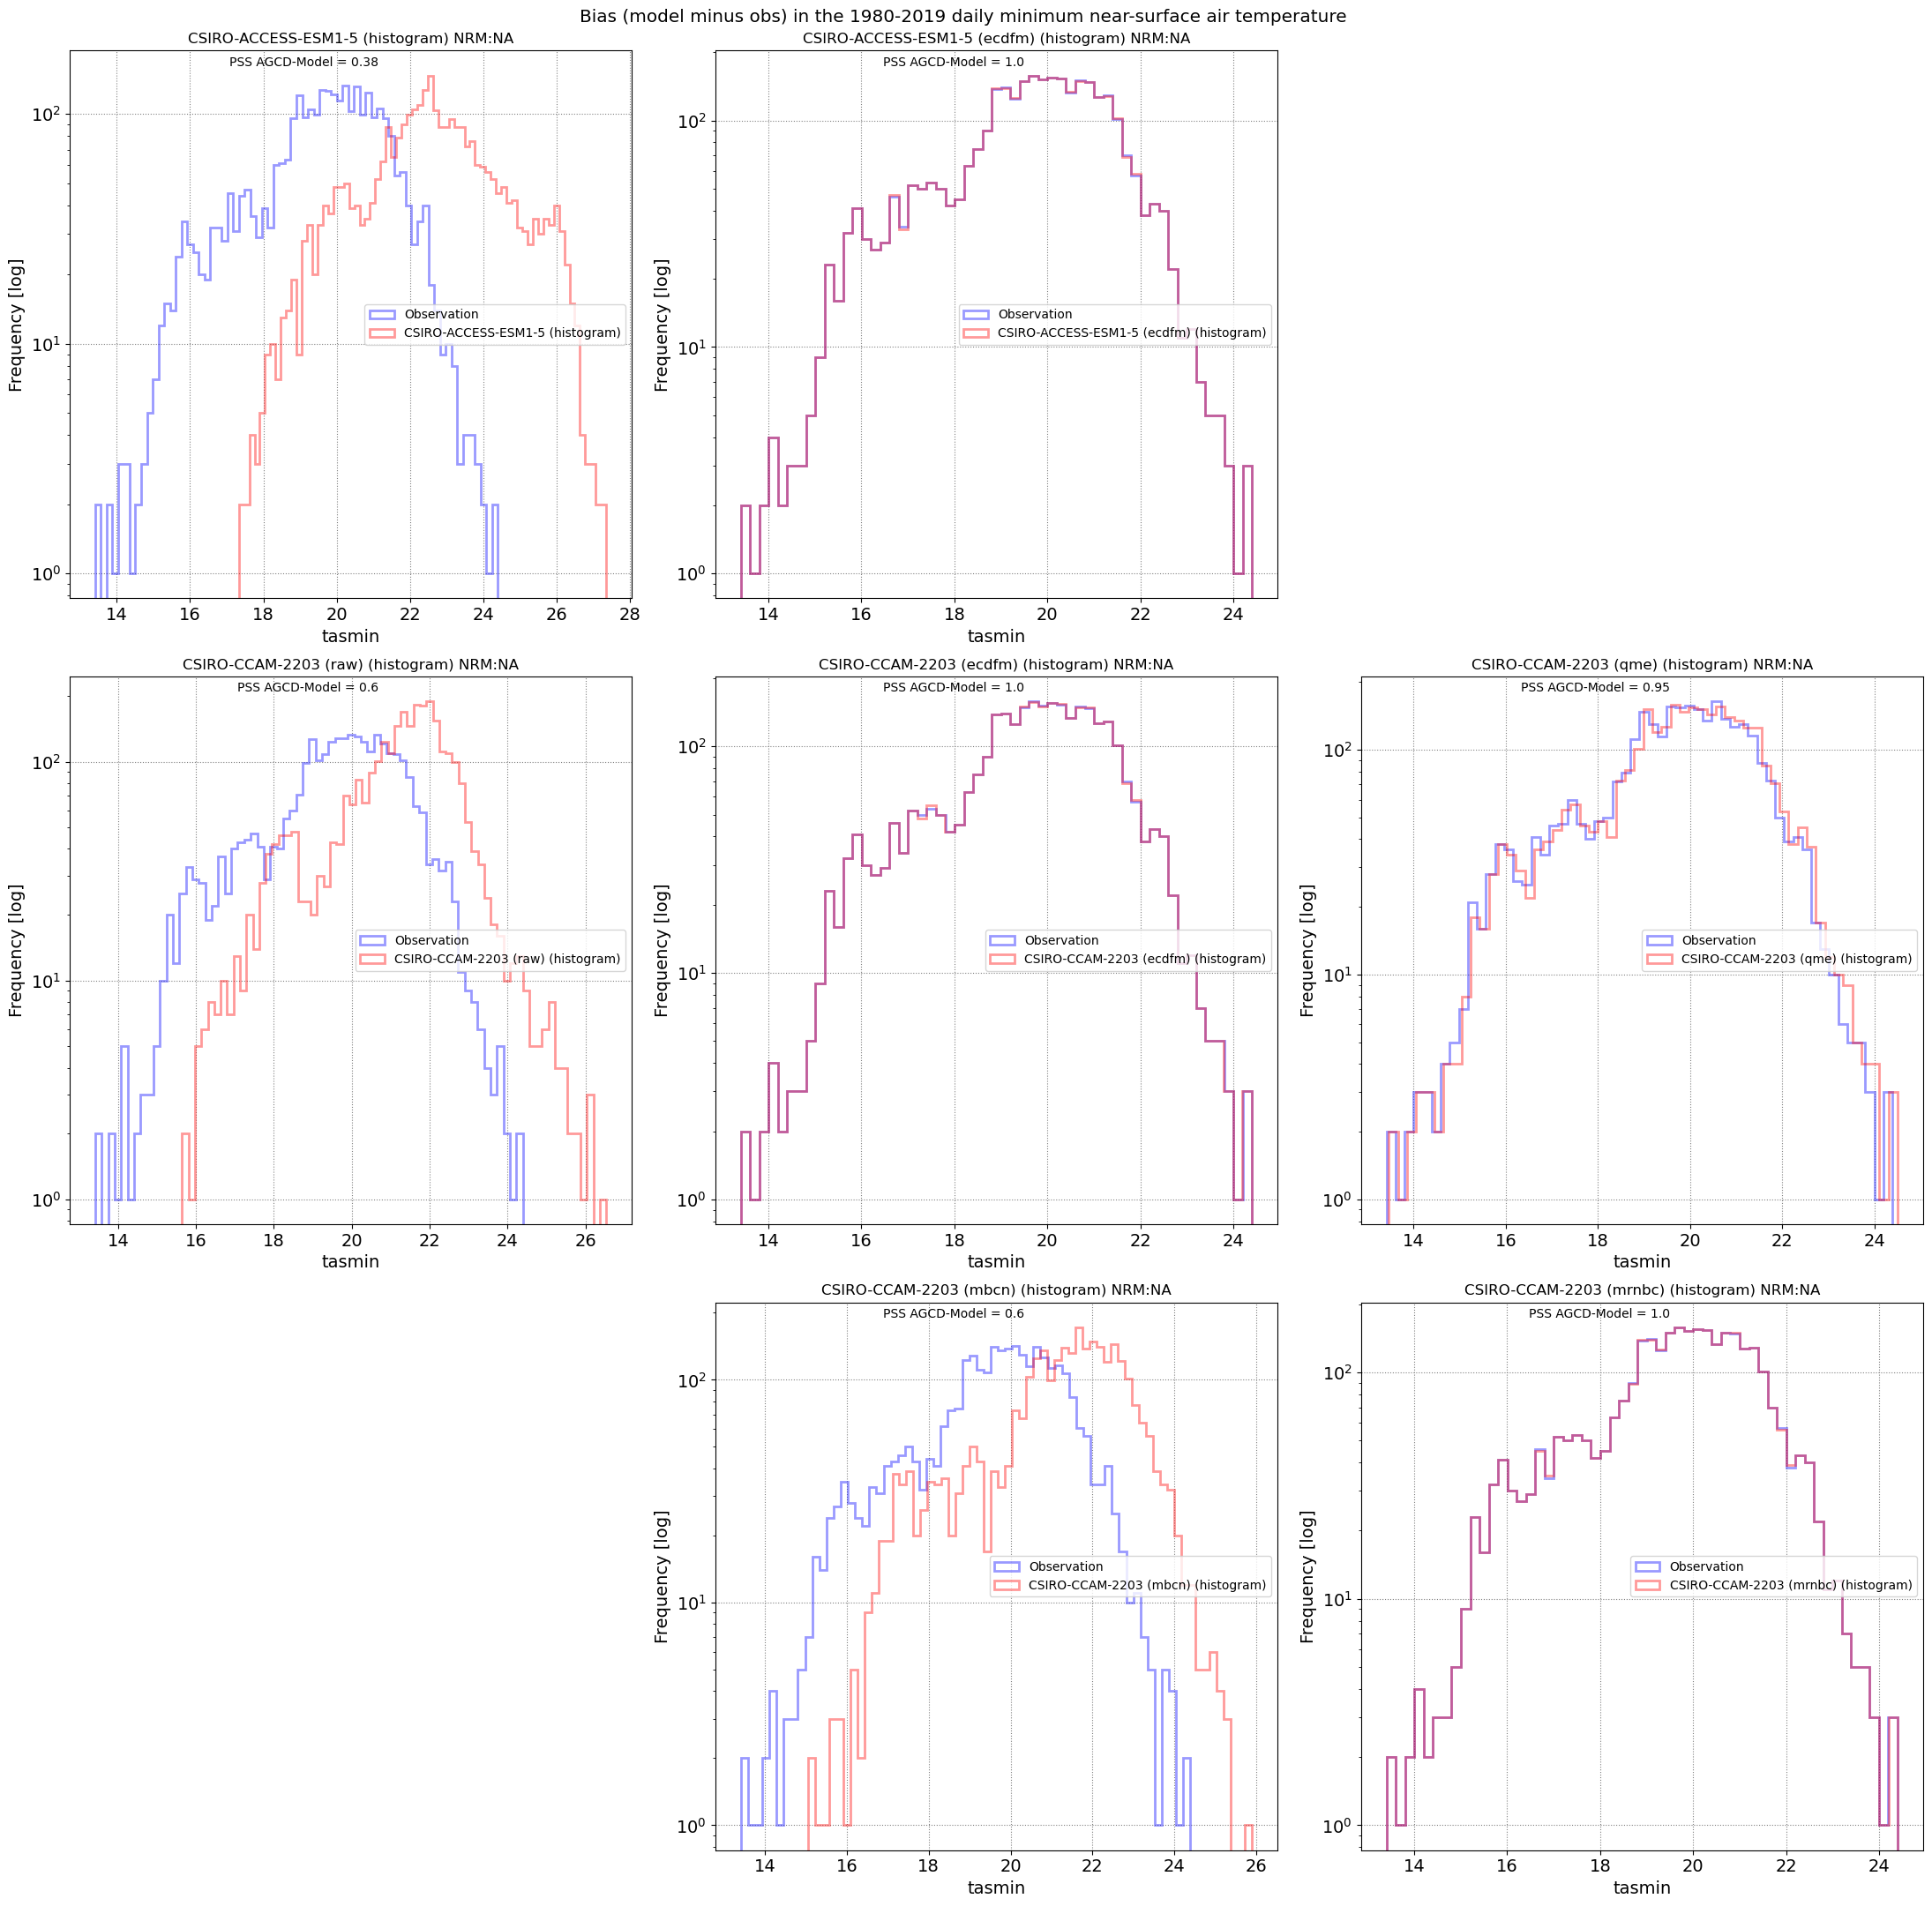

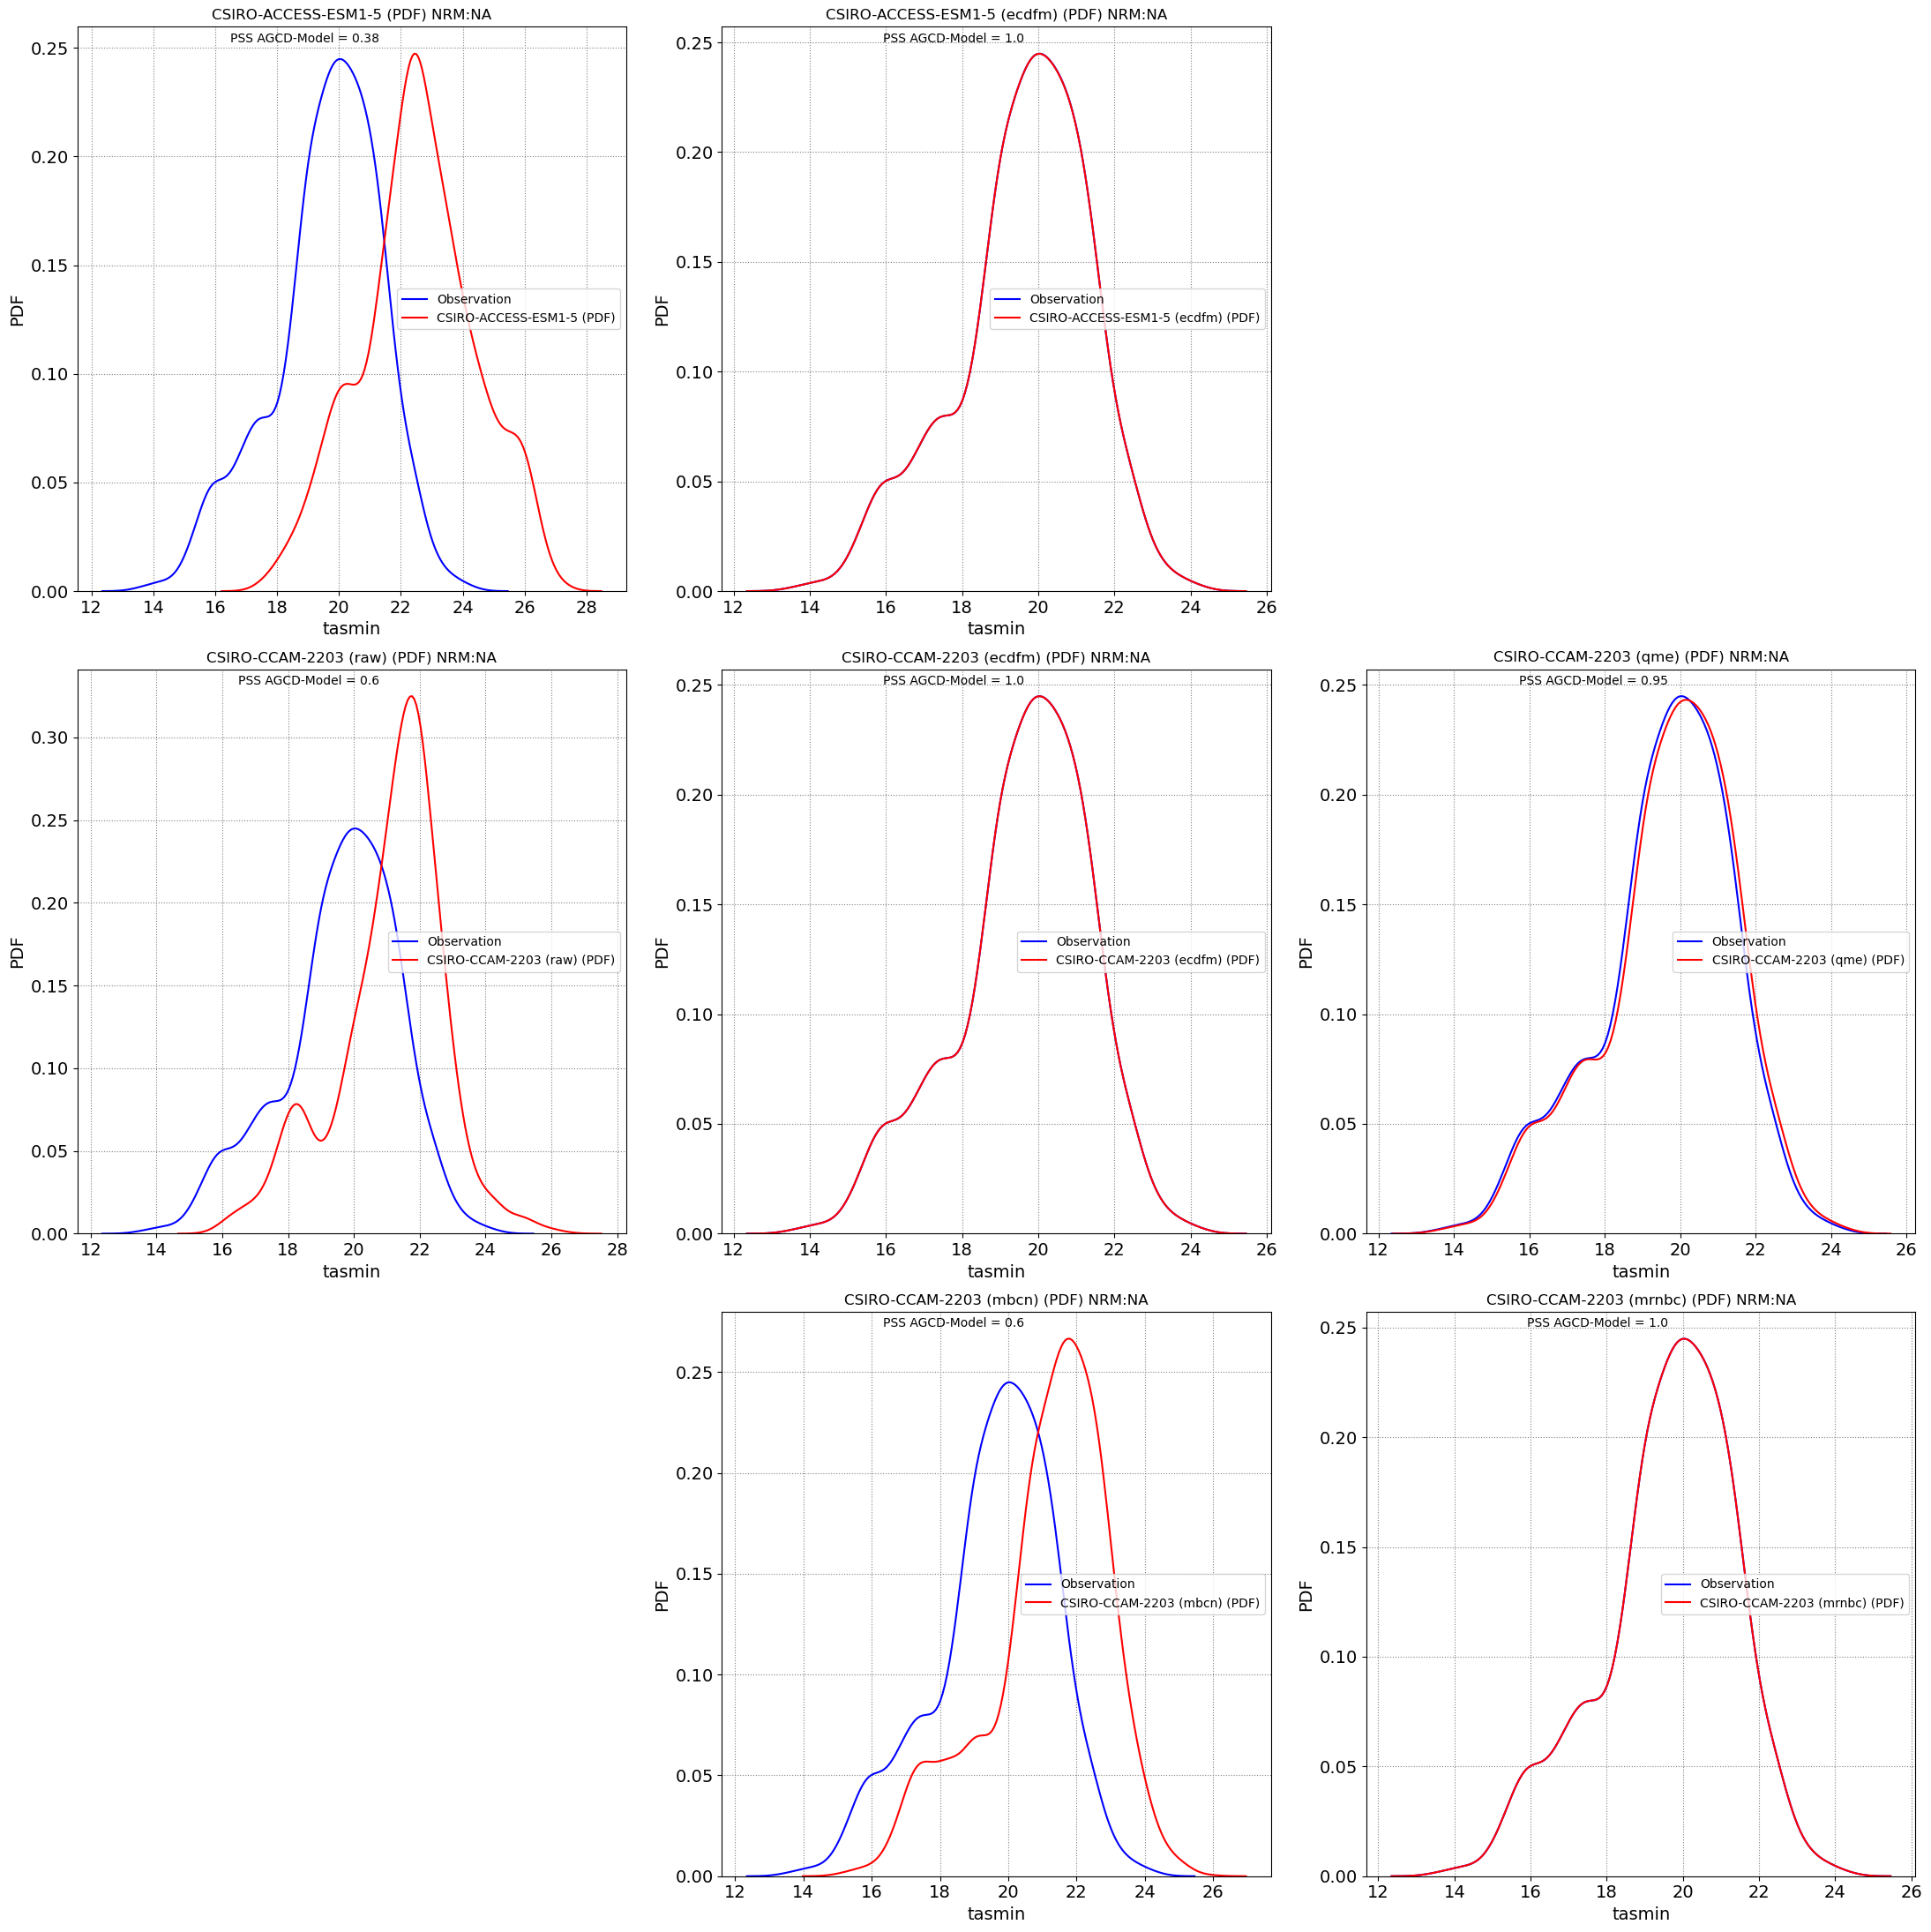

In [10]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

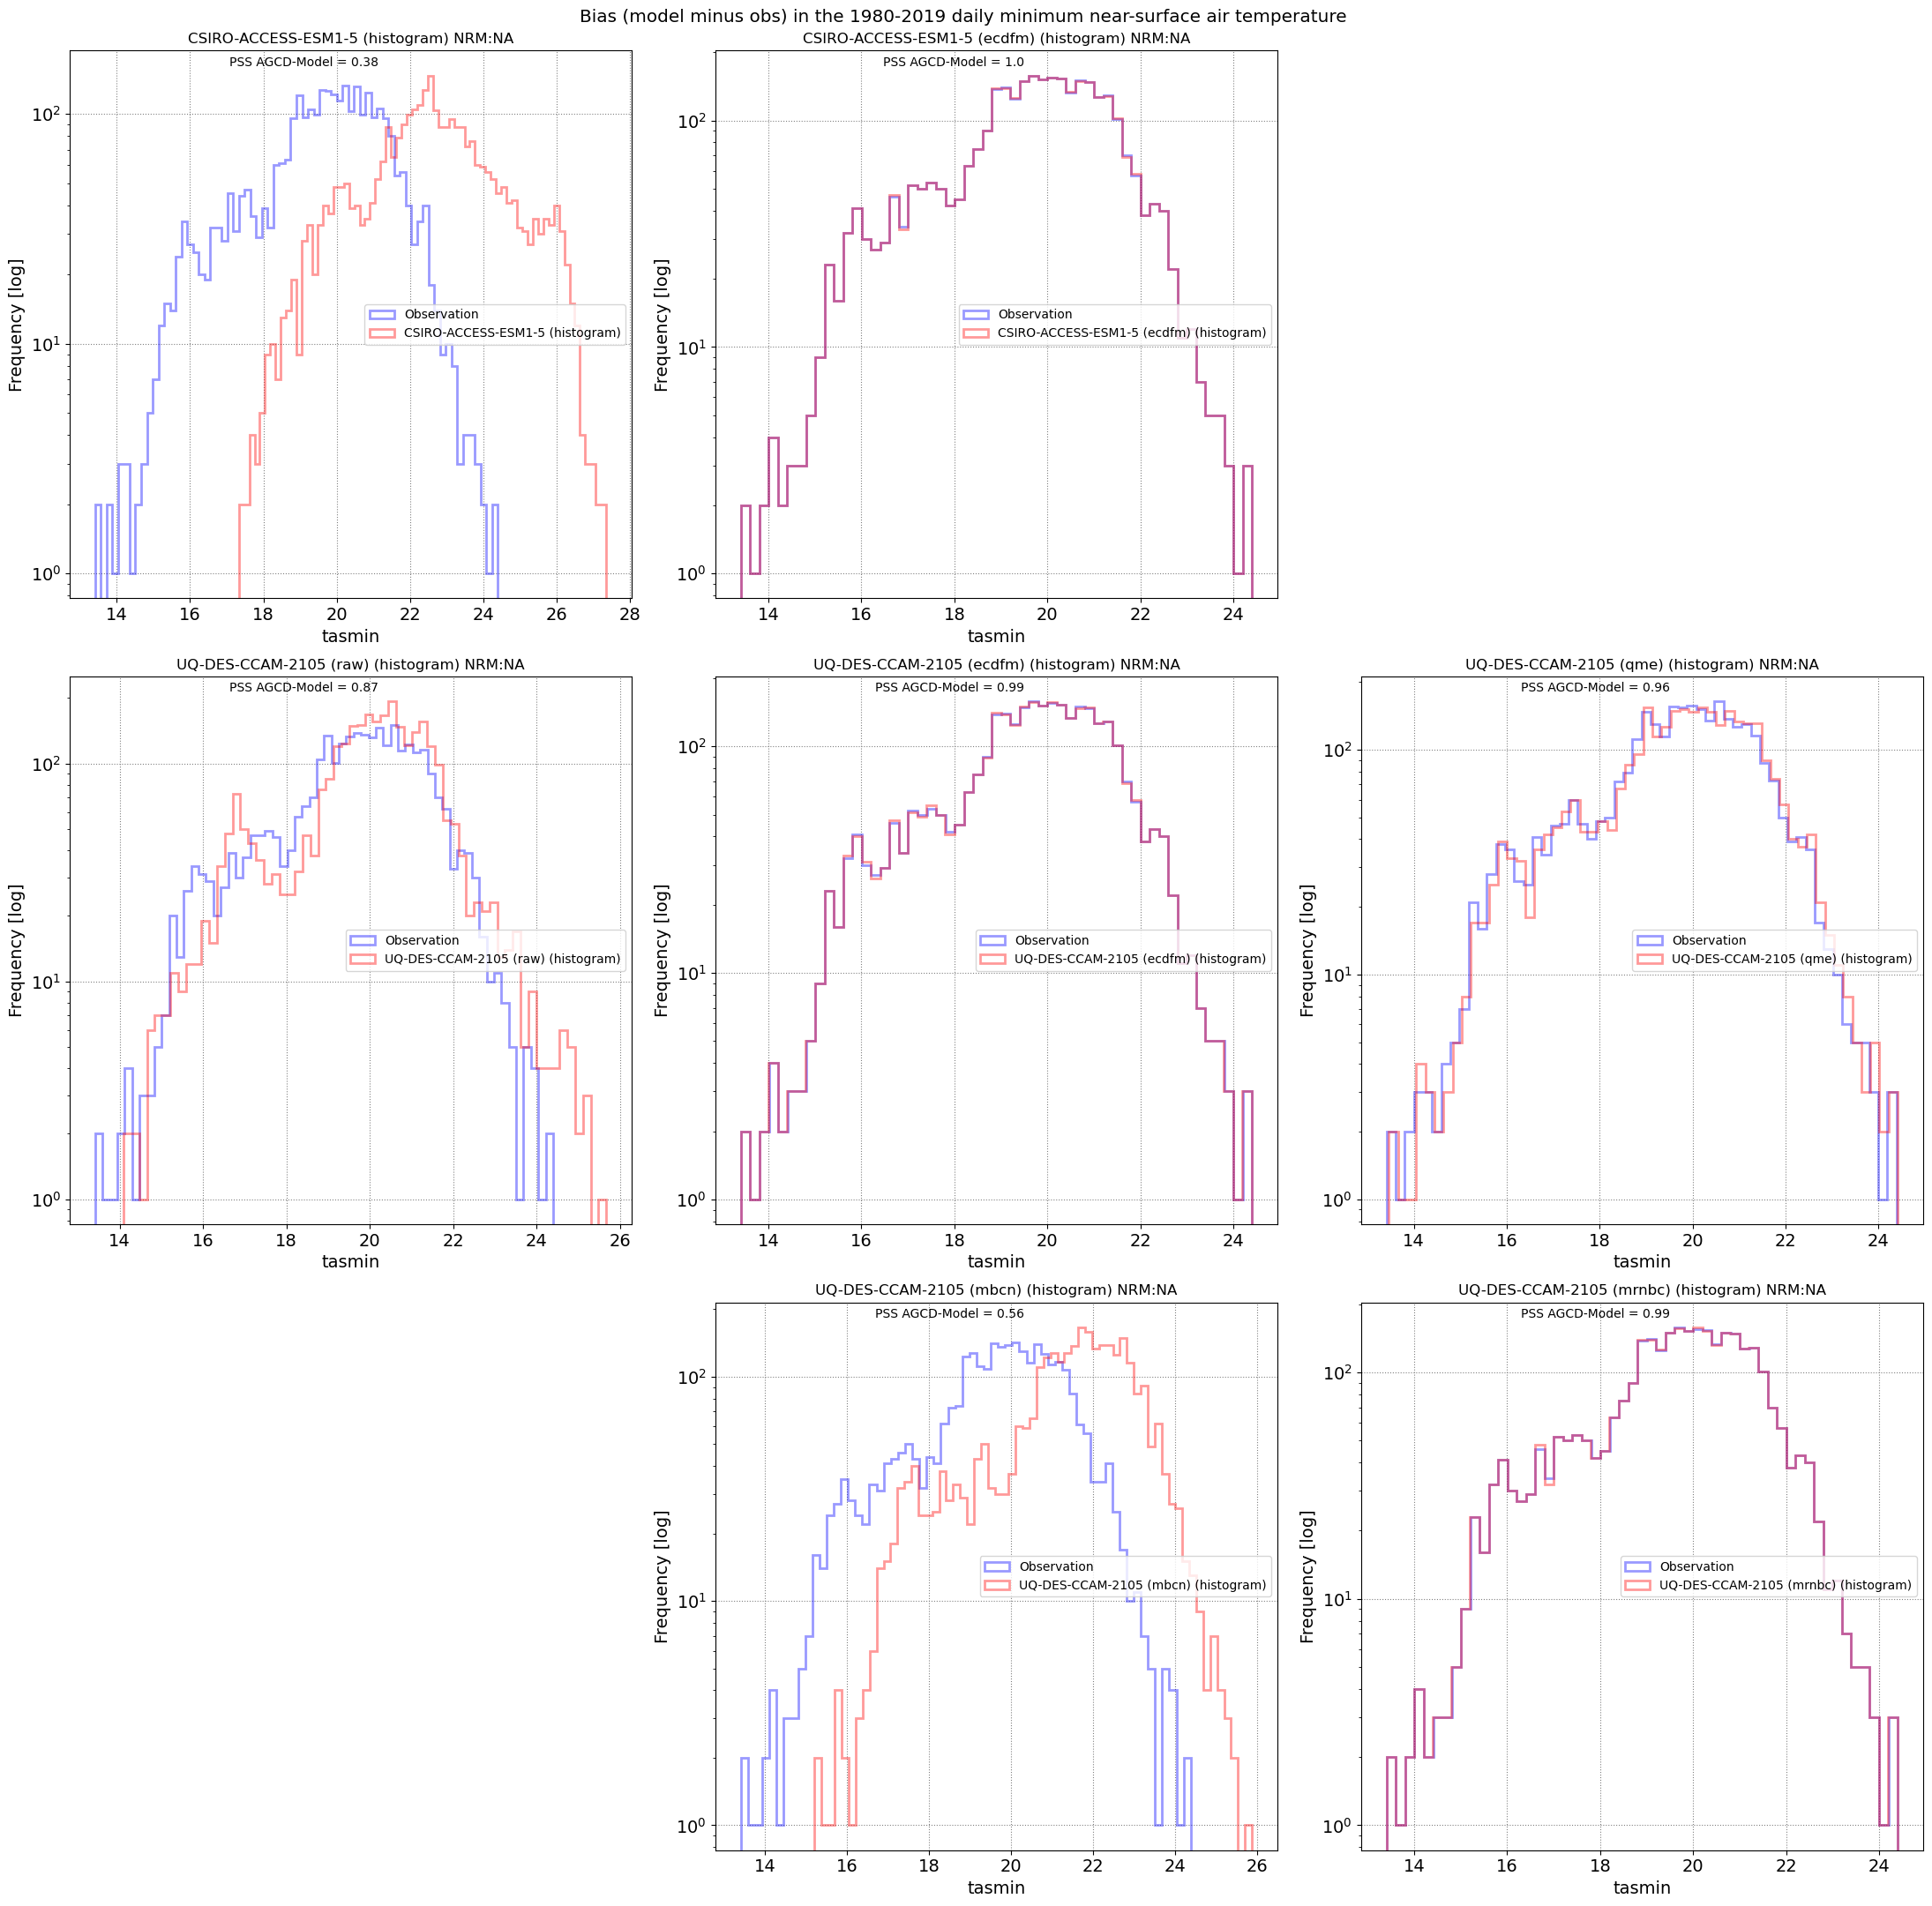

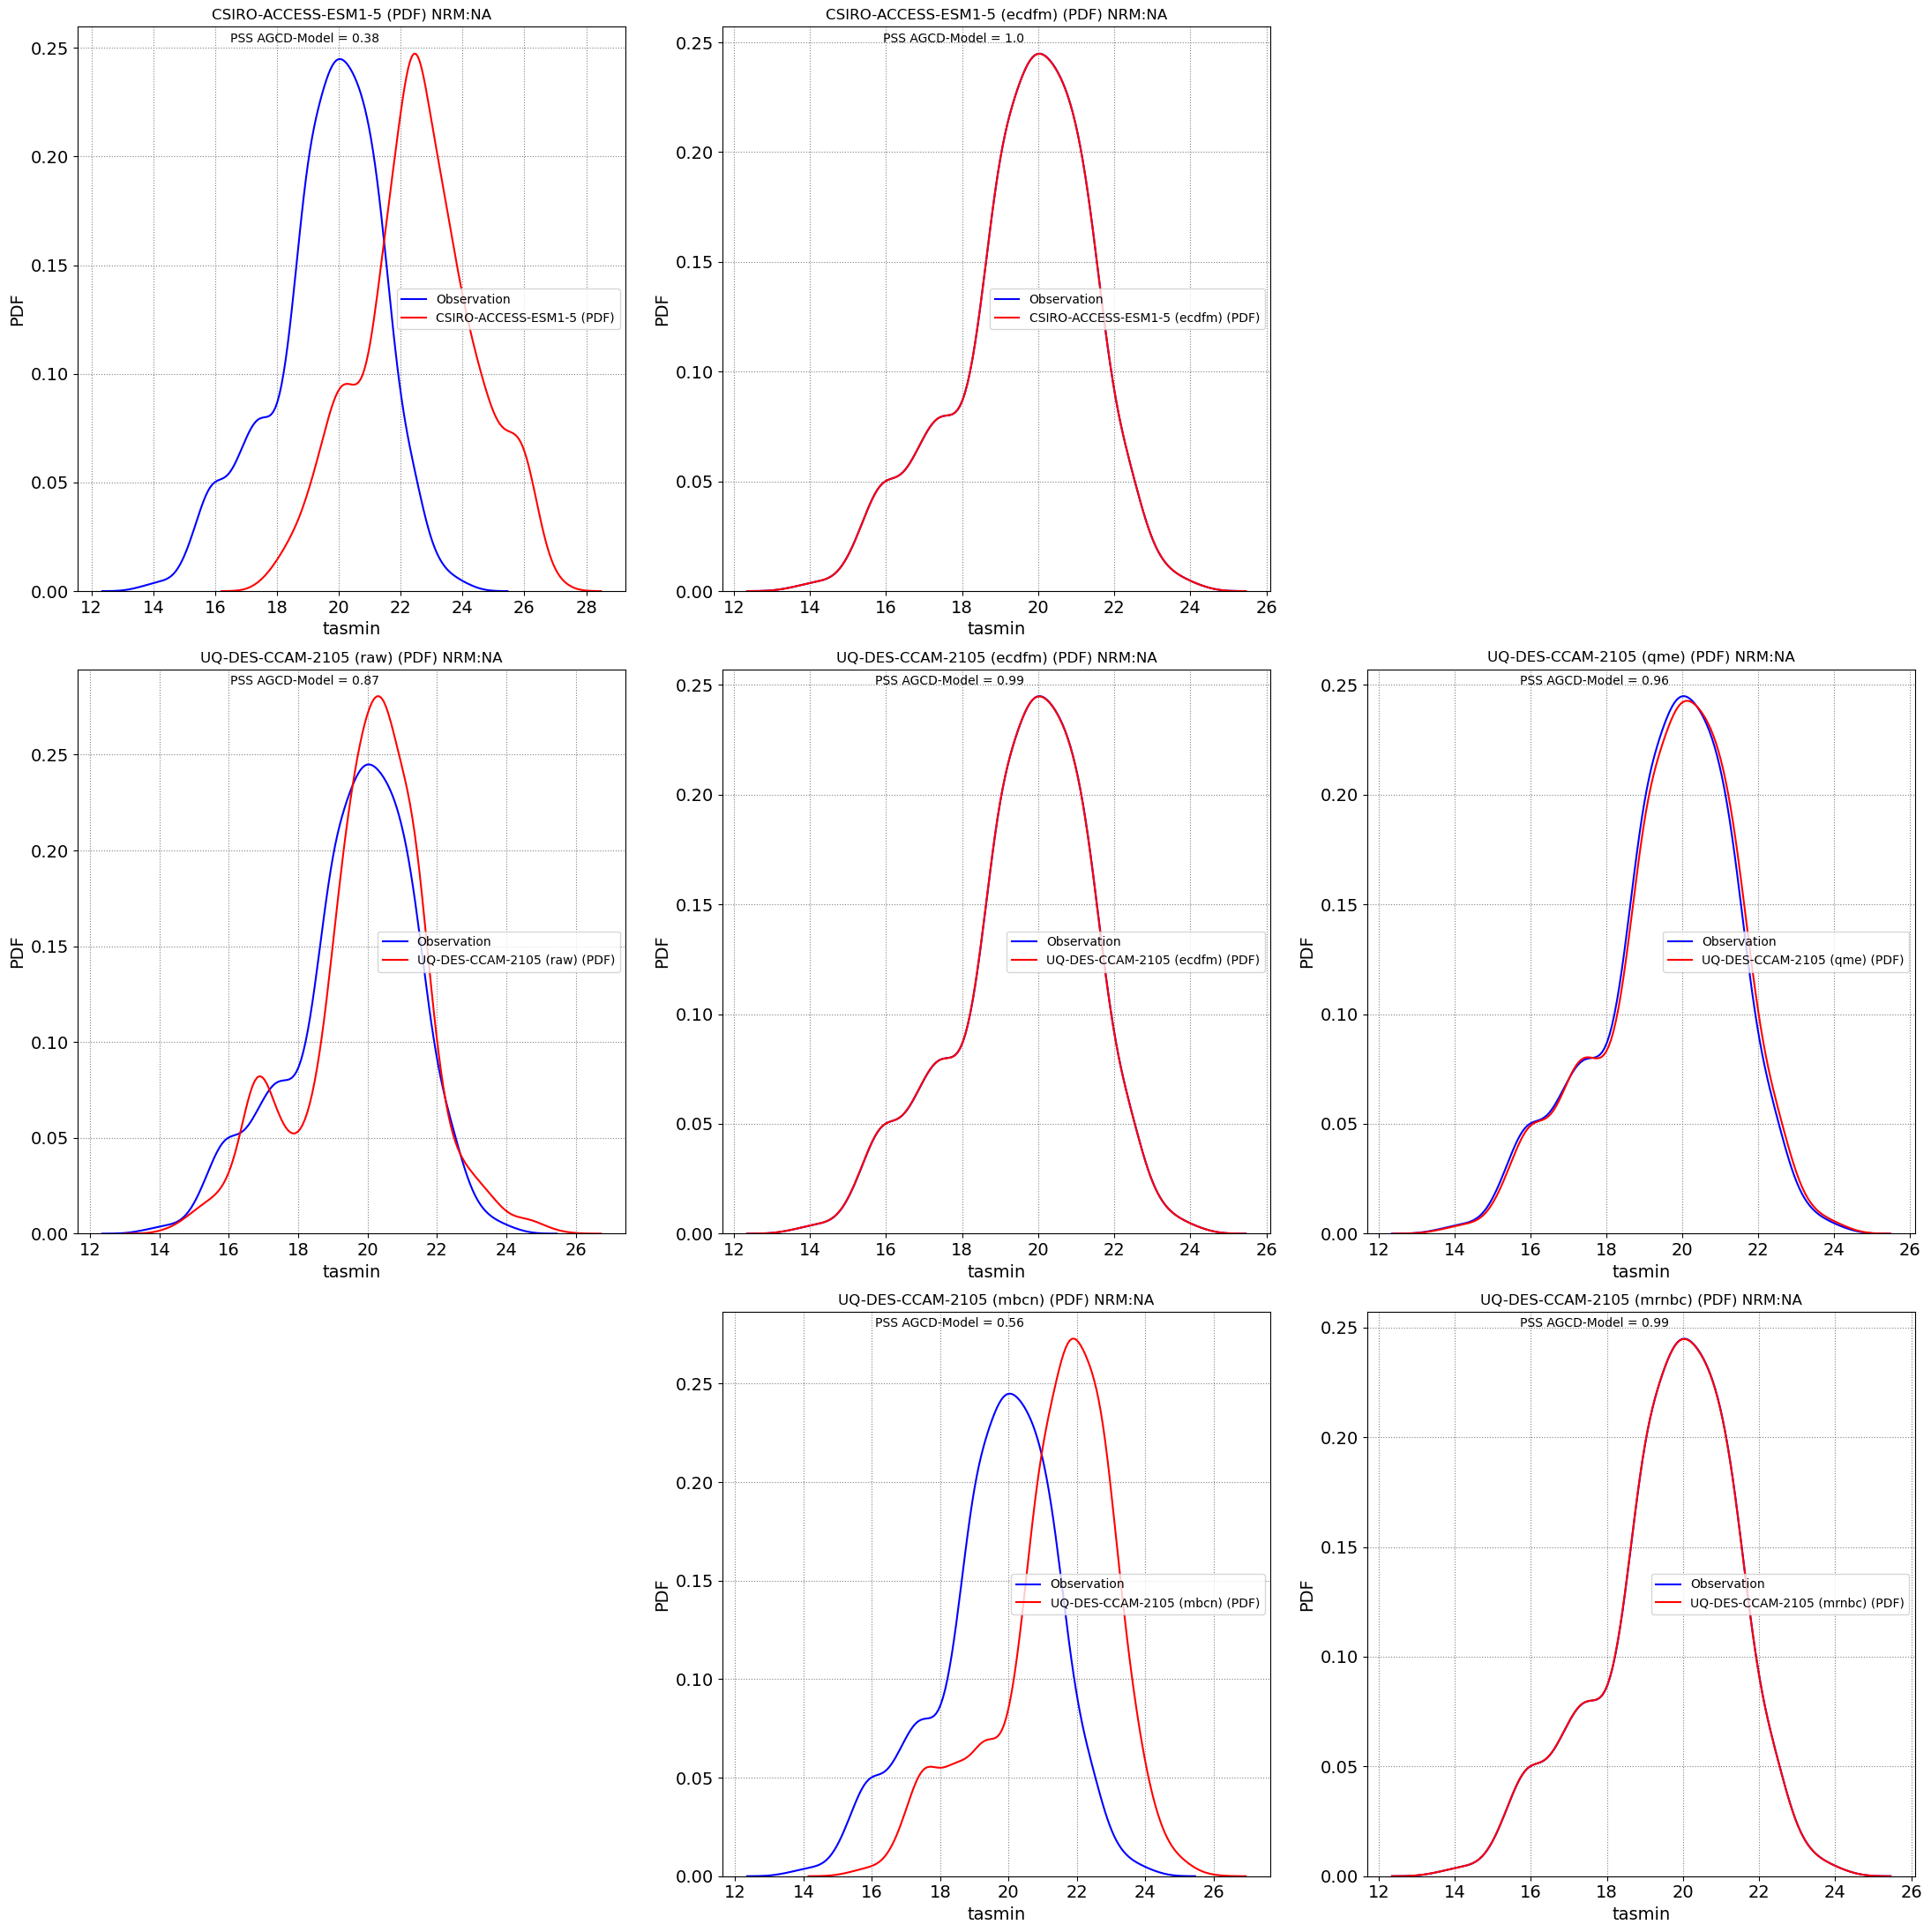

In [11]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

#### CESM2

In [12]:
gcm = 'NCAR-CESM2'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

tasmin_extreme-bias_task-historical_NCAR-CESM2_BOM-BARPA-R_NA.png


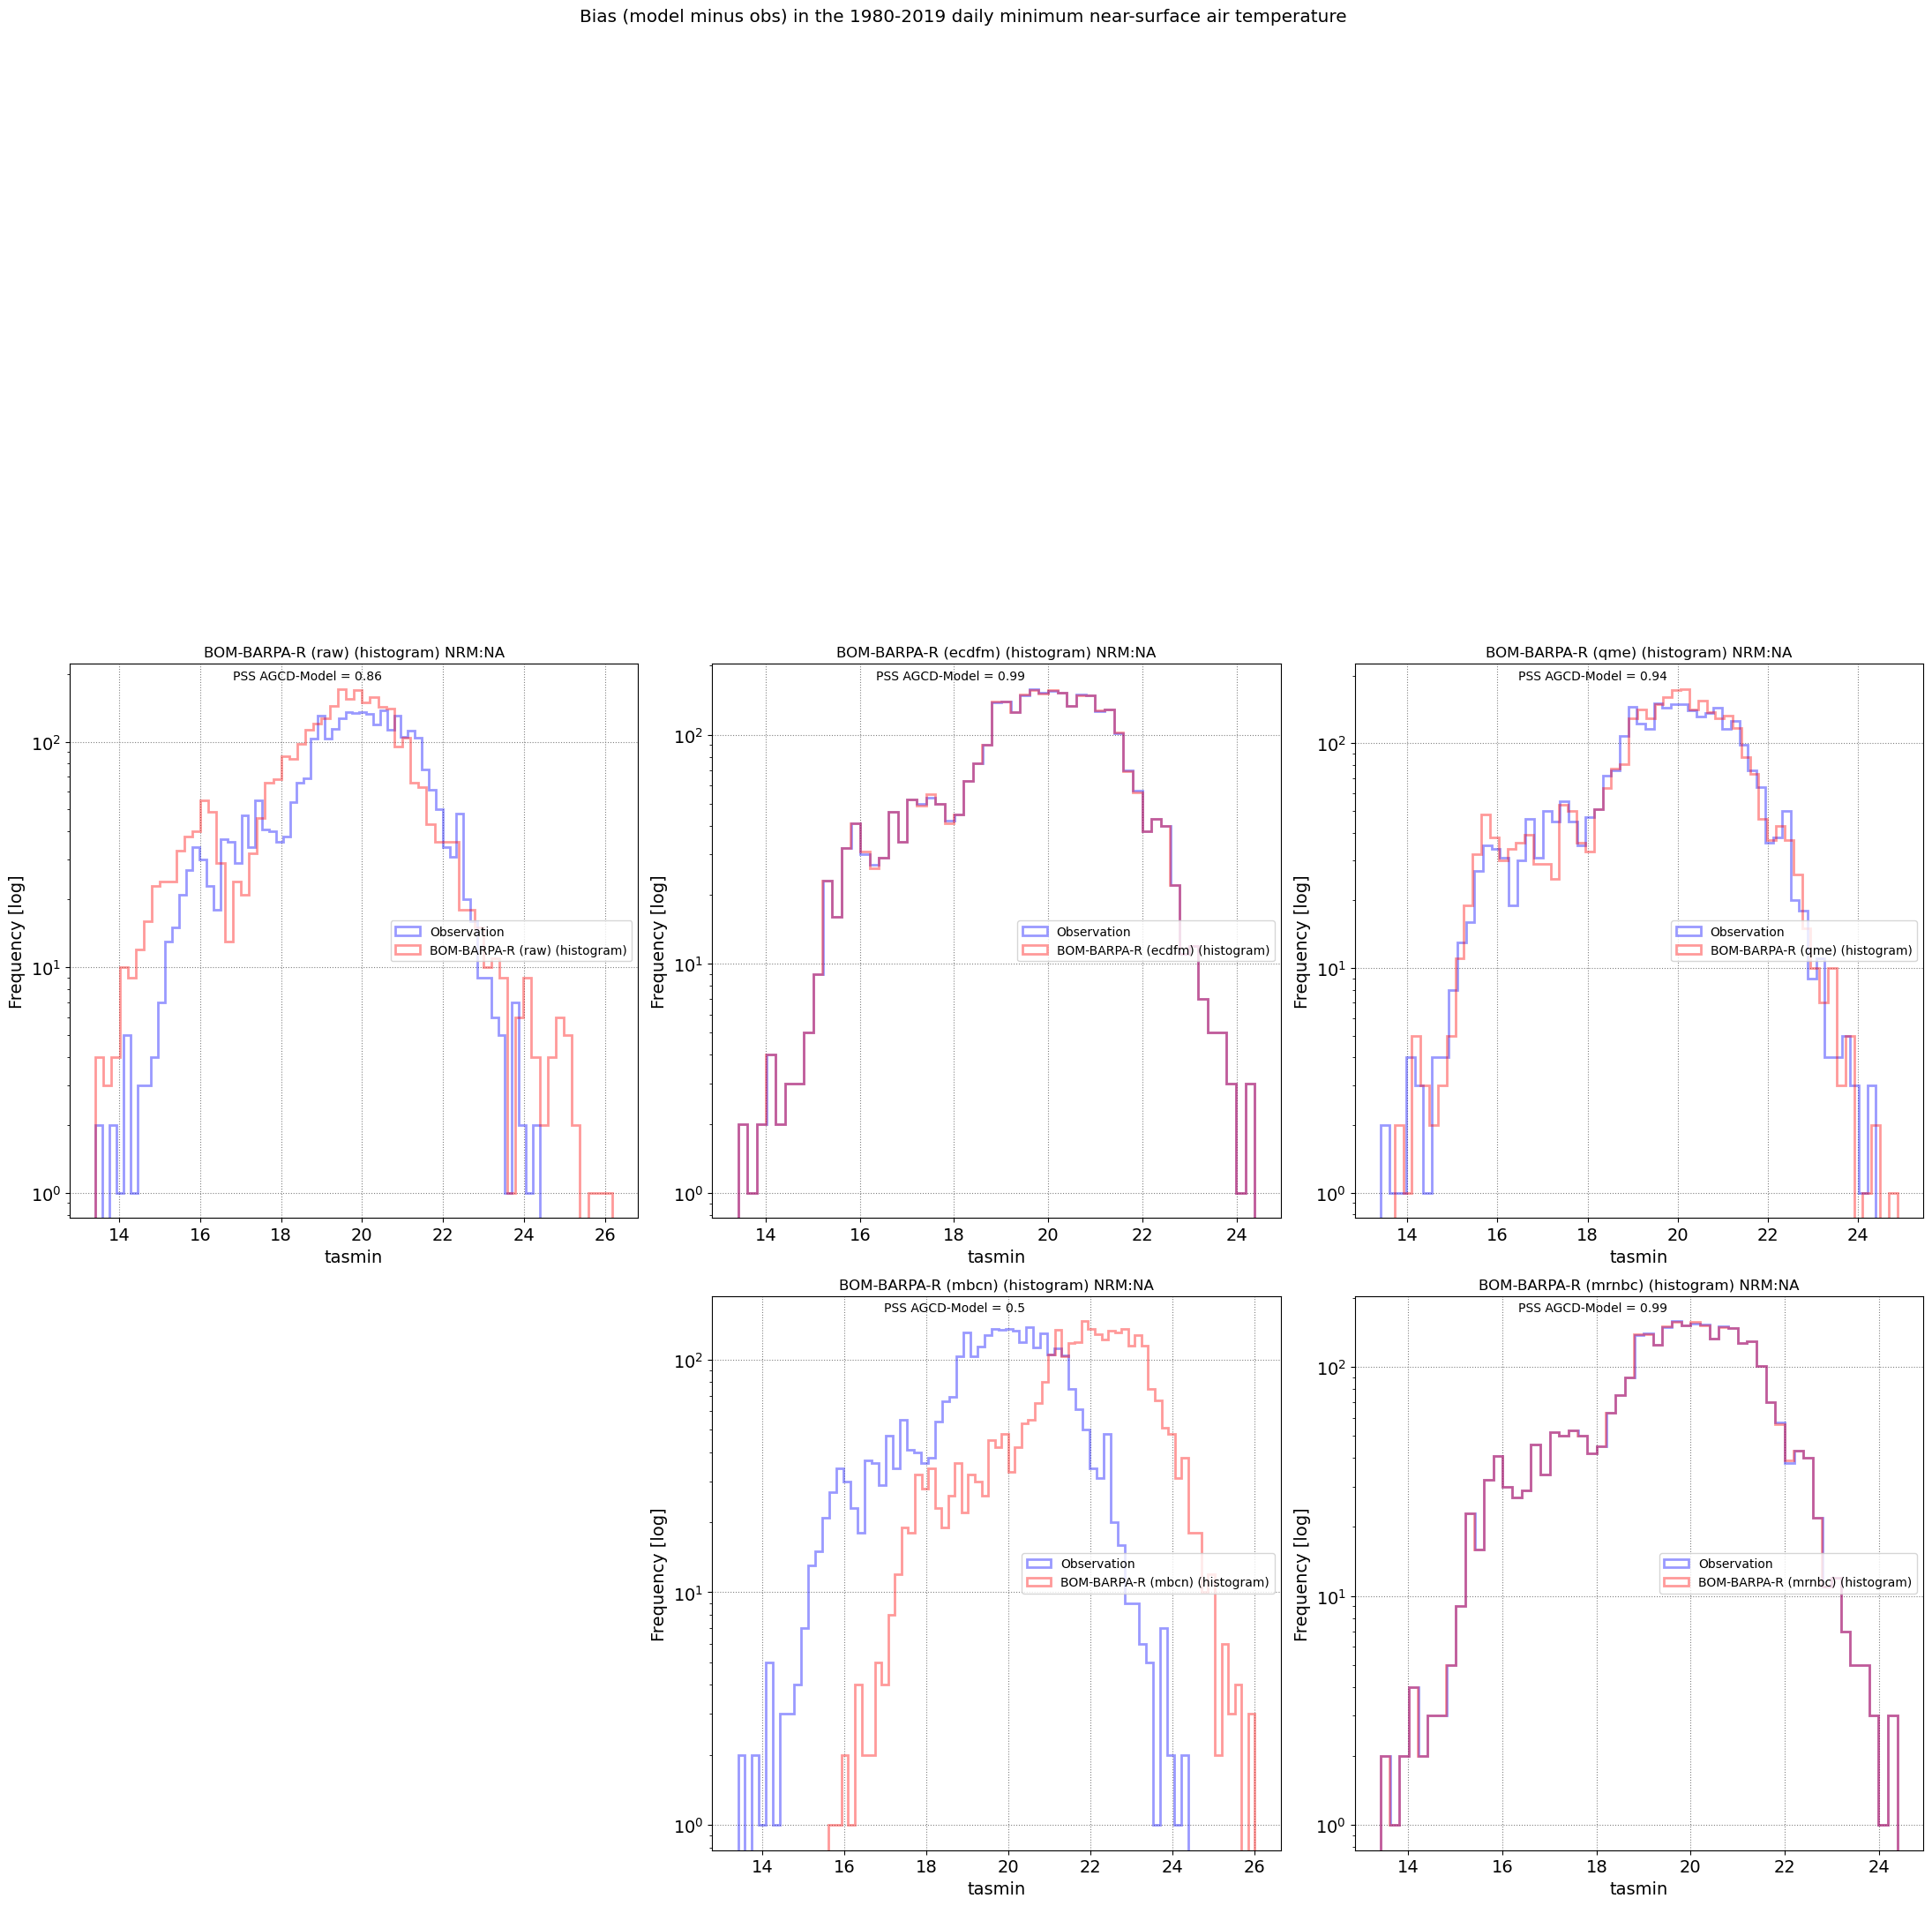

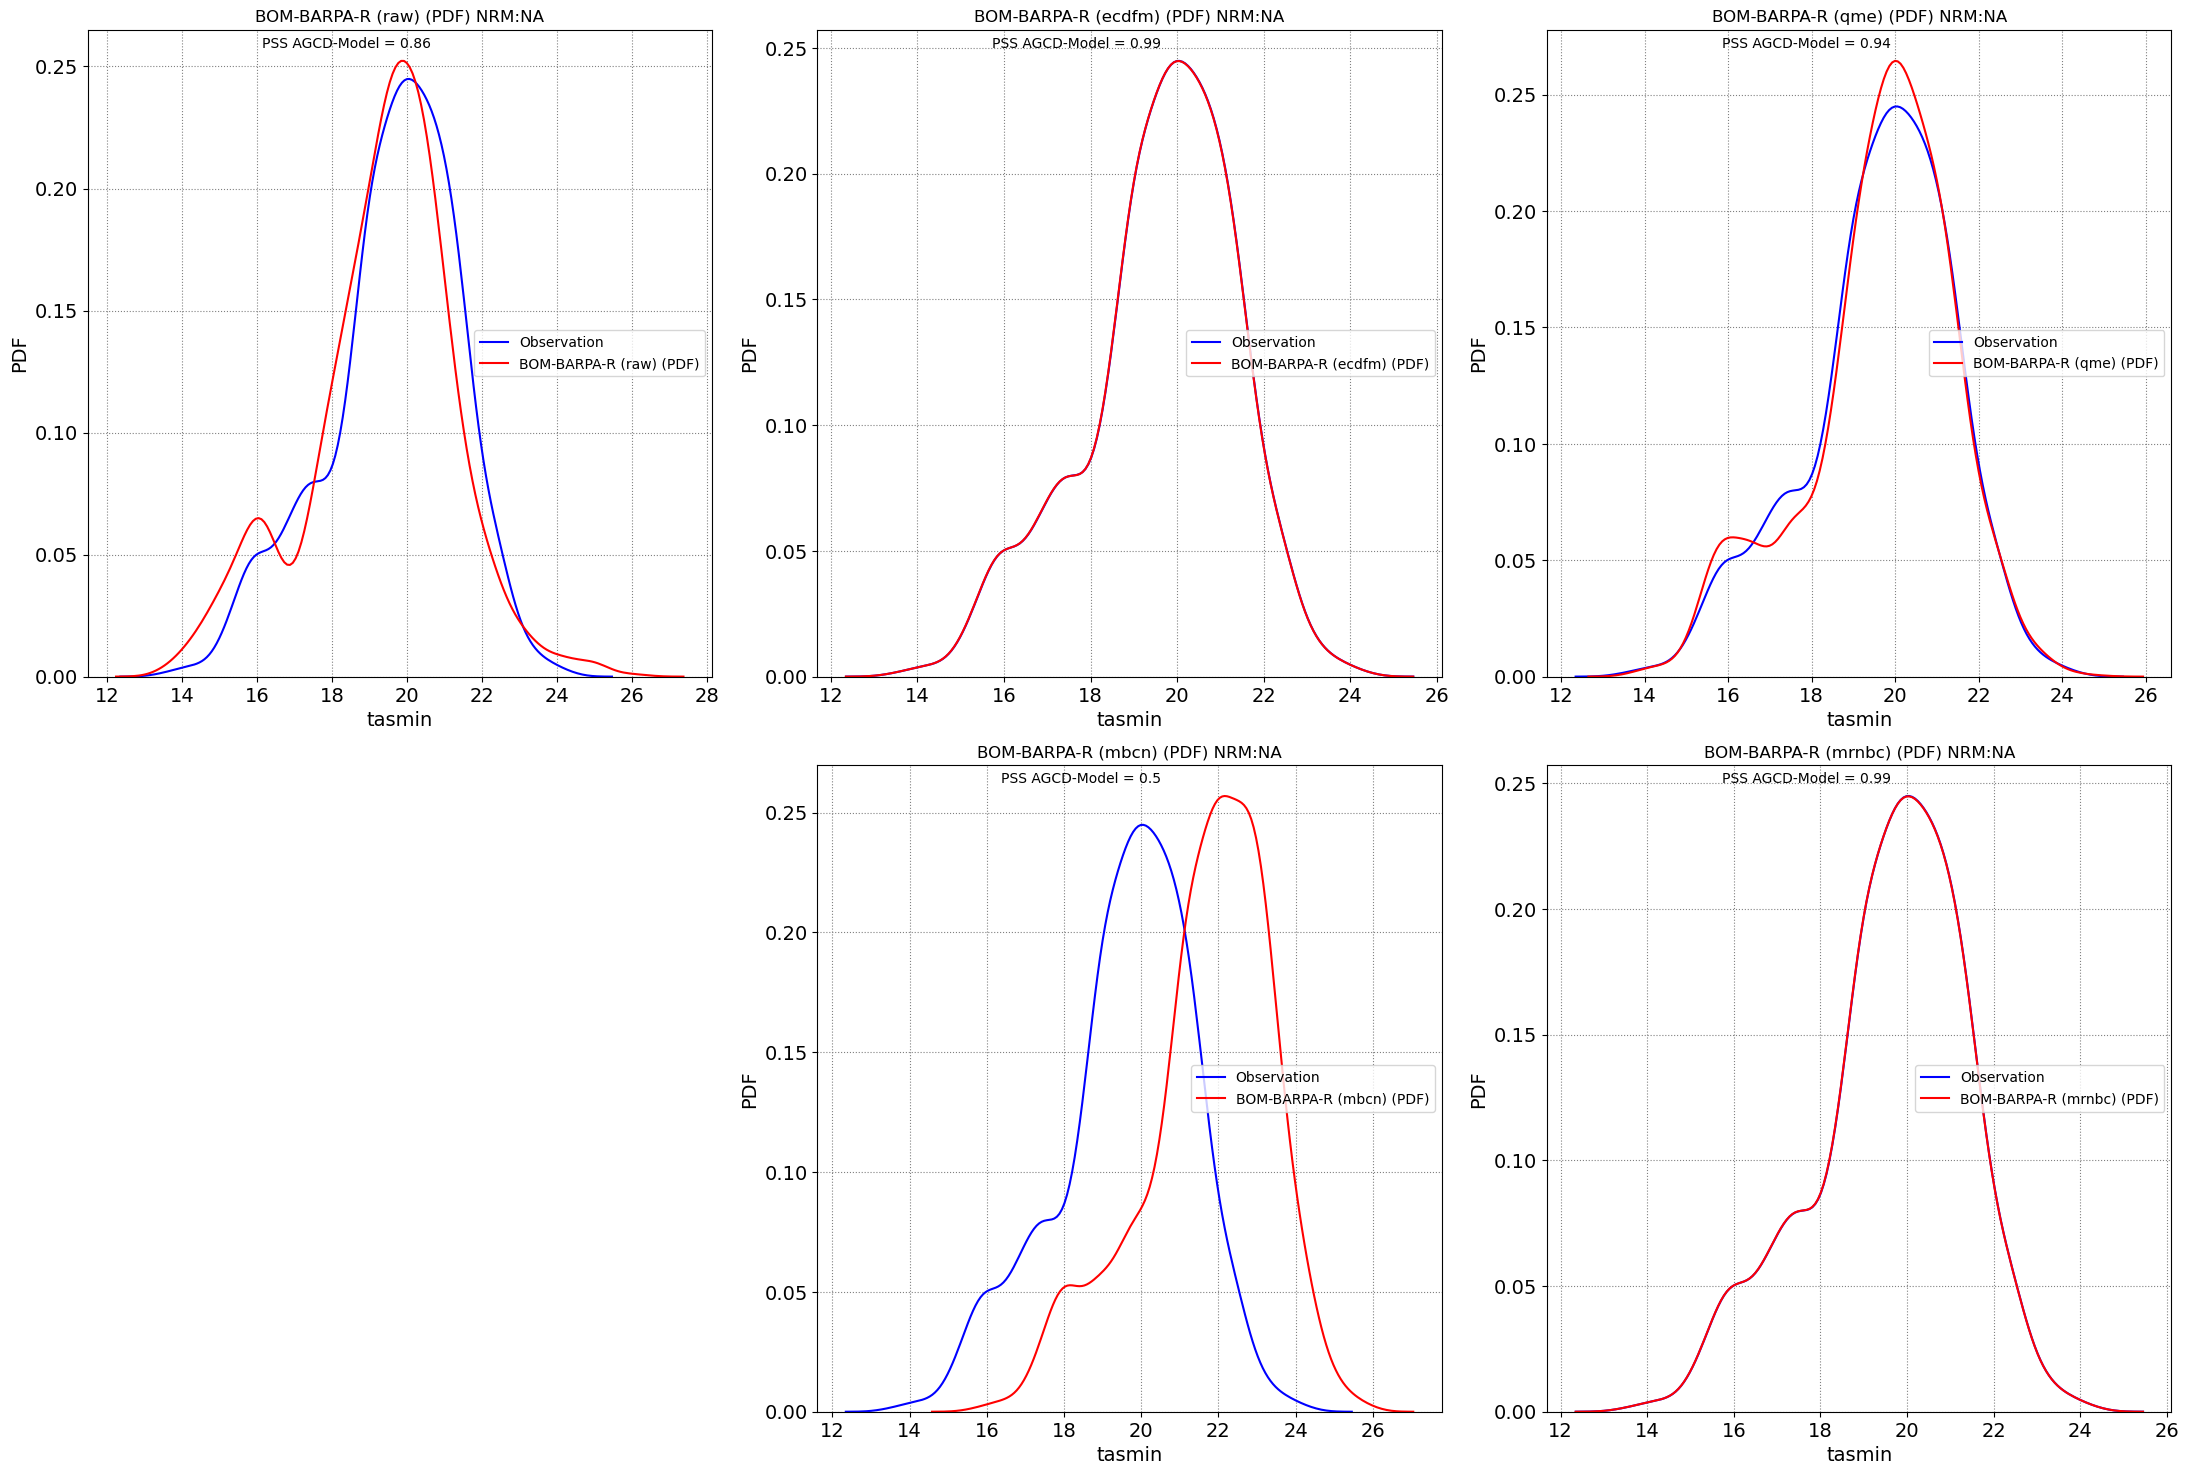

In [13]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=True)

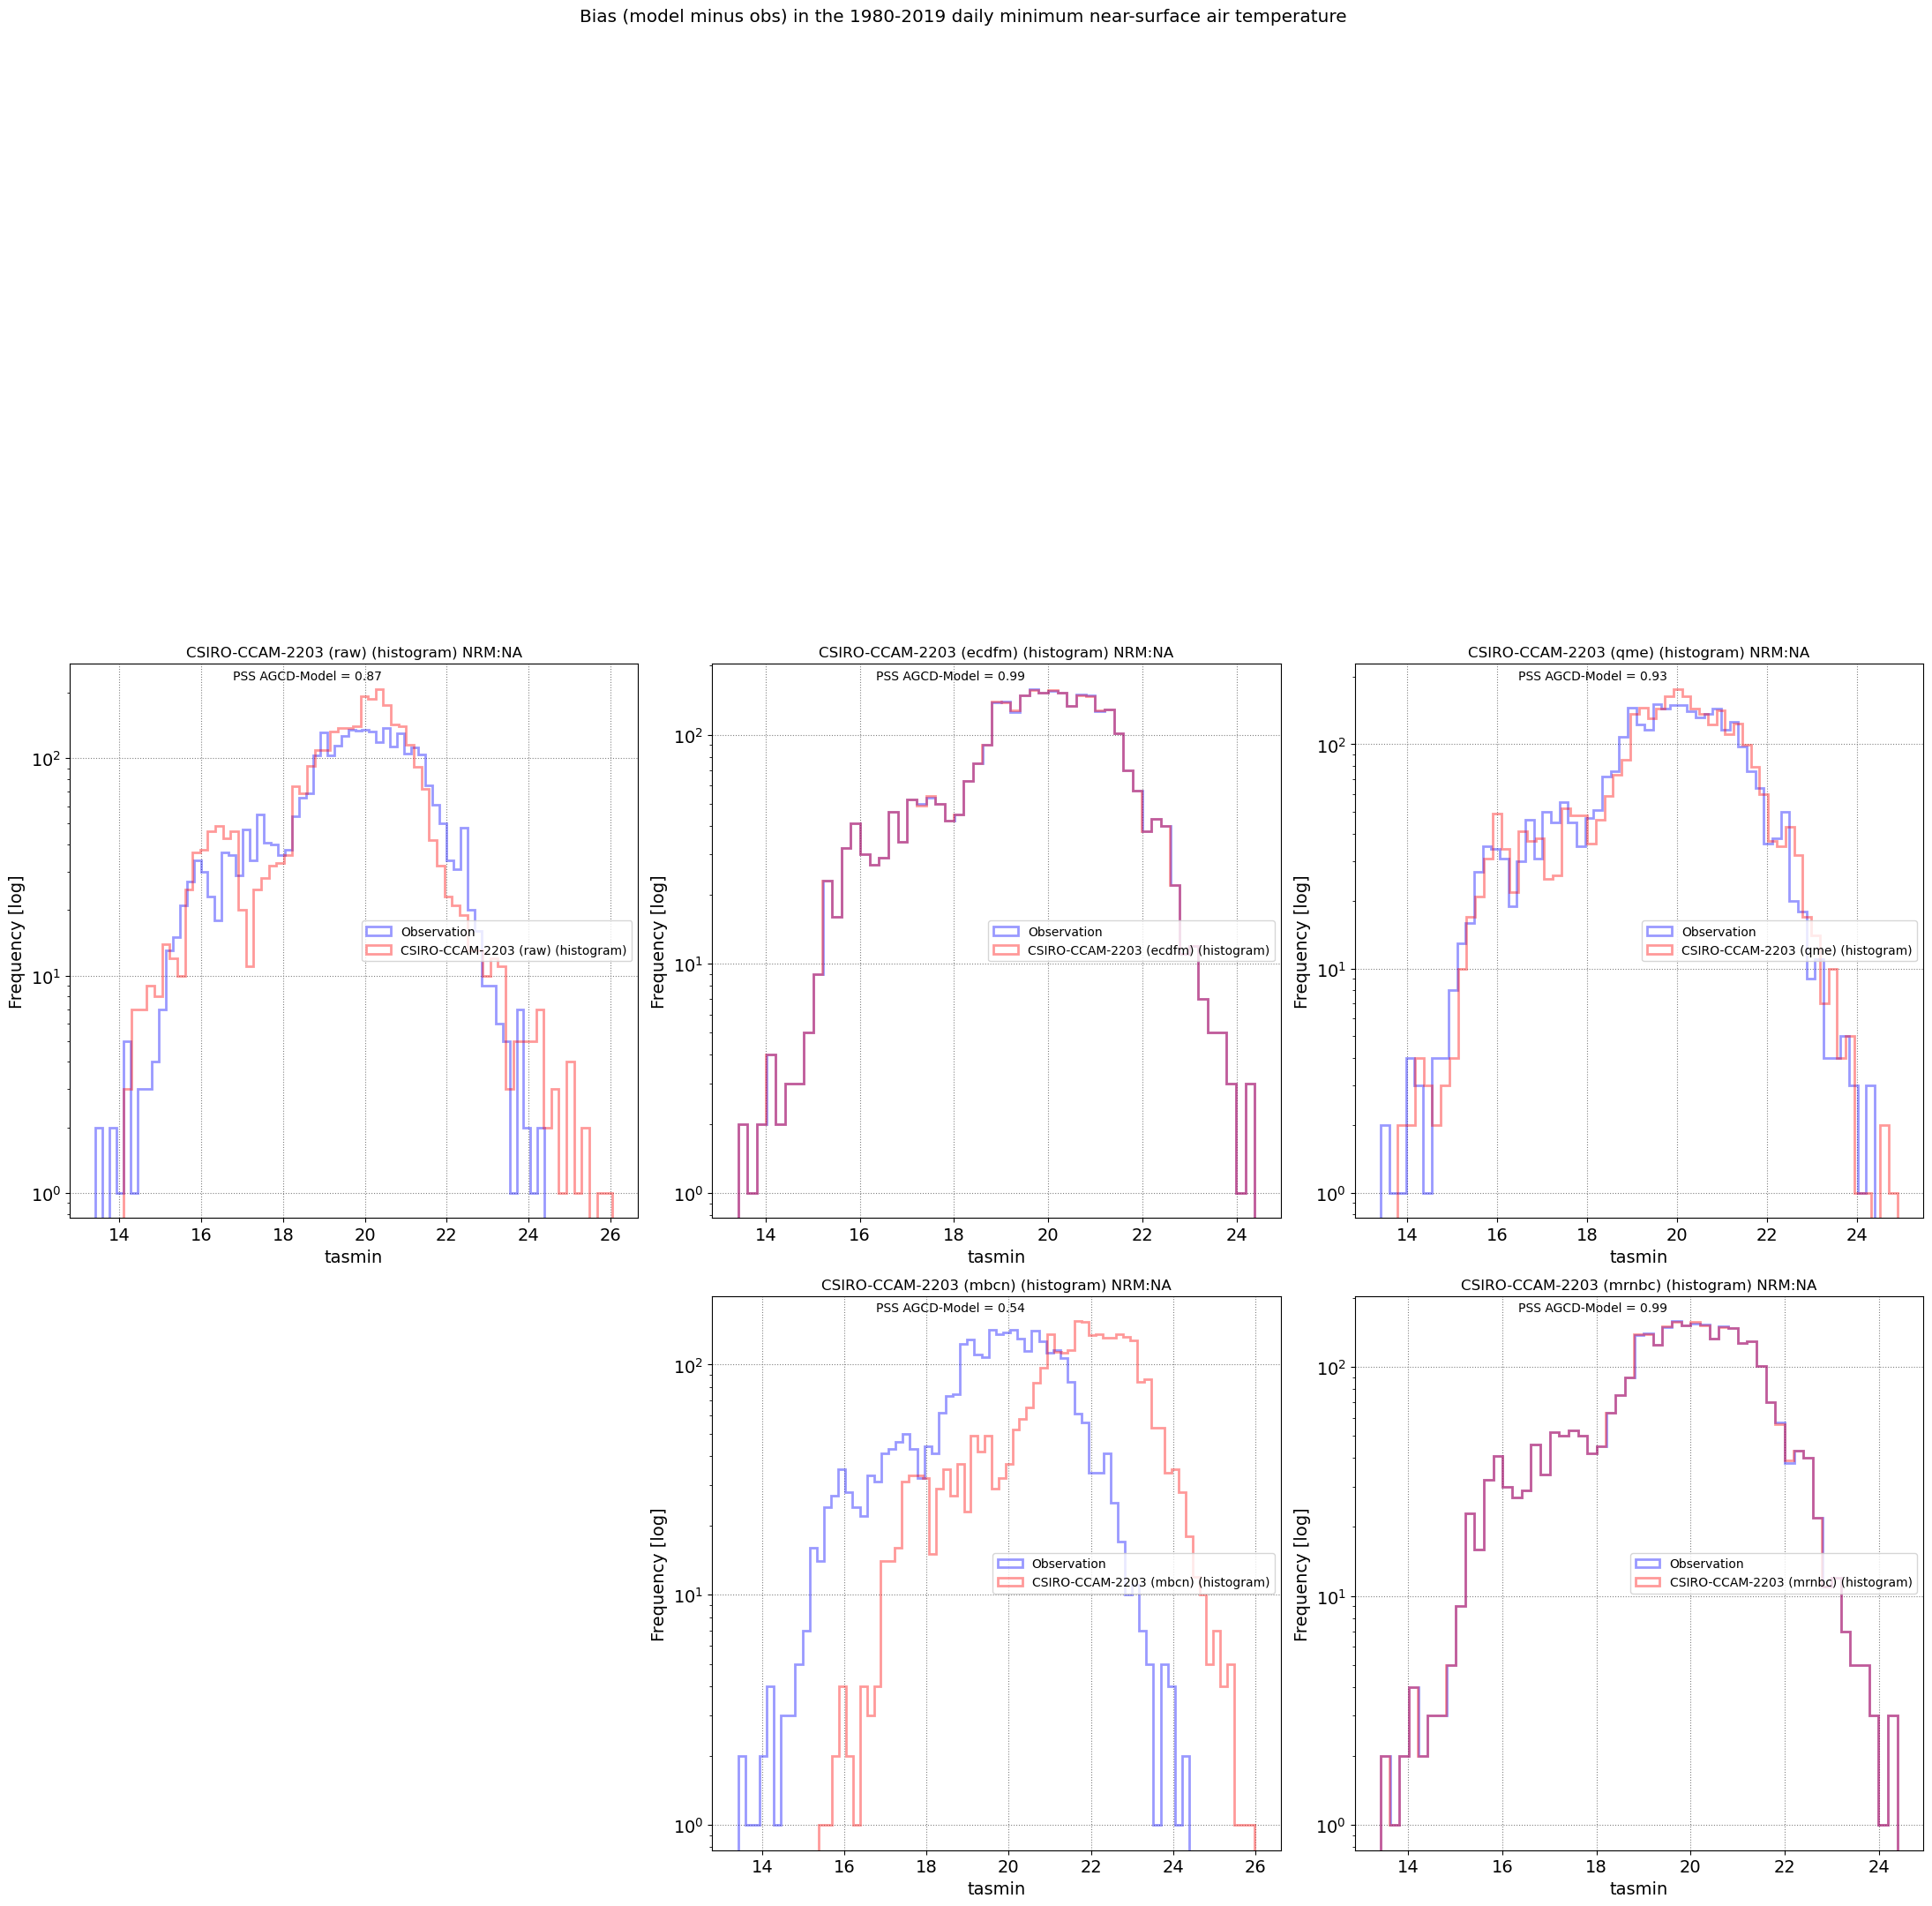

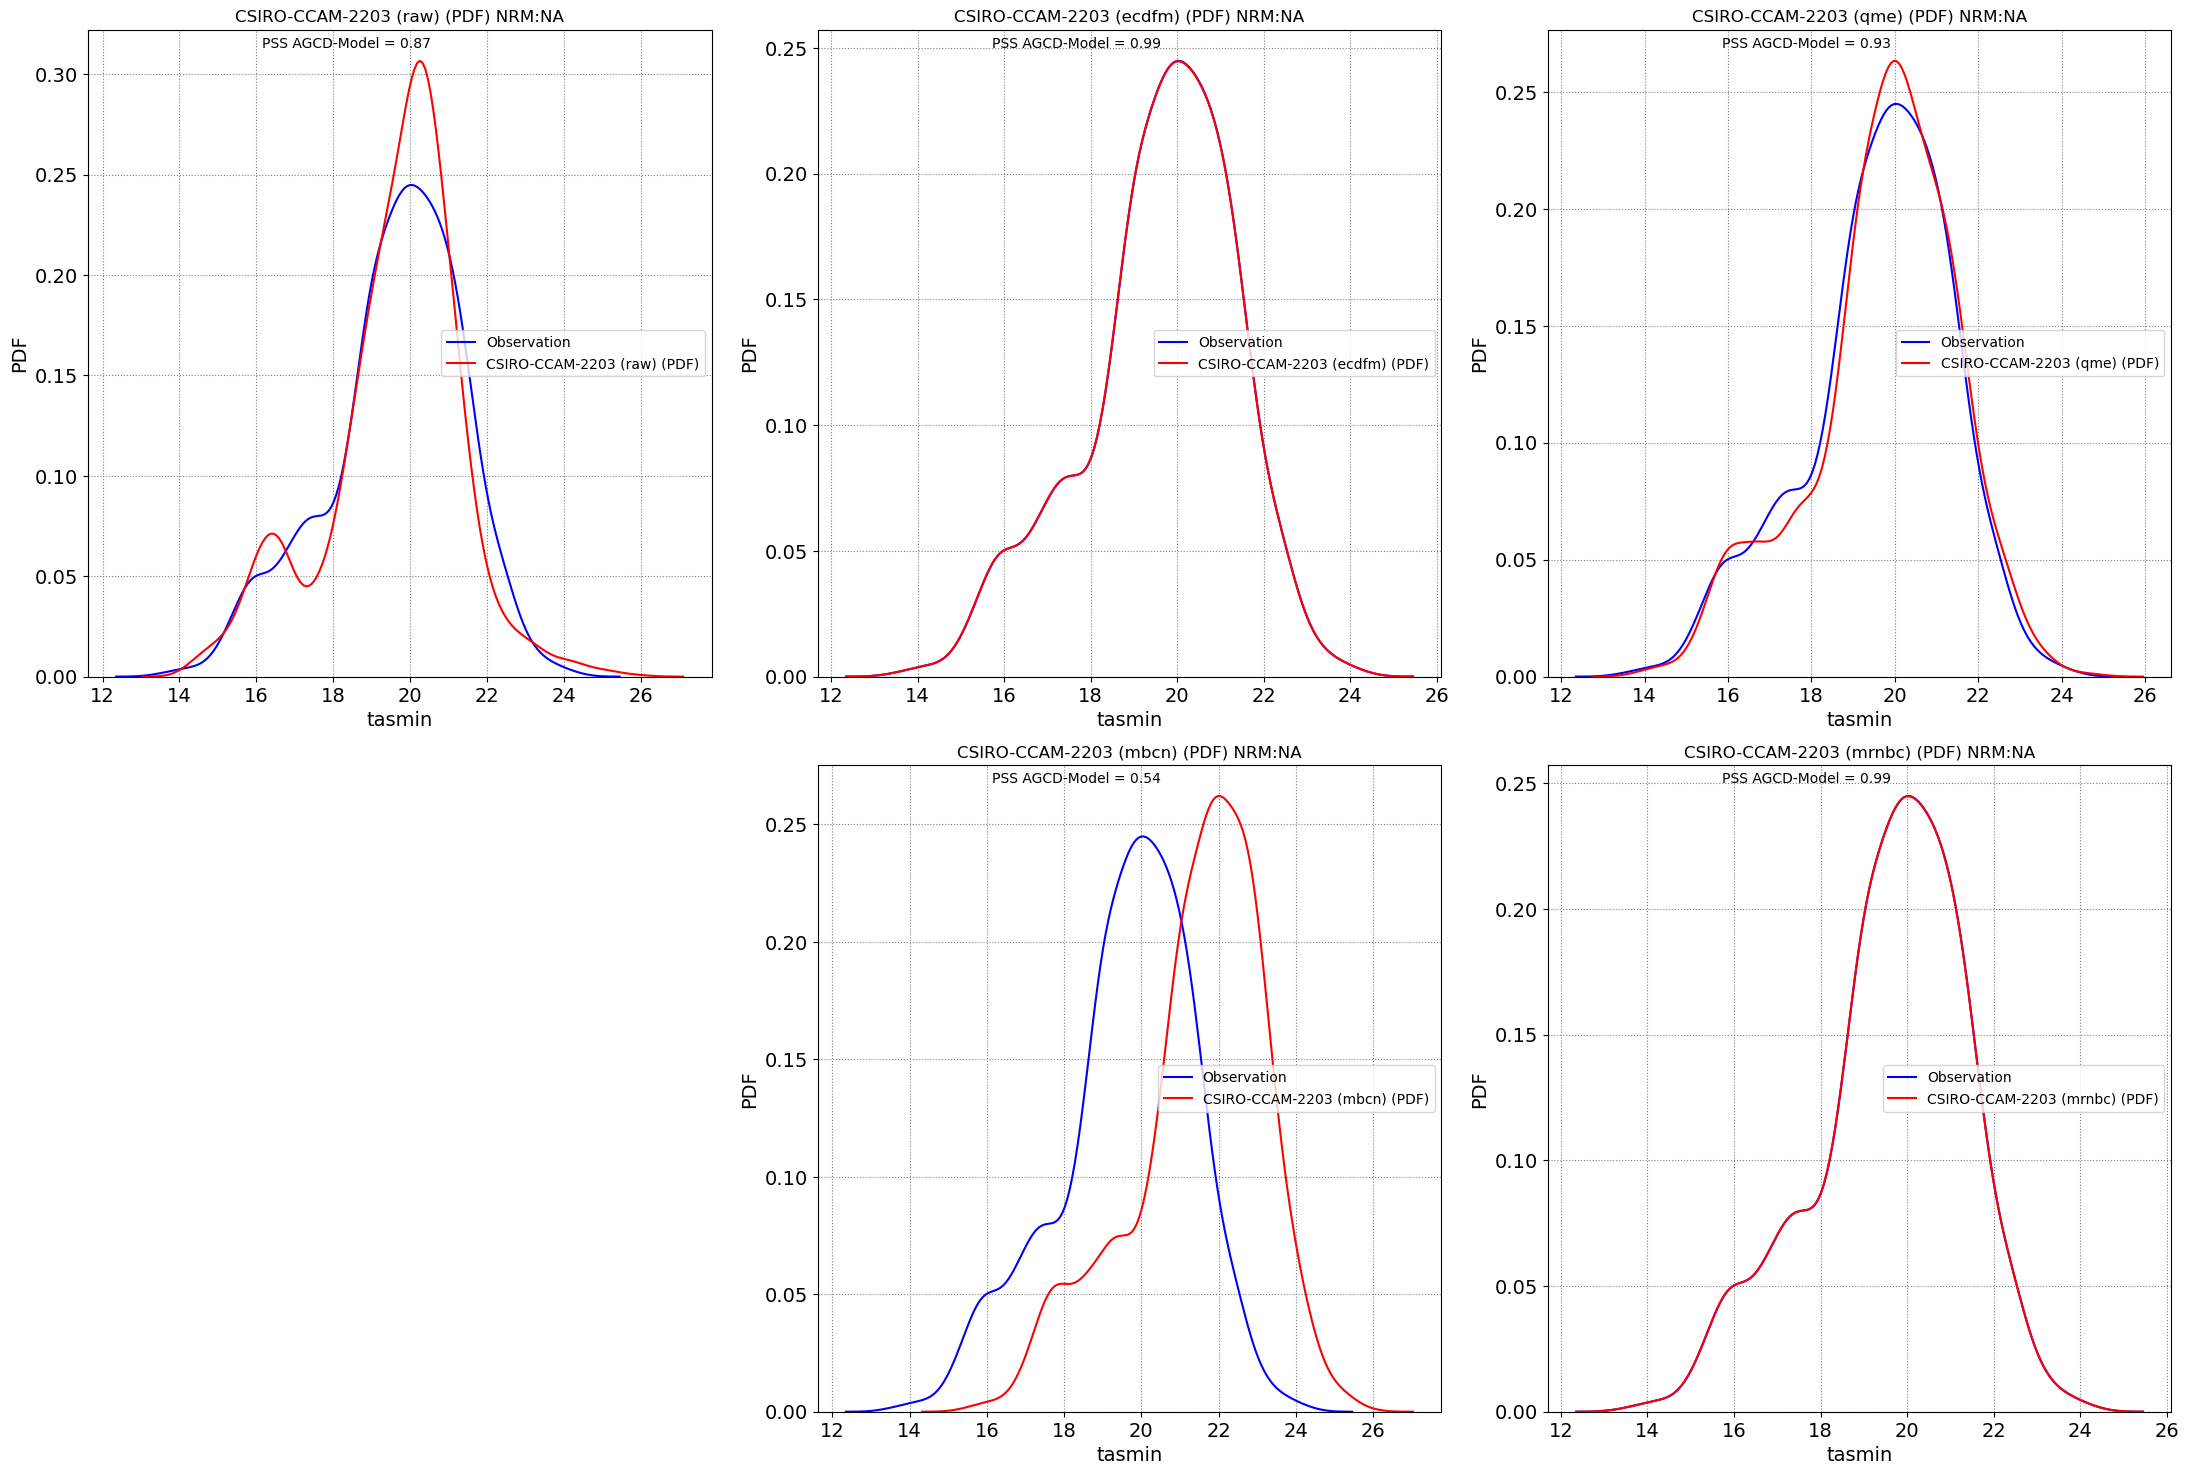

In [14]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

#### EC-Earth3

In [15]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

tasmin_extreme-bias_task-historical_EC-Earth-Consortium-EC-Earth3_BOM-BARPA-R_NA.png


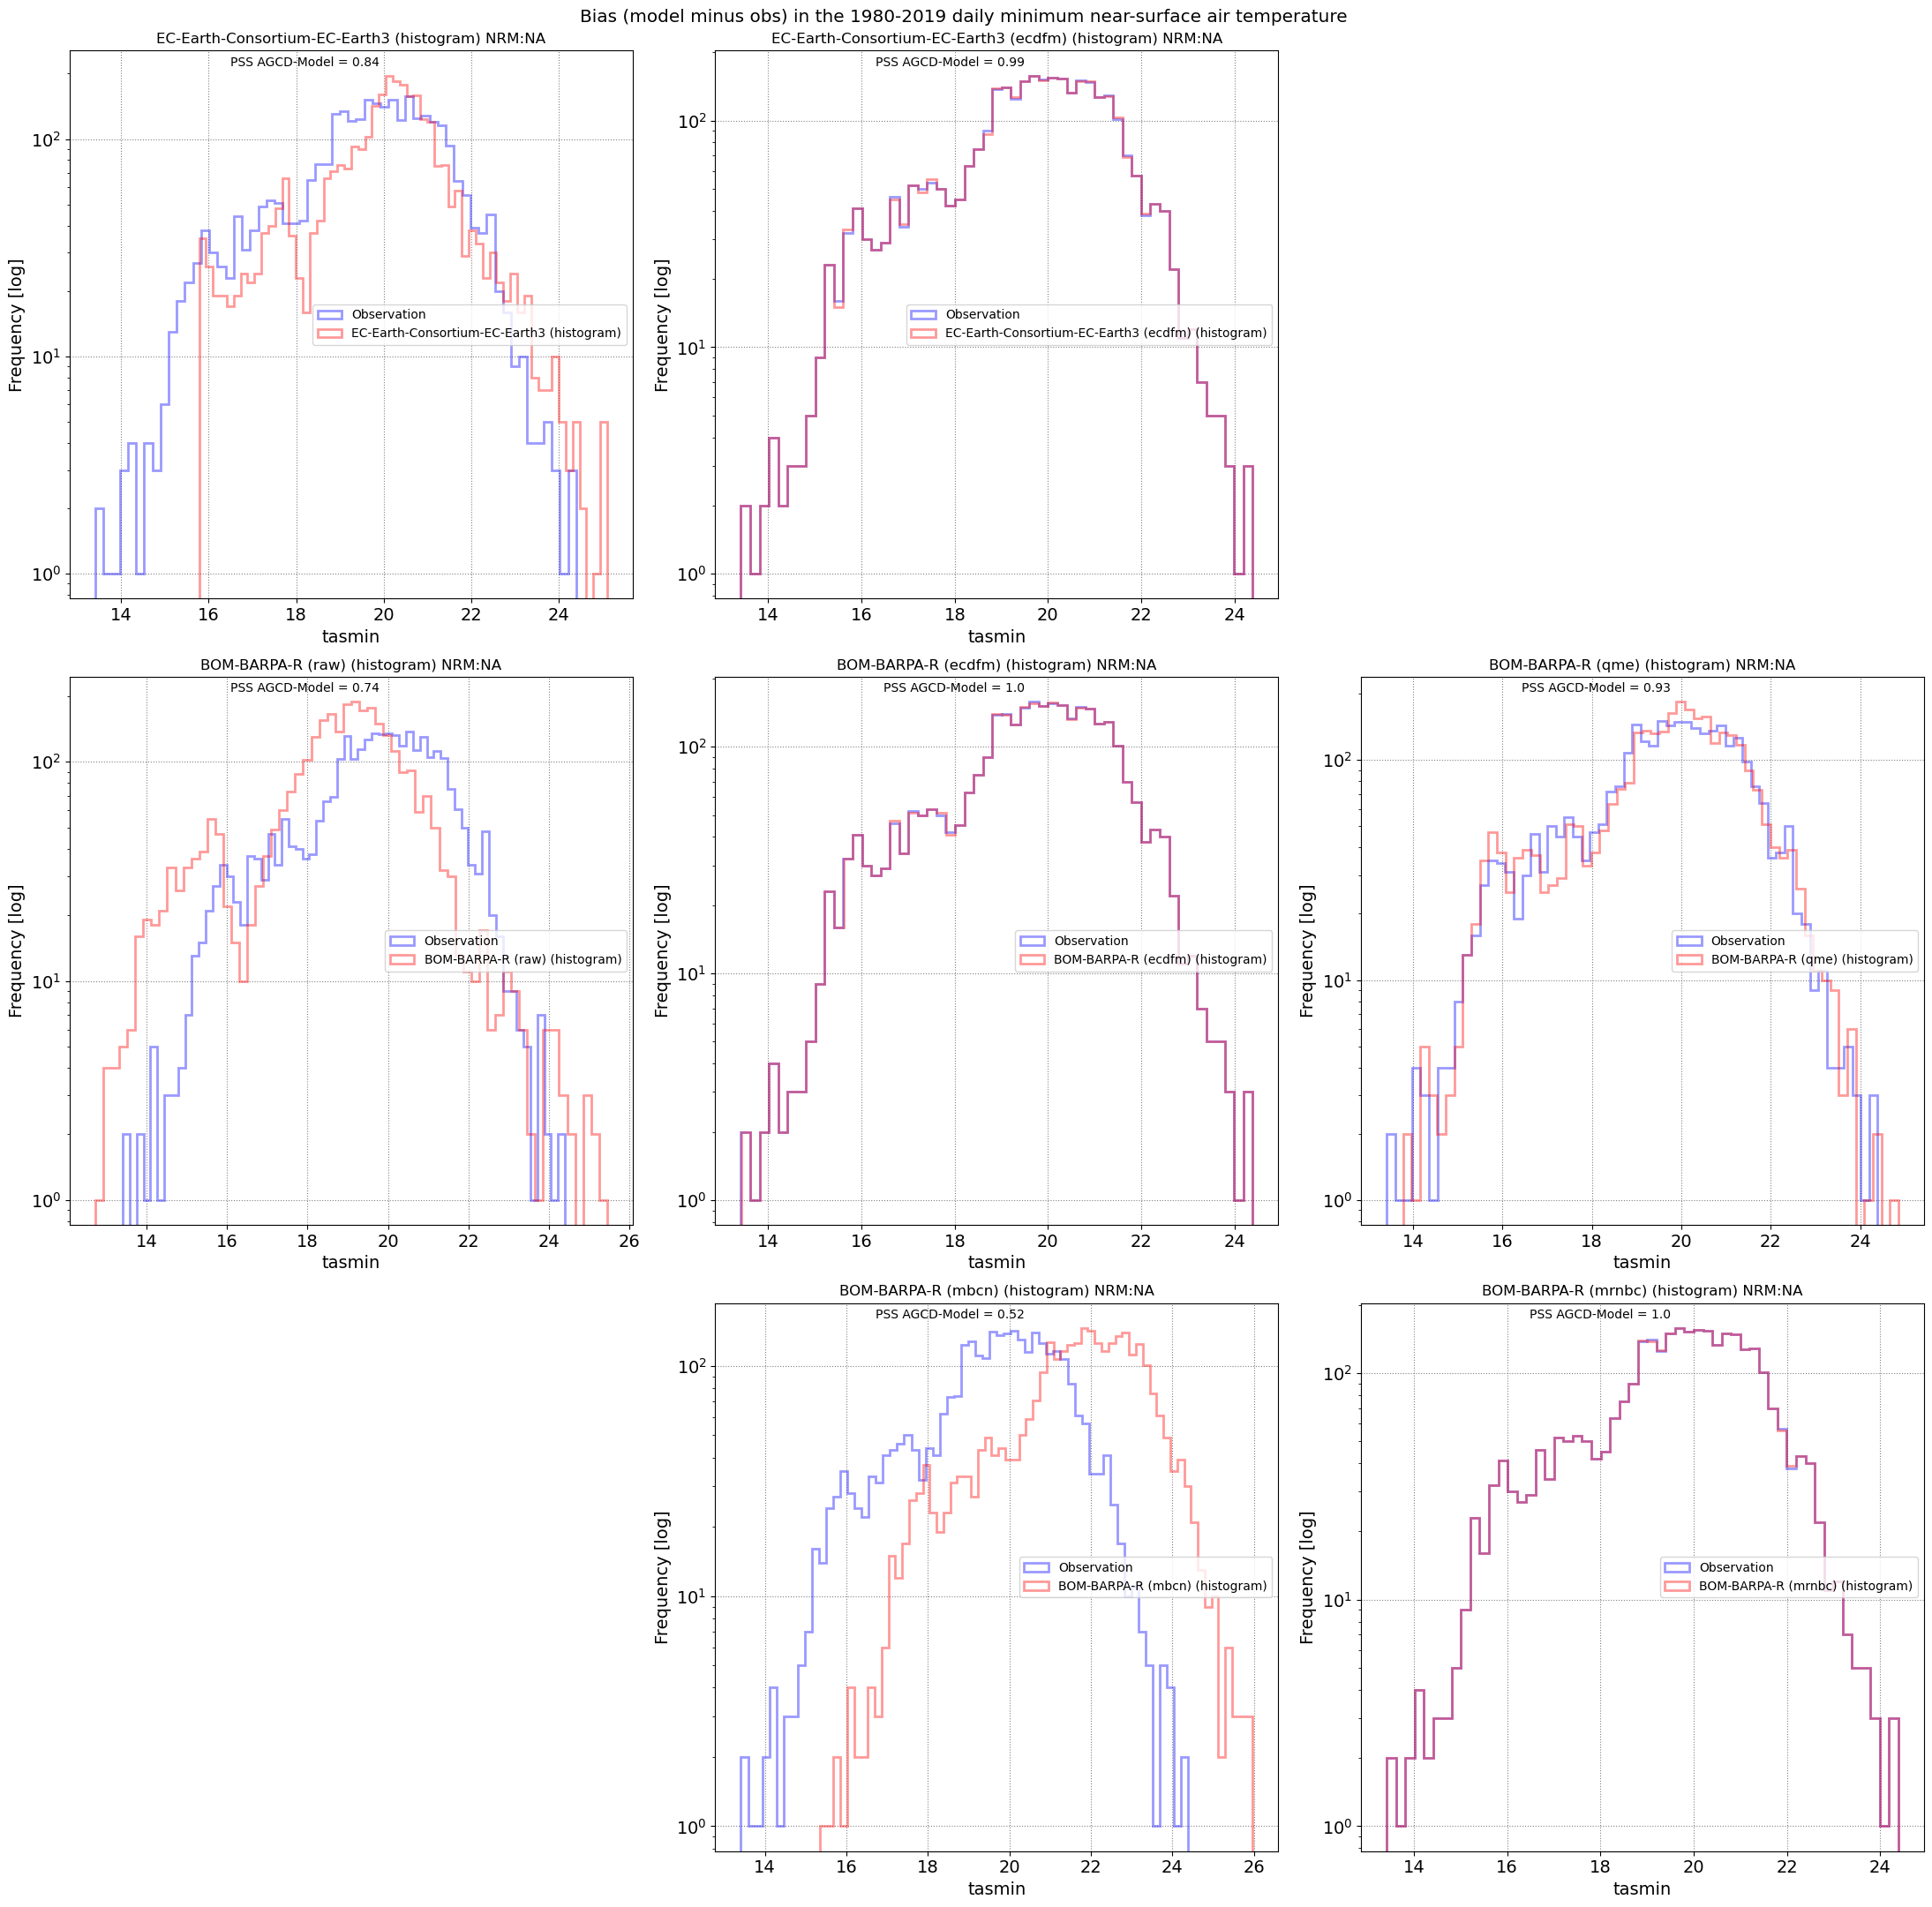

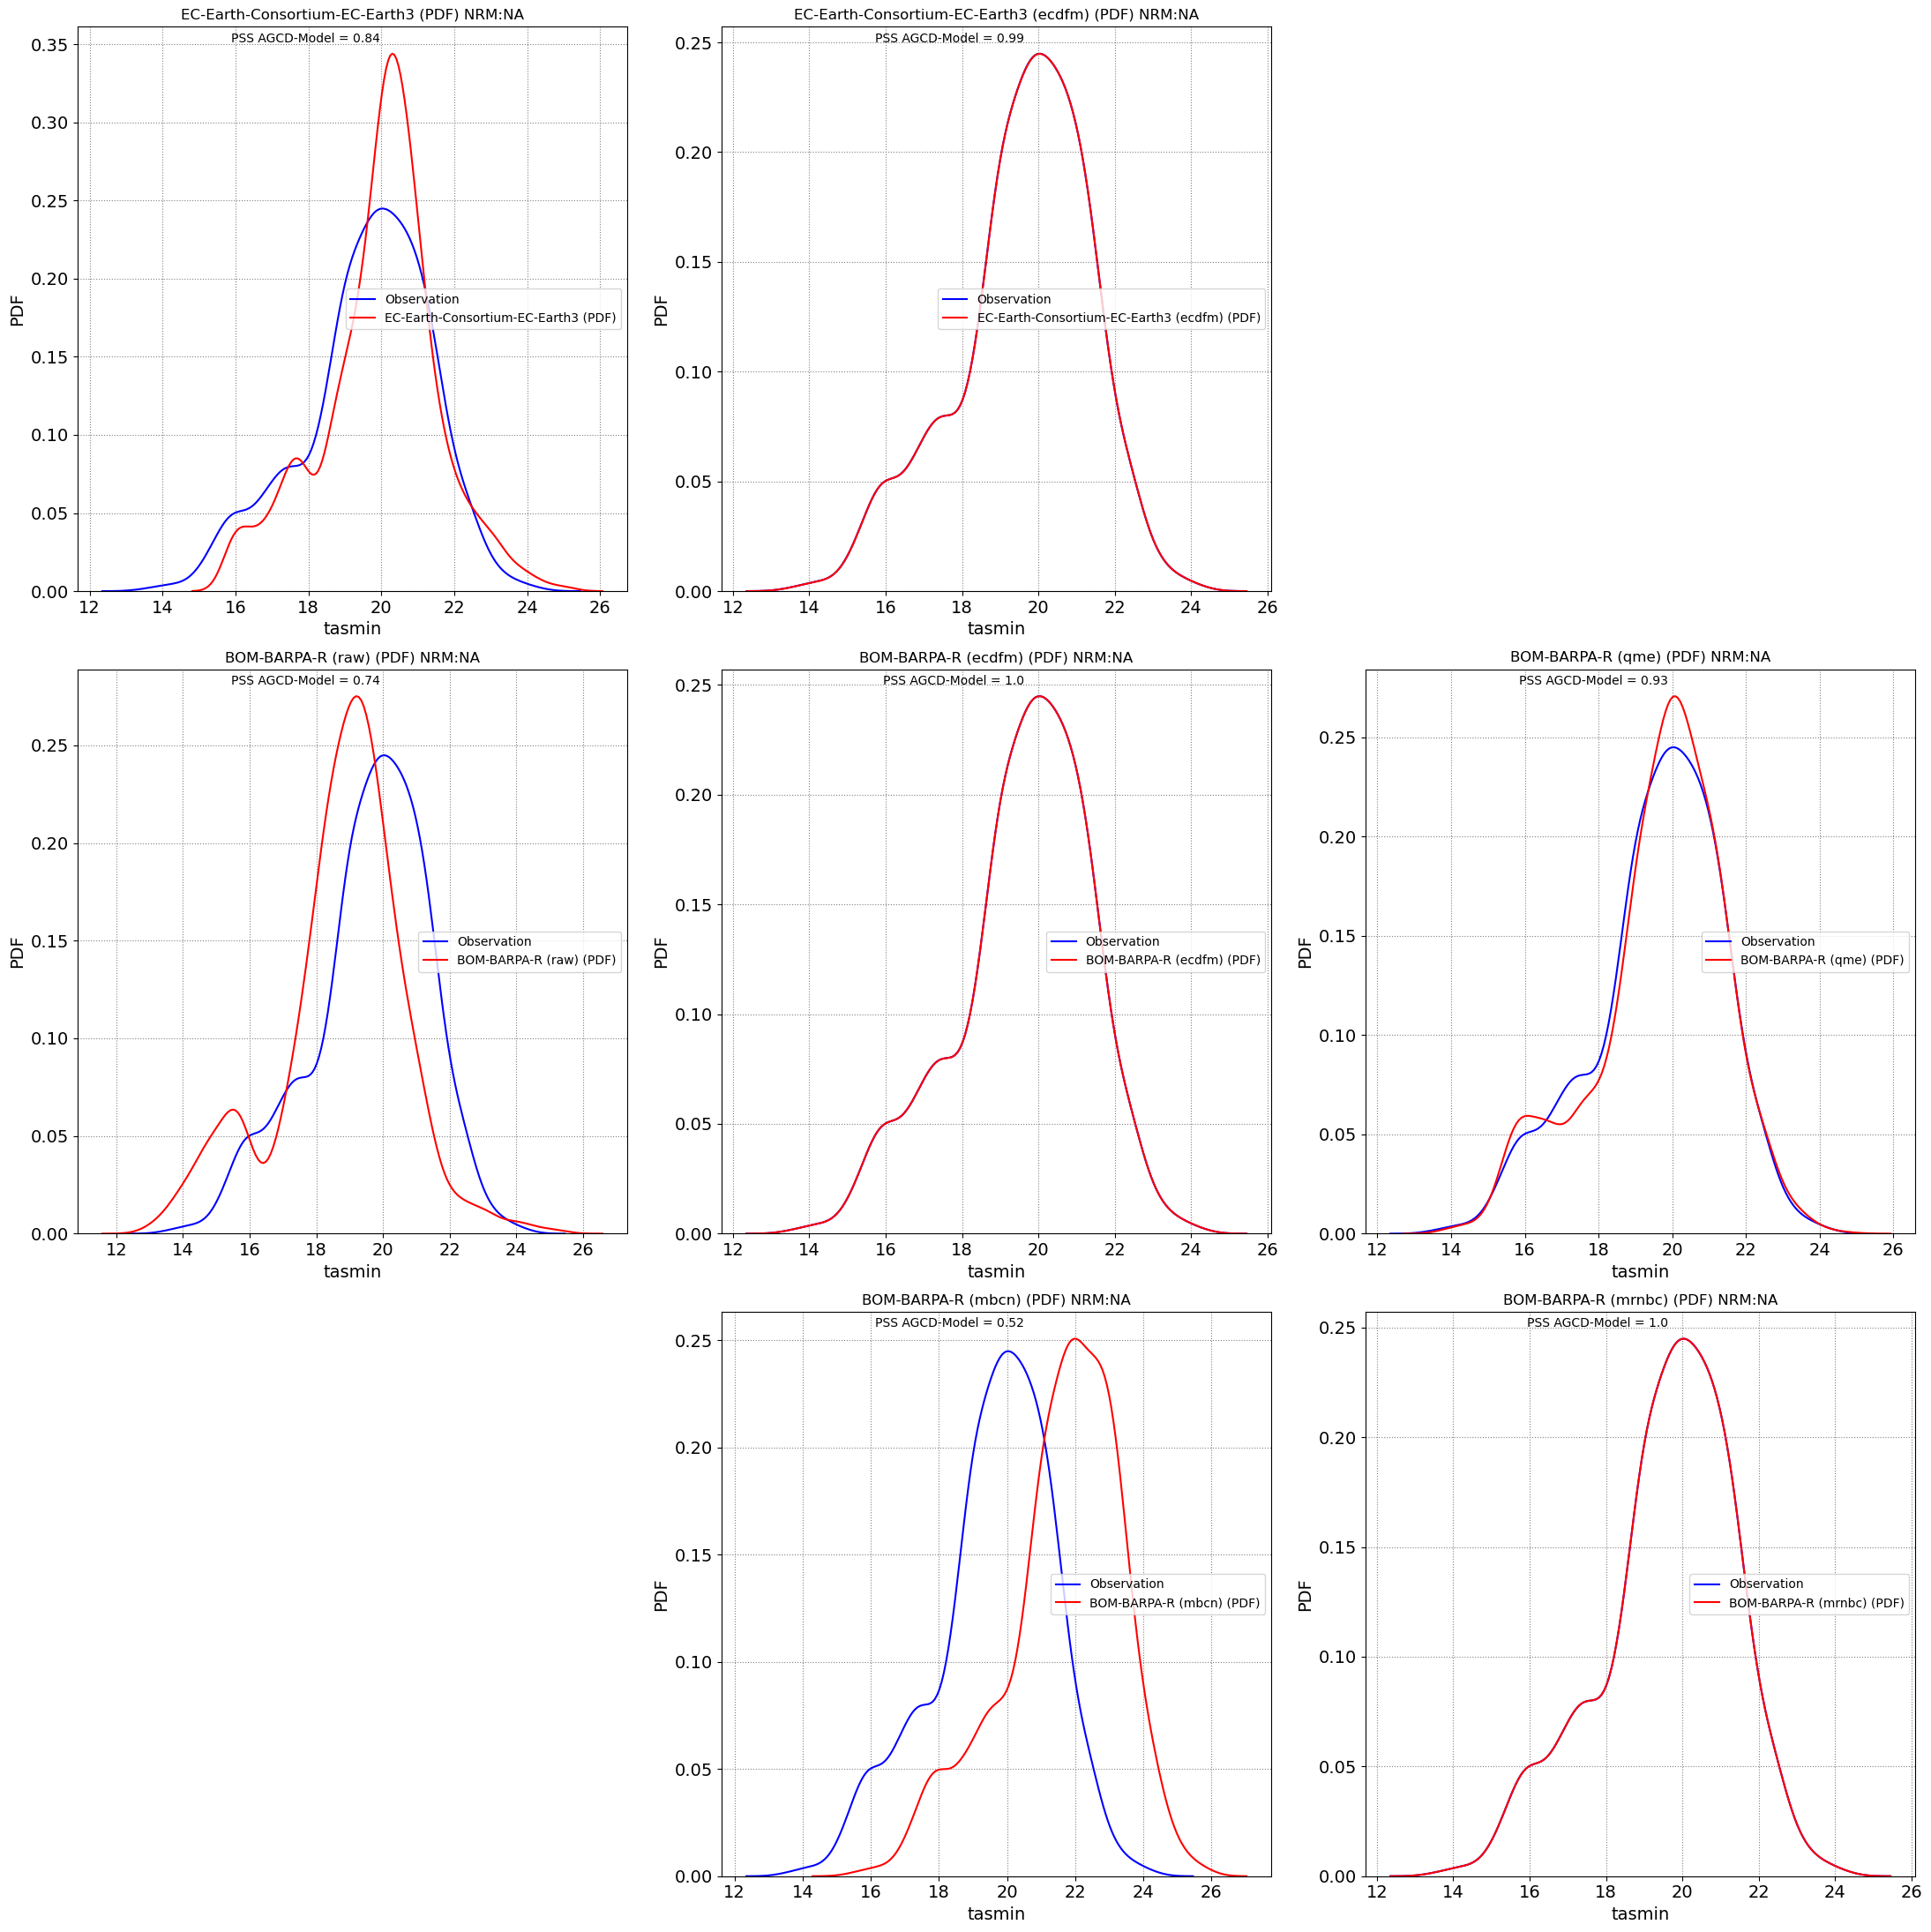

In [16]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, save_outfile=True)

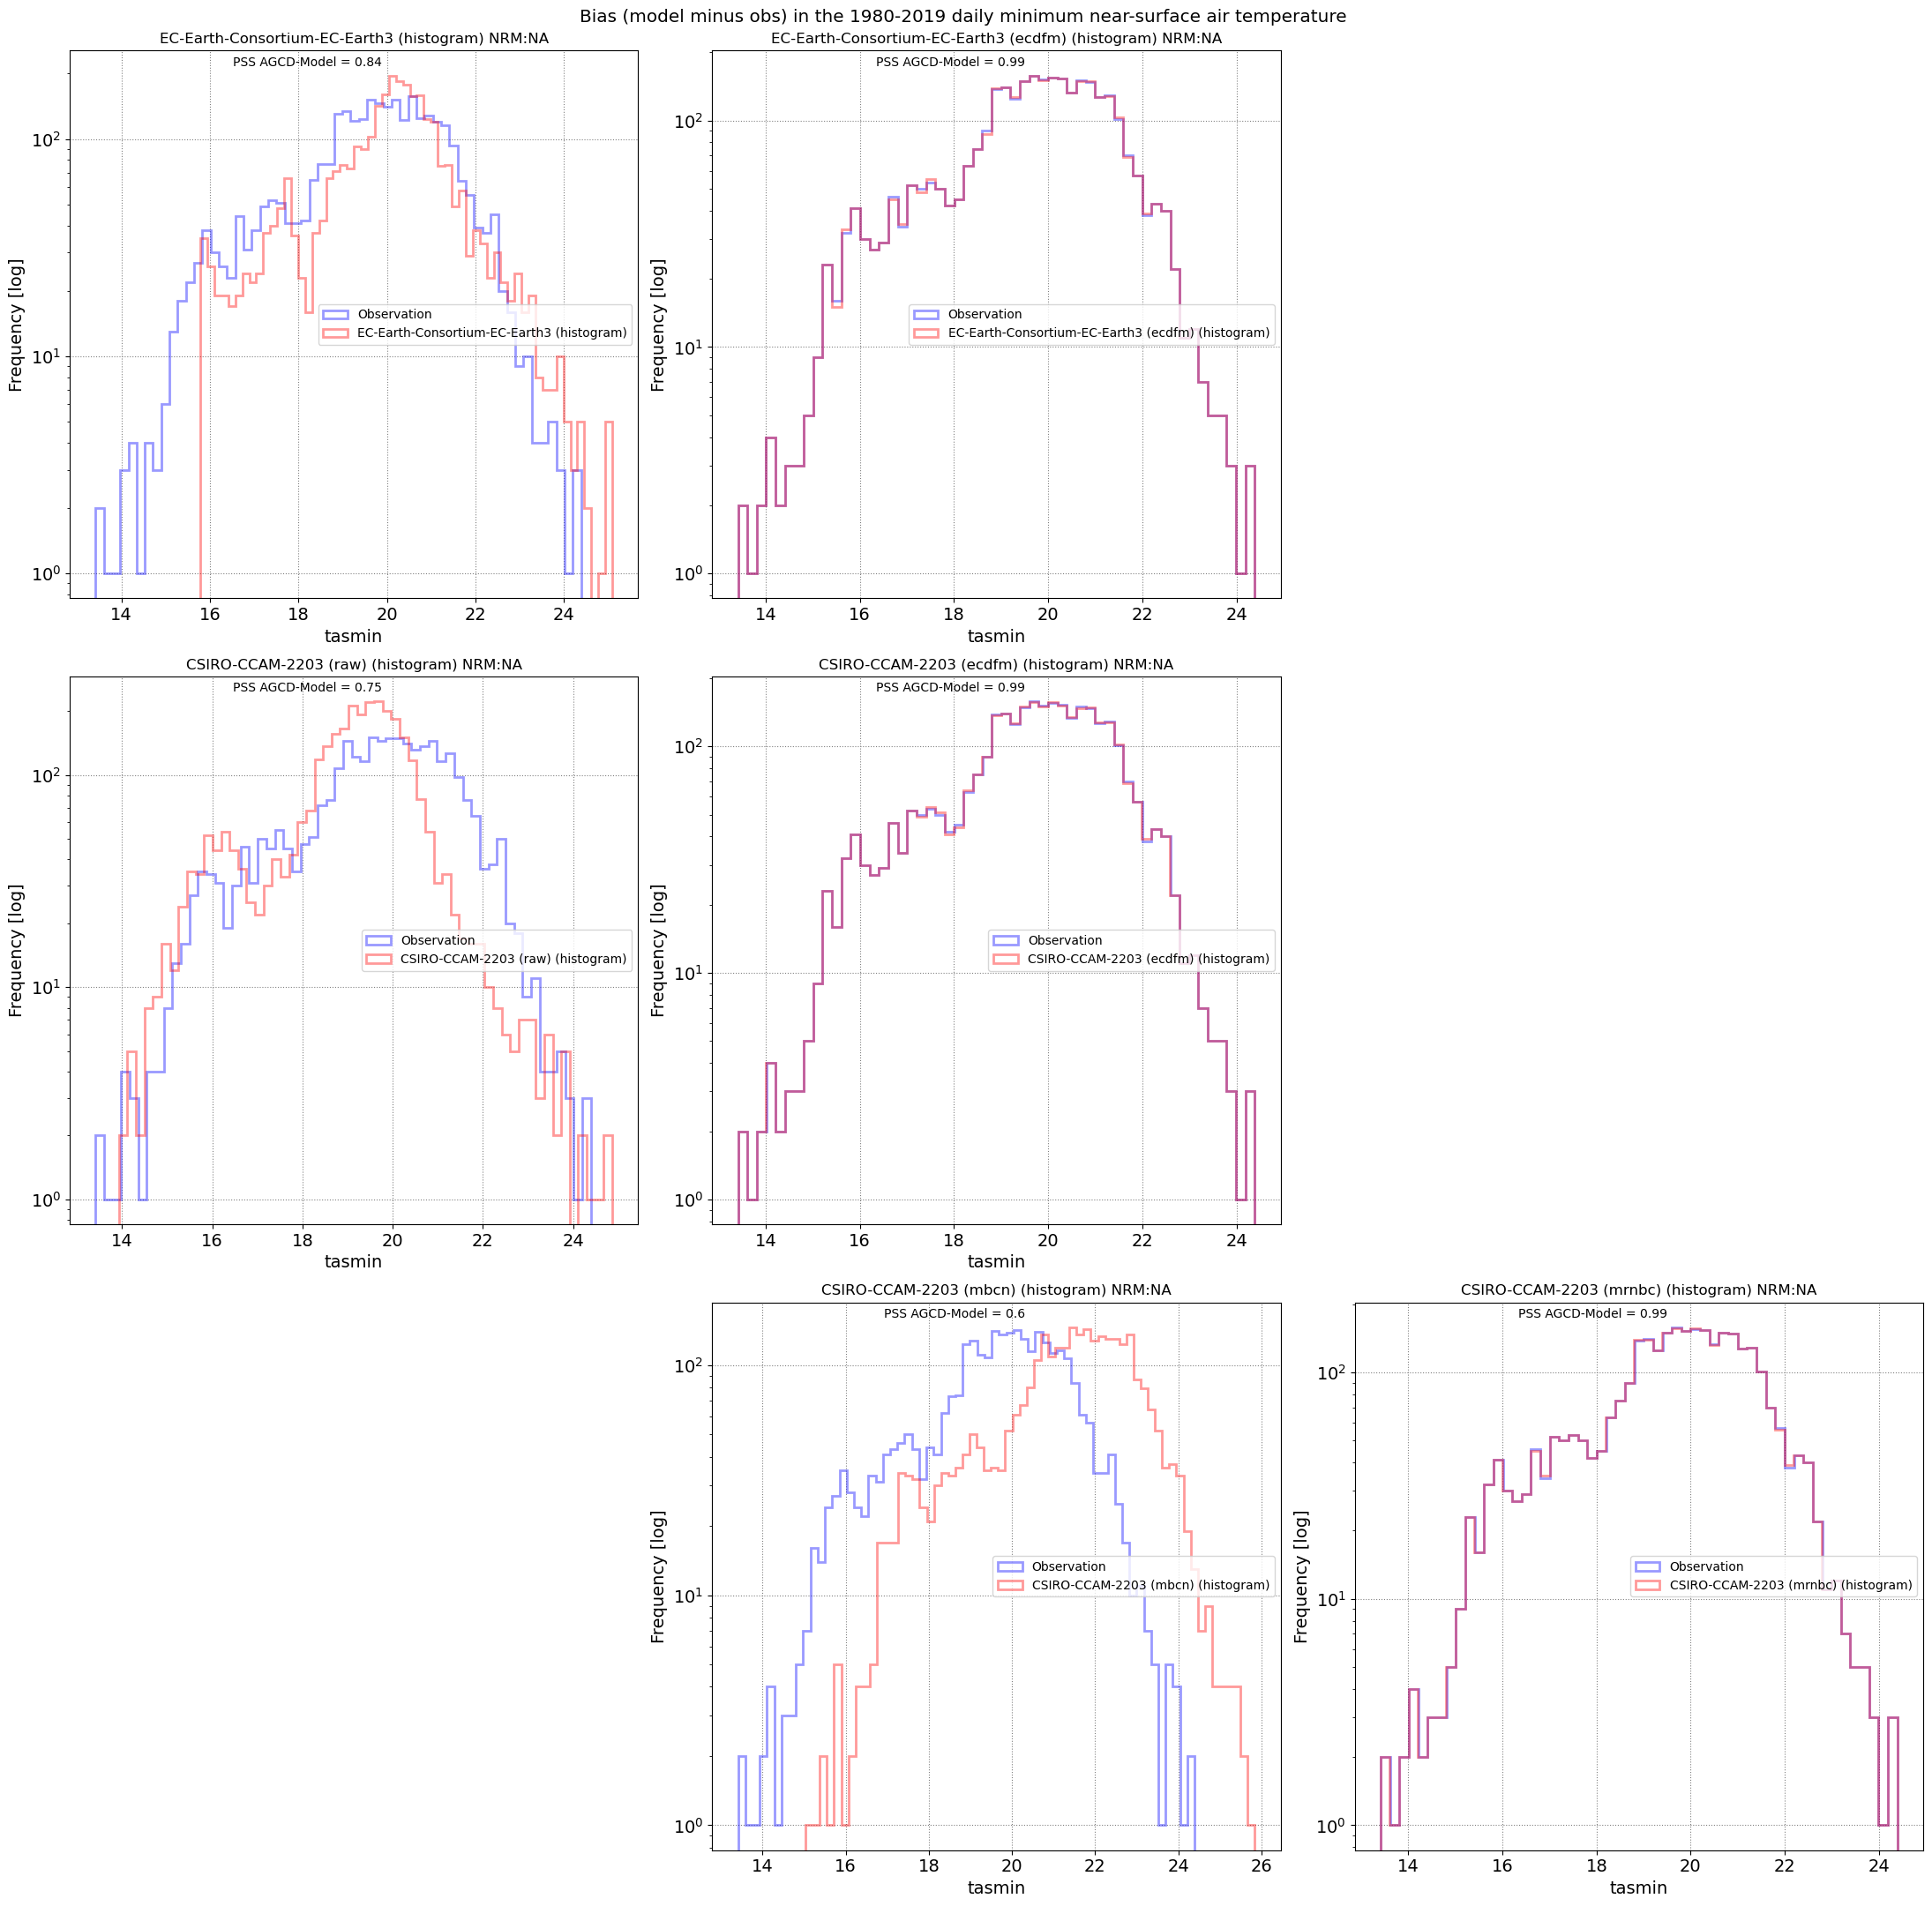

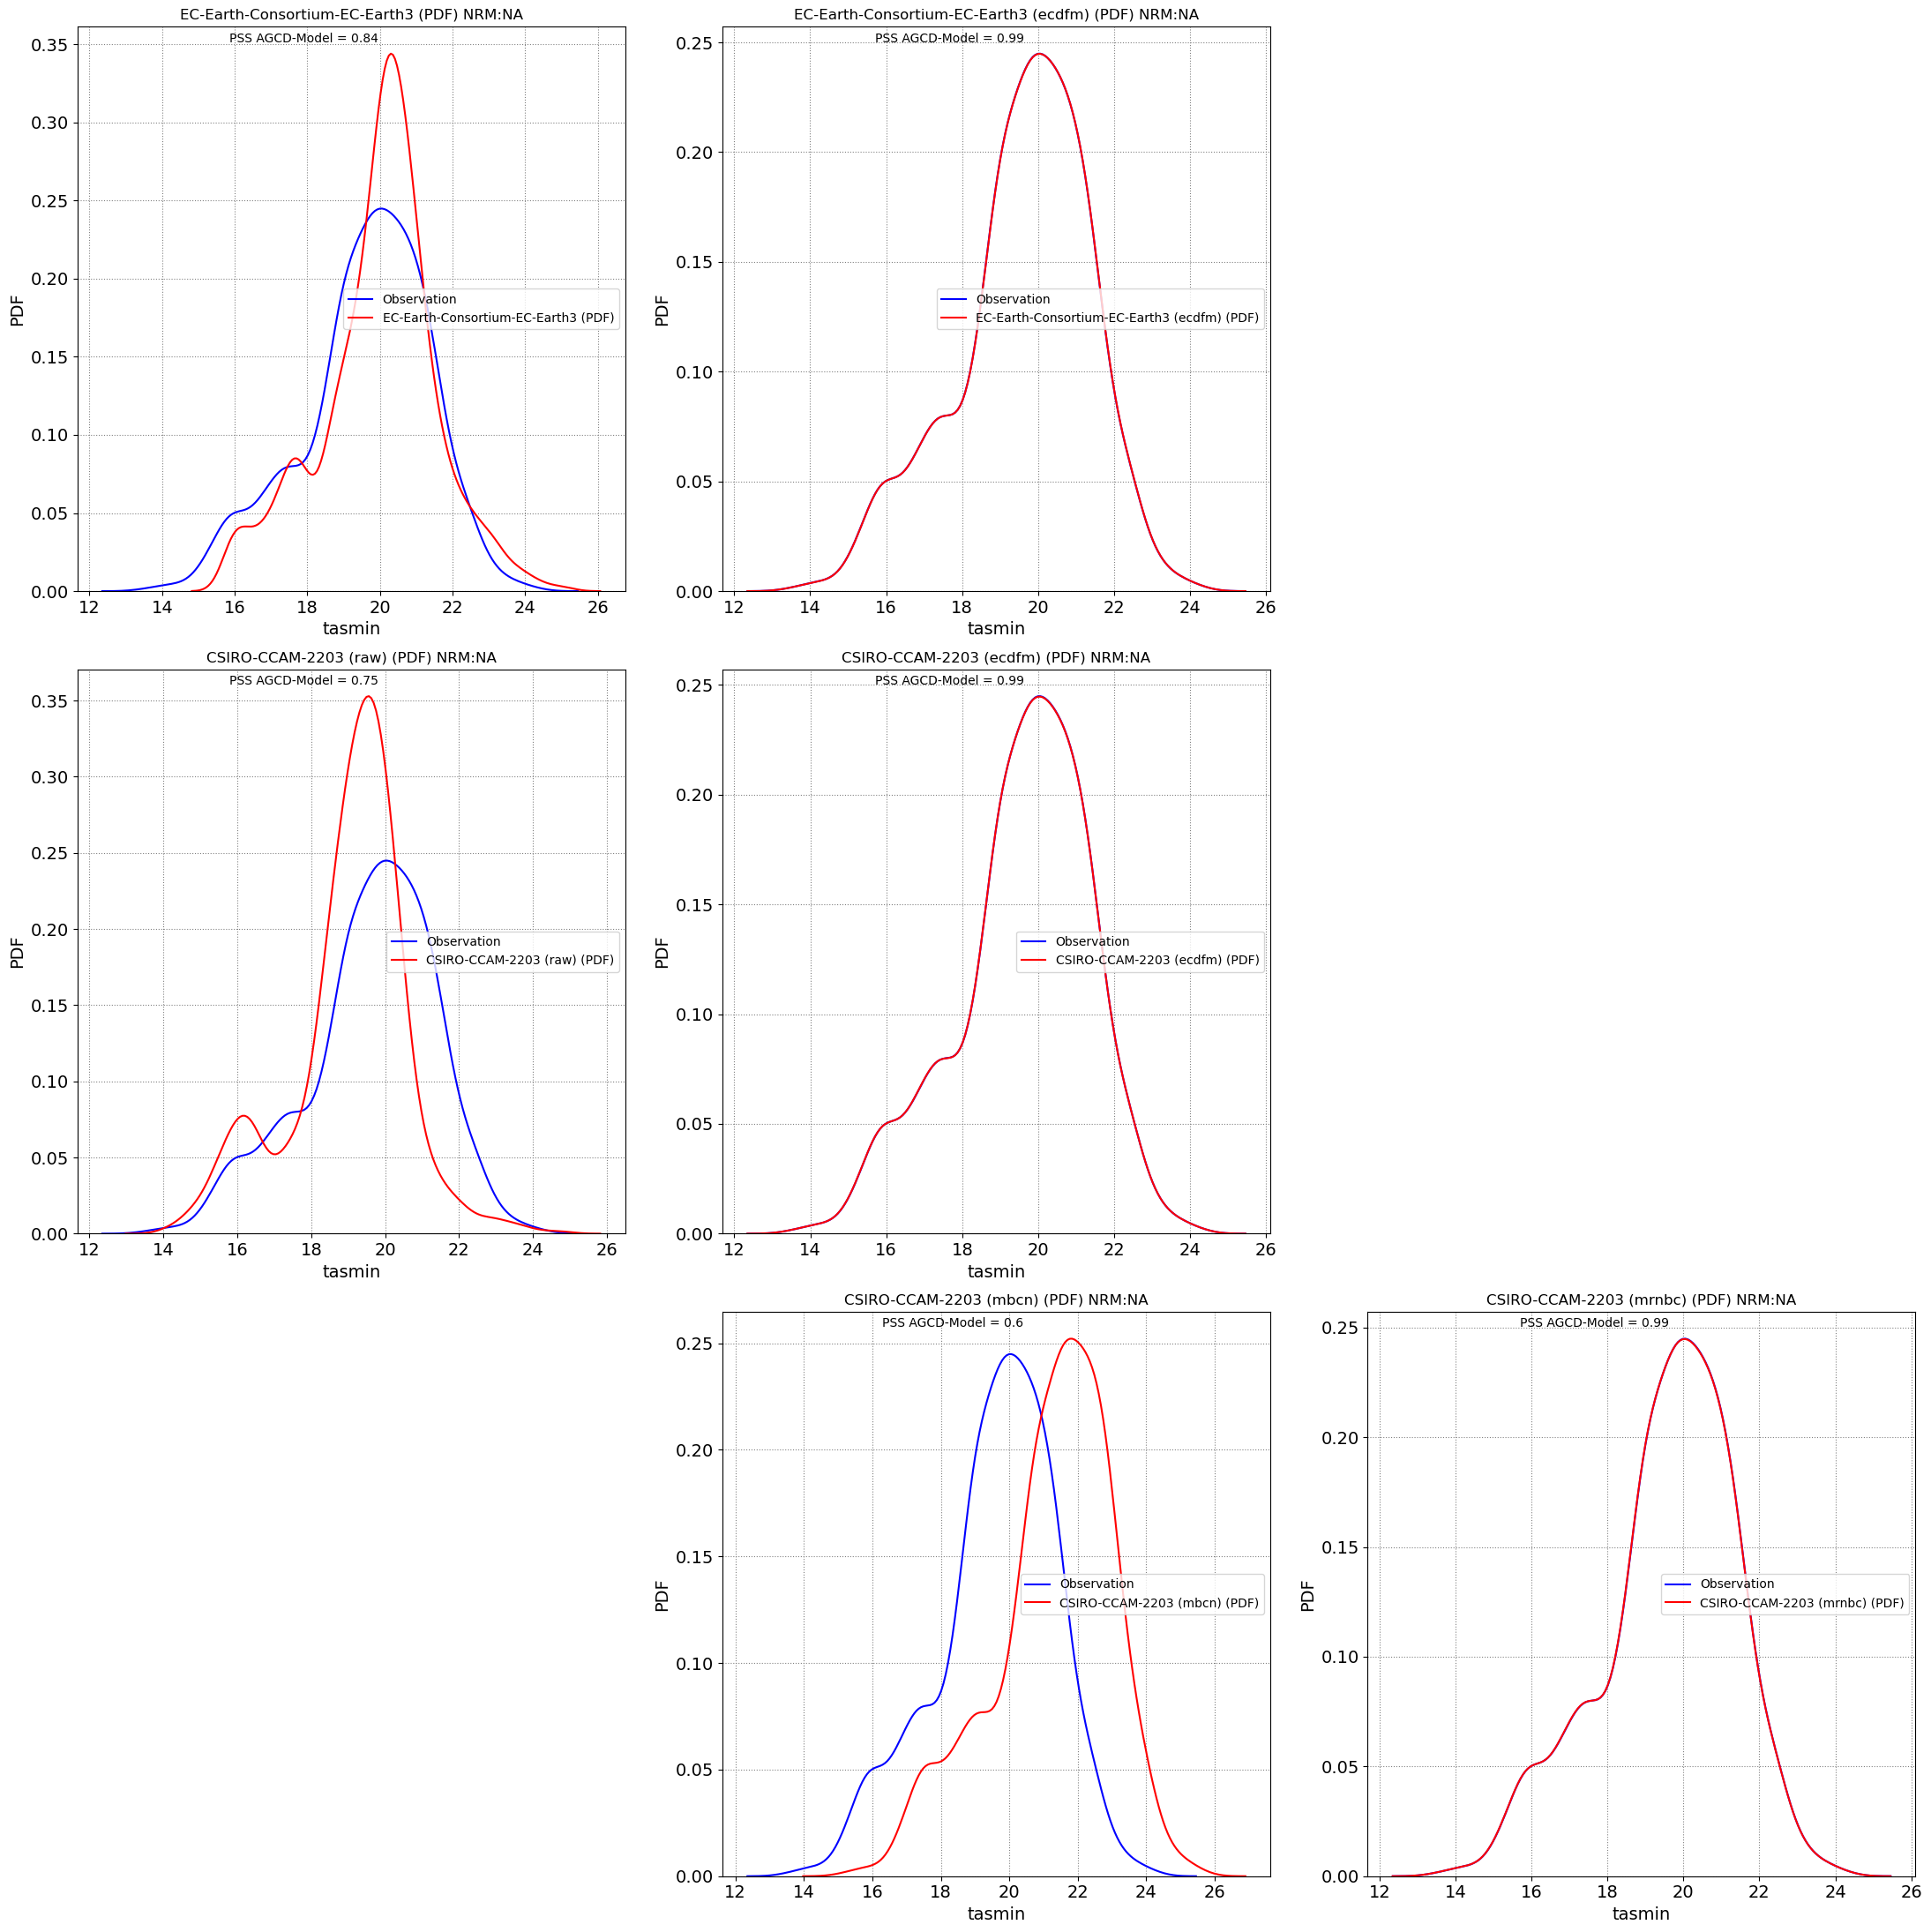

In [17]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date)

# task-xvalidation




### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.


In [18]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

tasmin_extreme-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_BOM-BARPA-R_NA.png


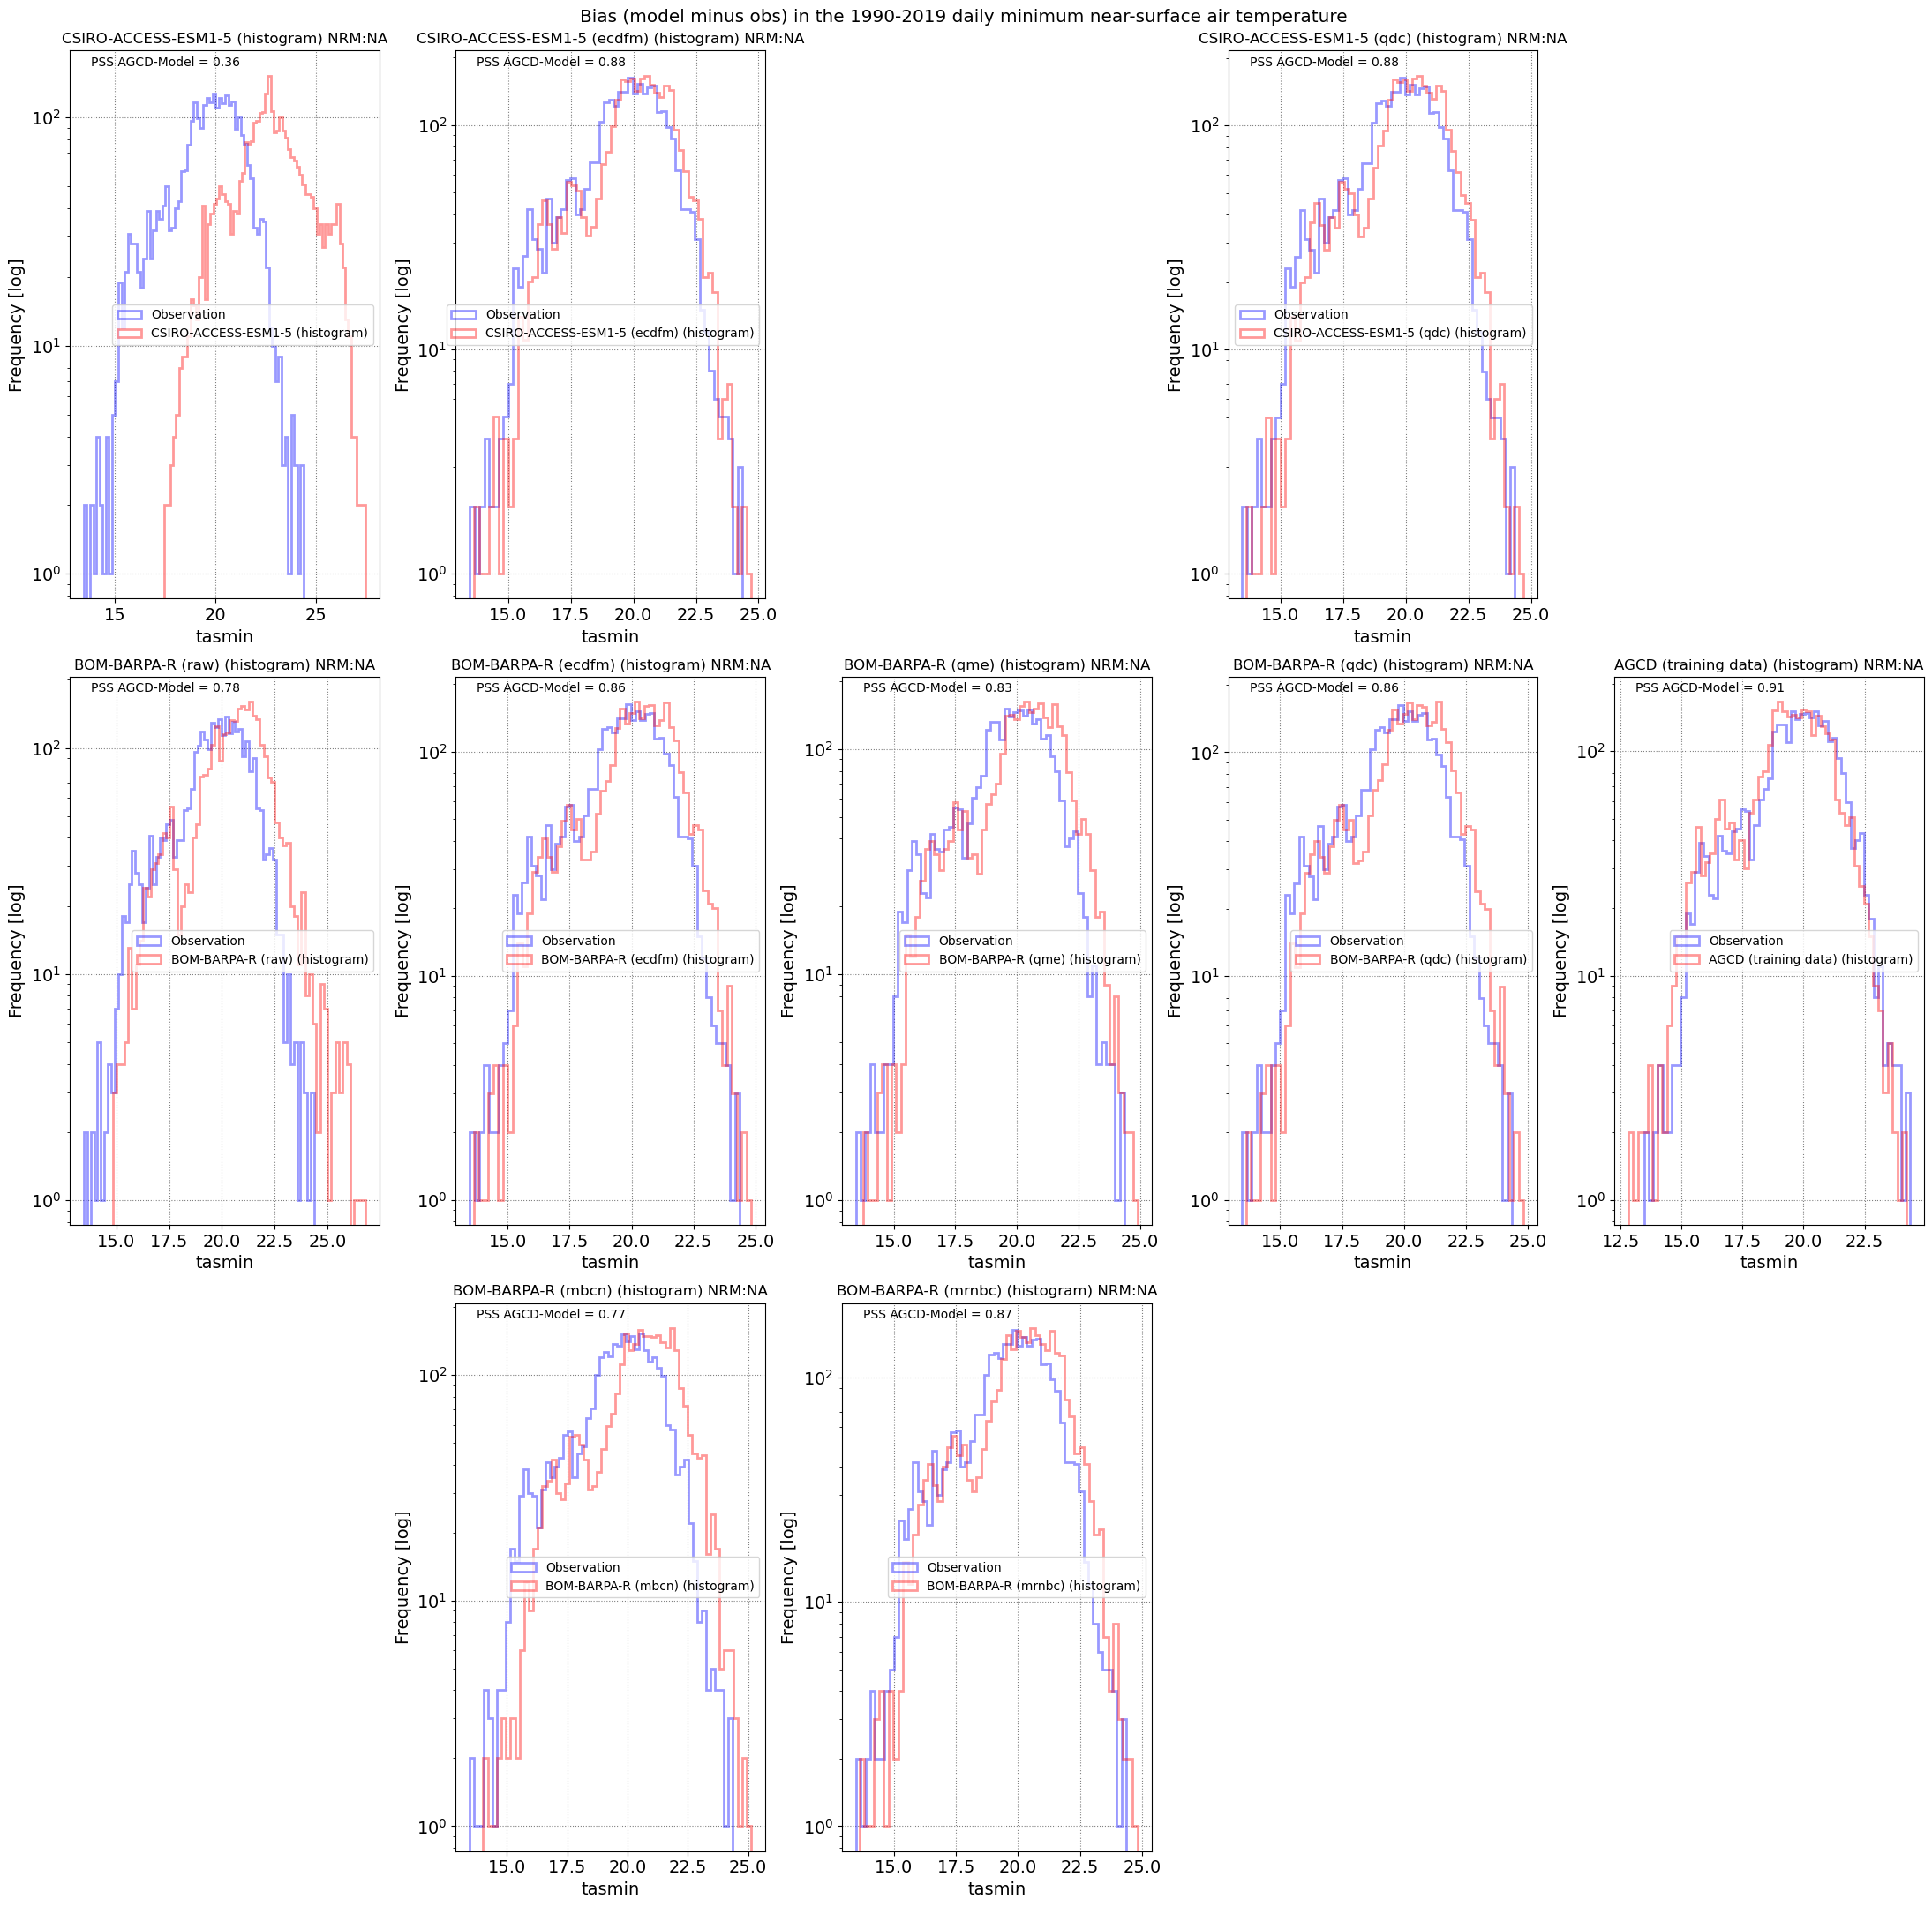

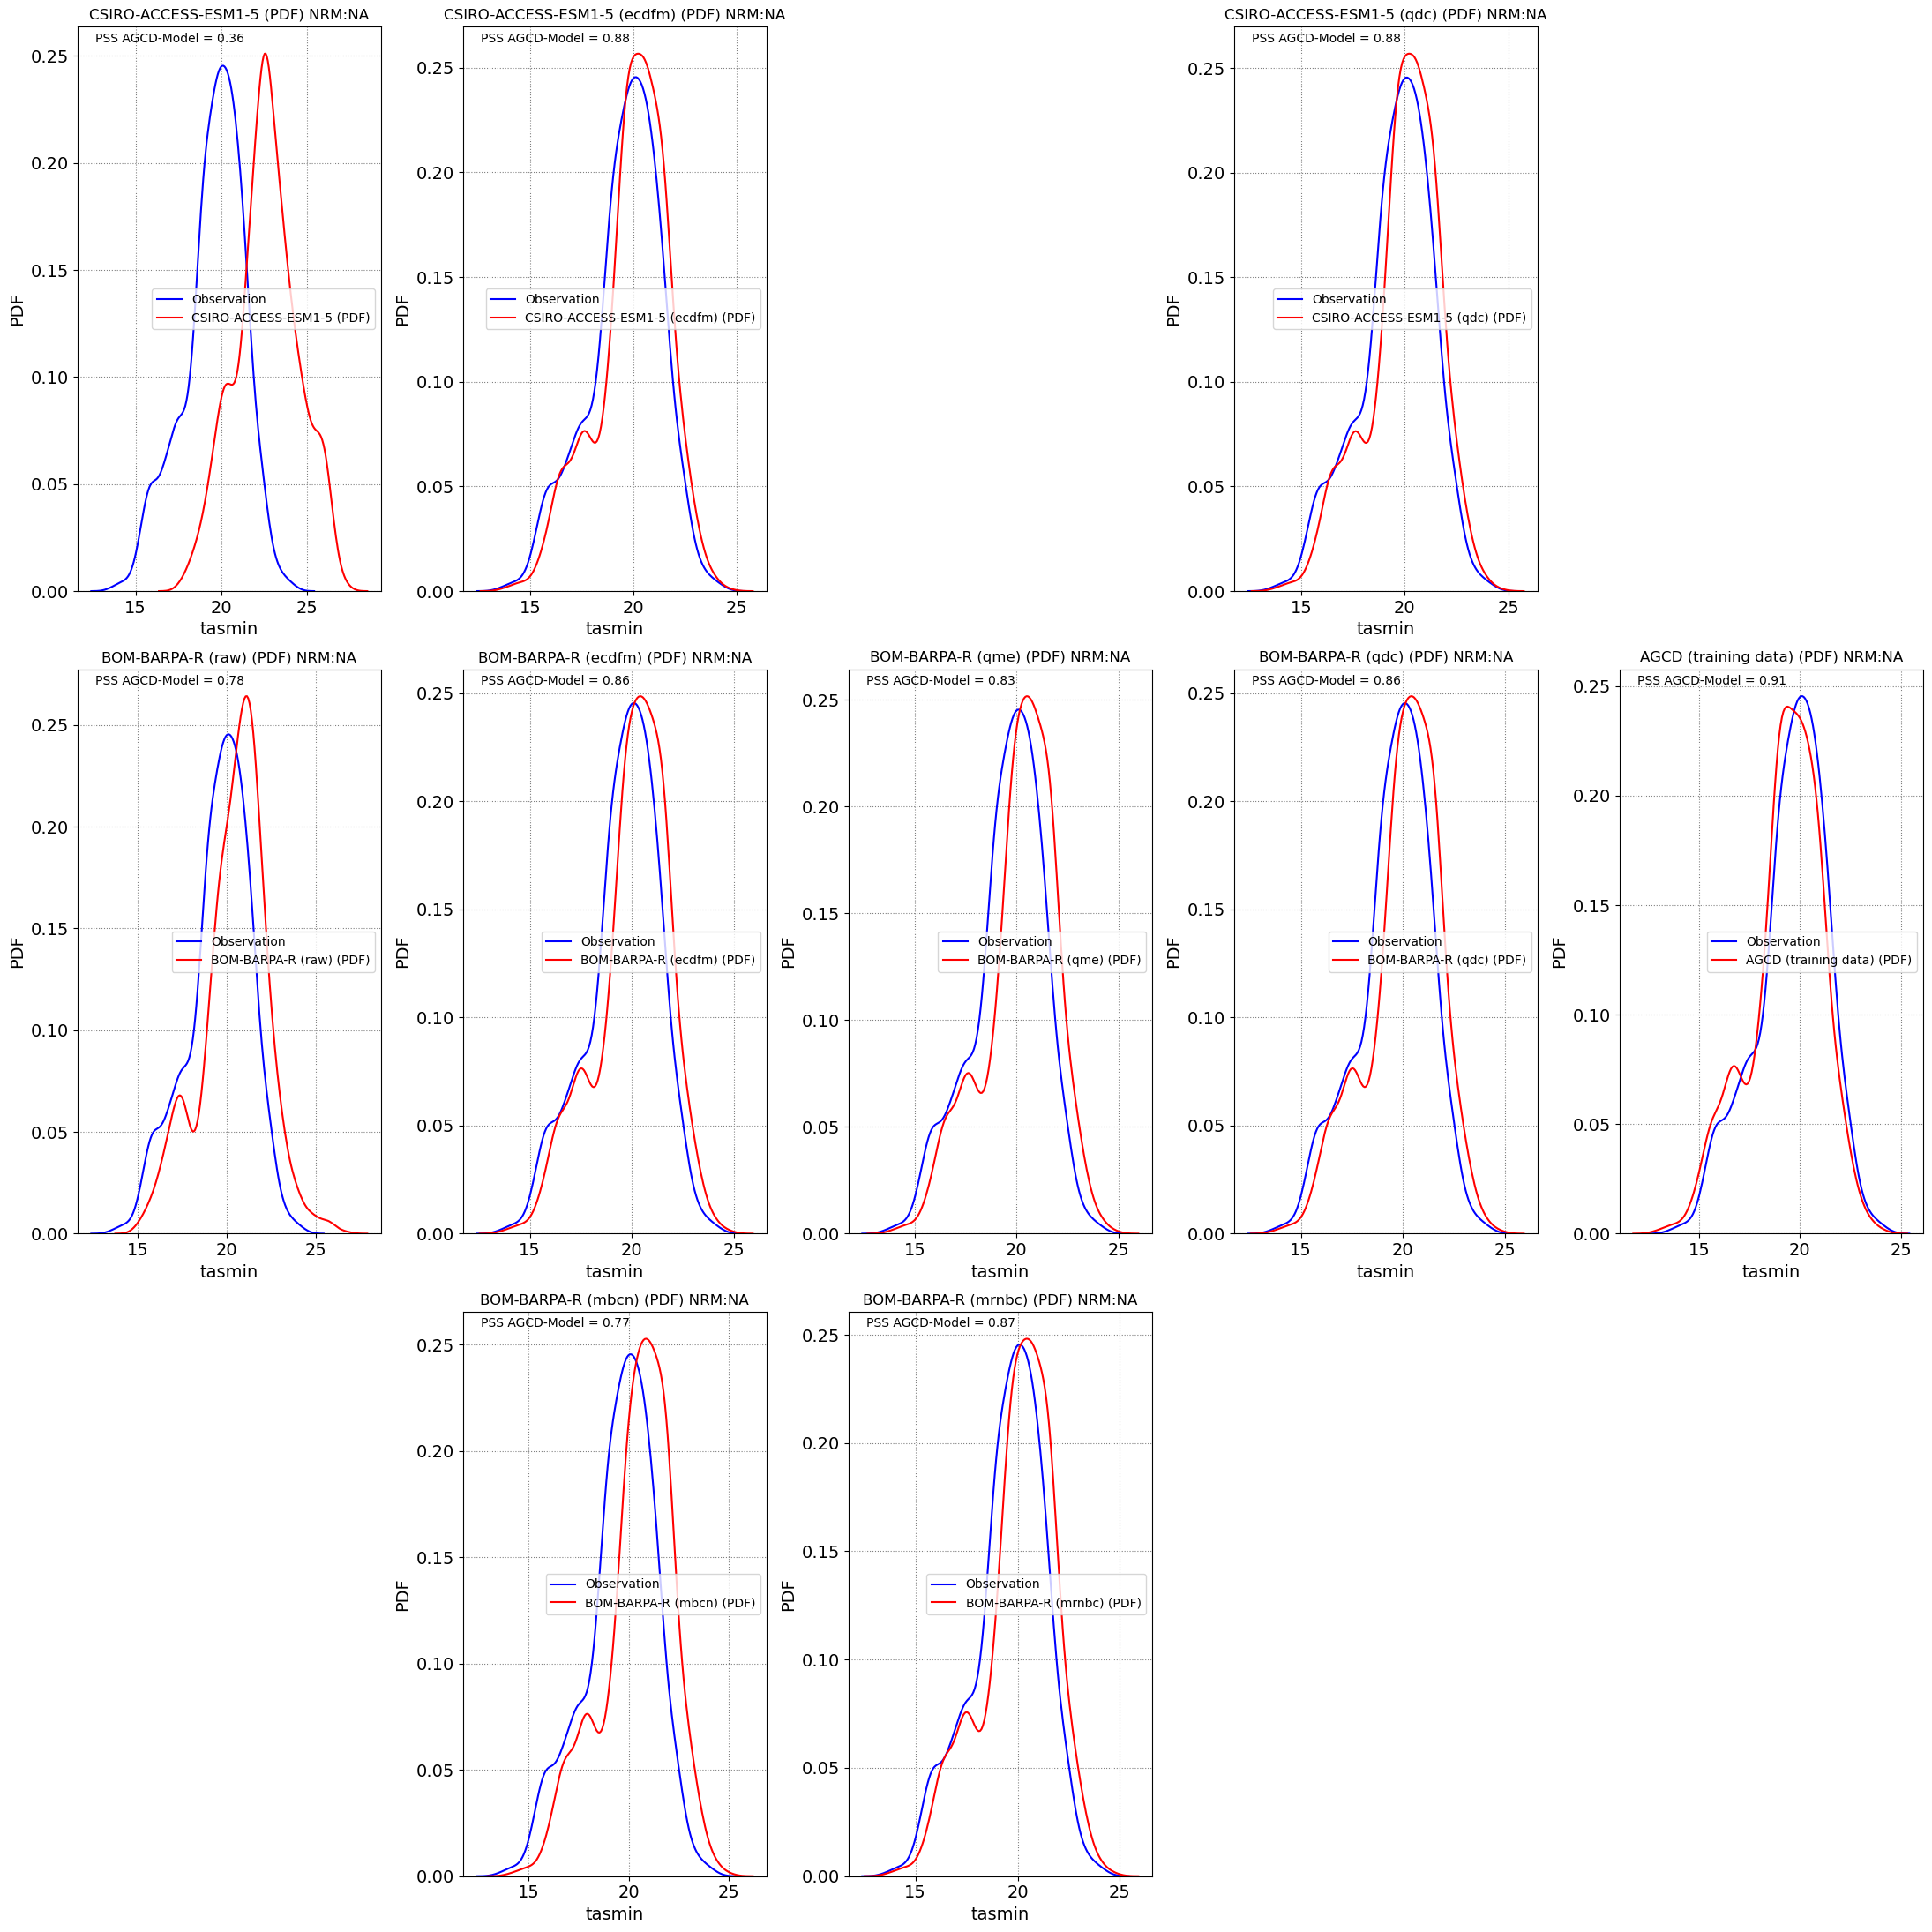

In [19]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=True)

tasmin_extreme-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_CSIRO-CCAM-2203_NA.png


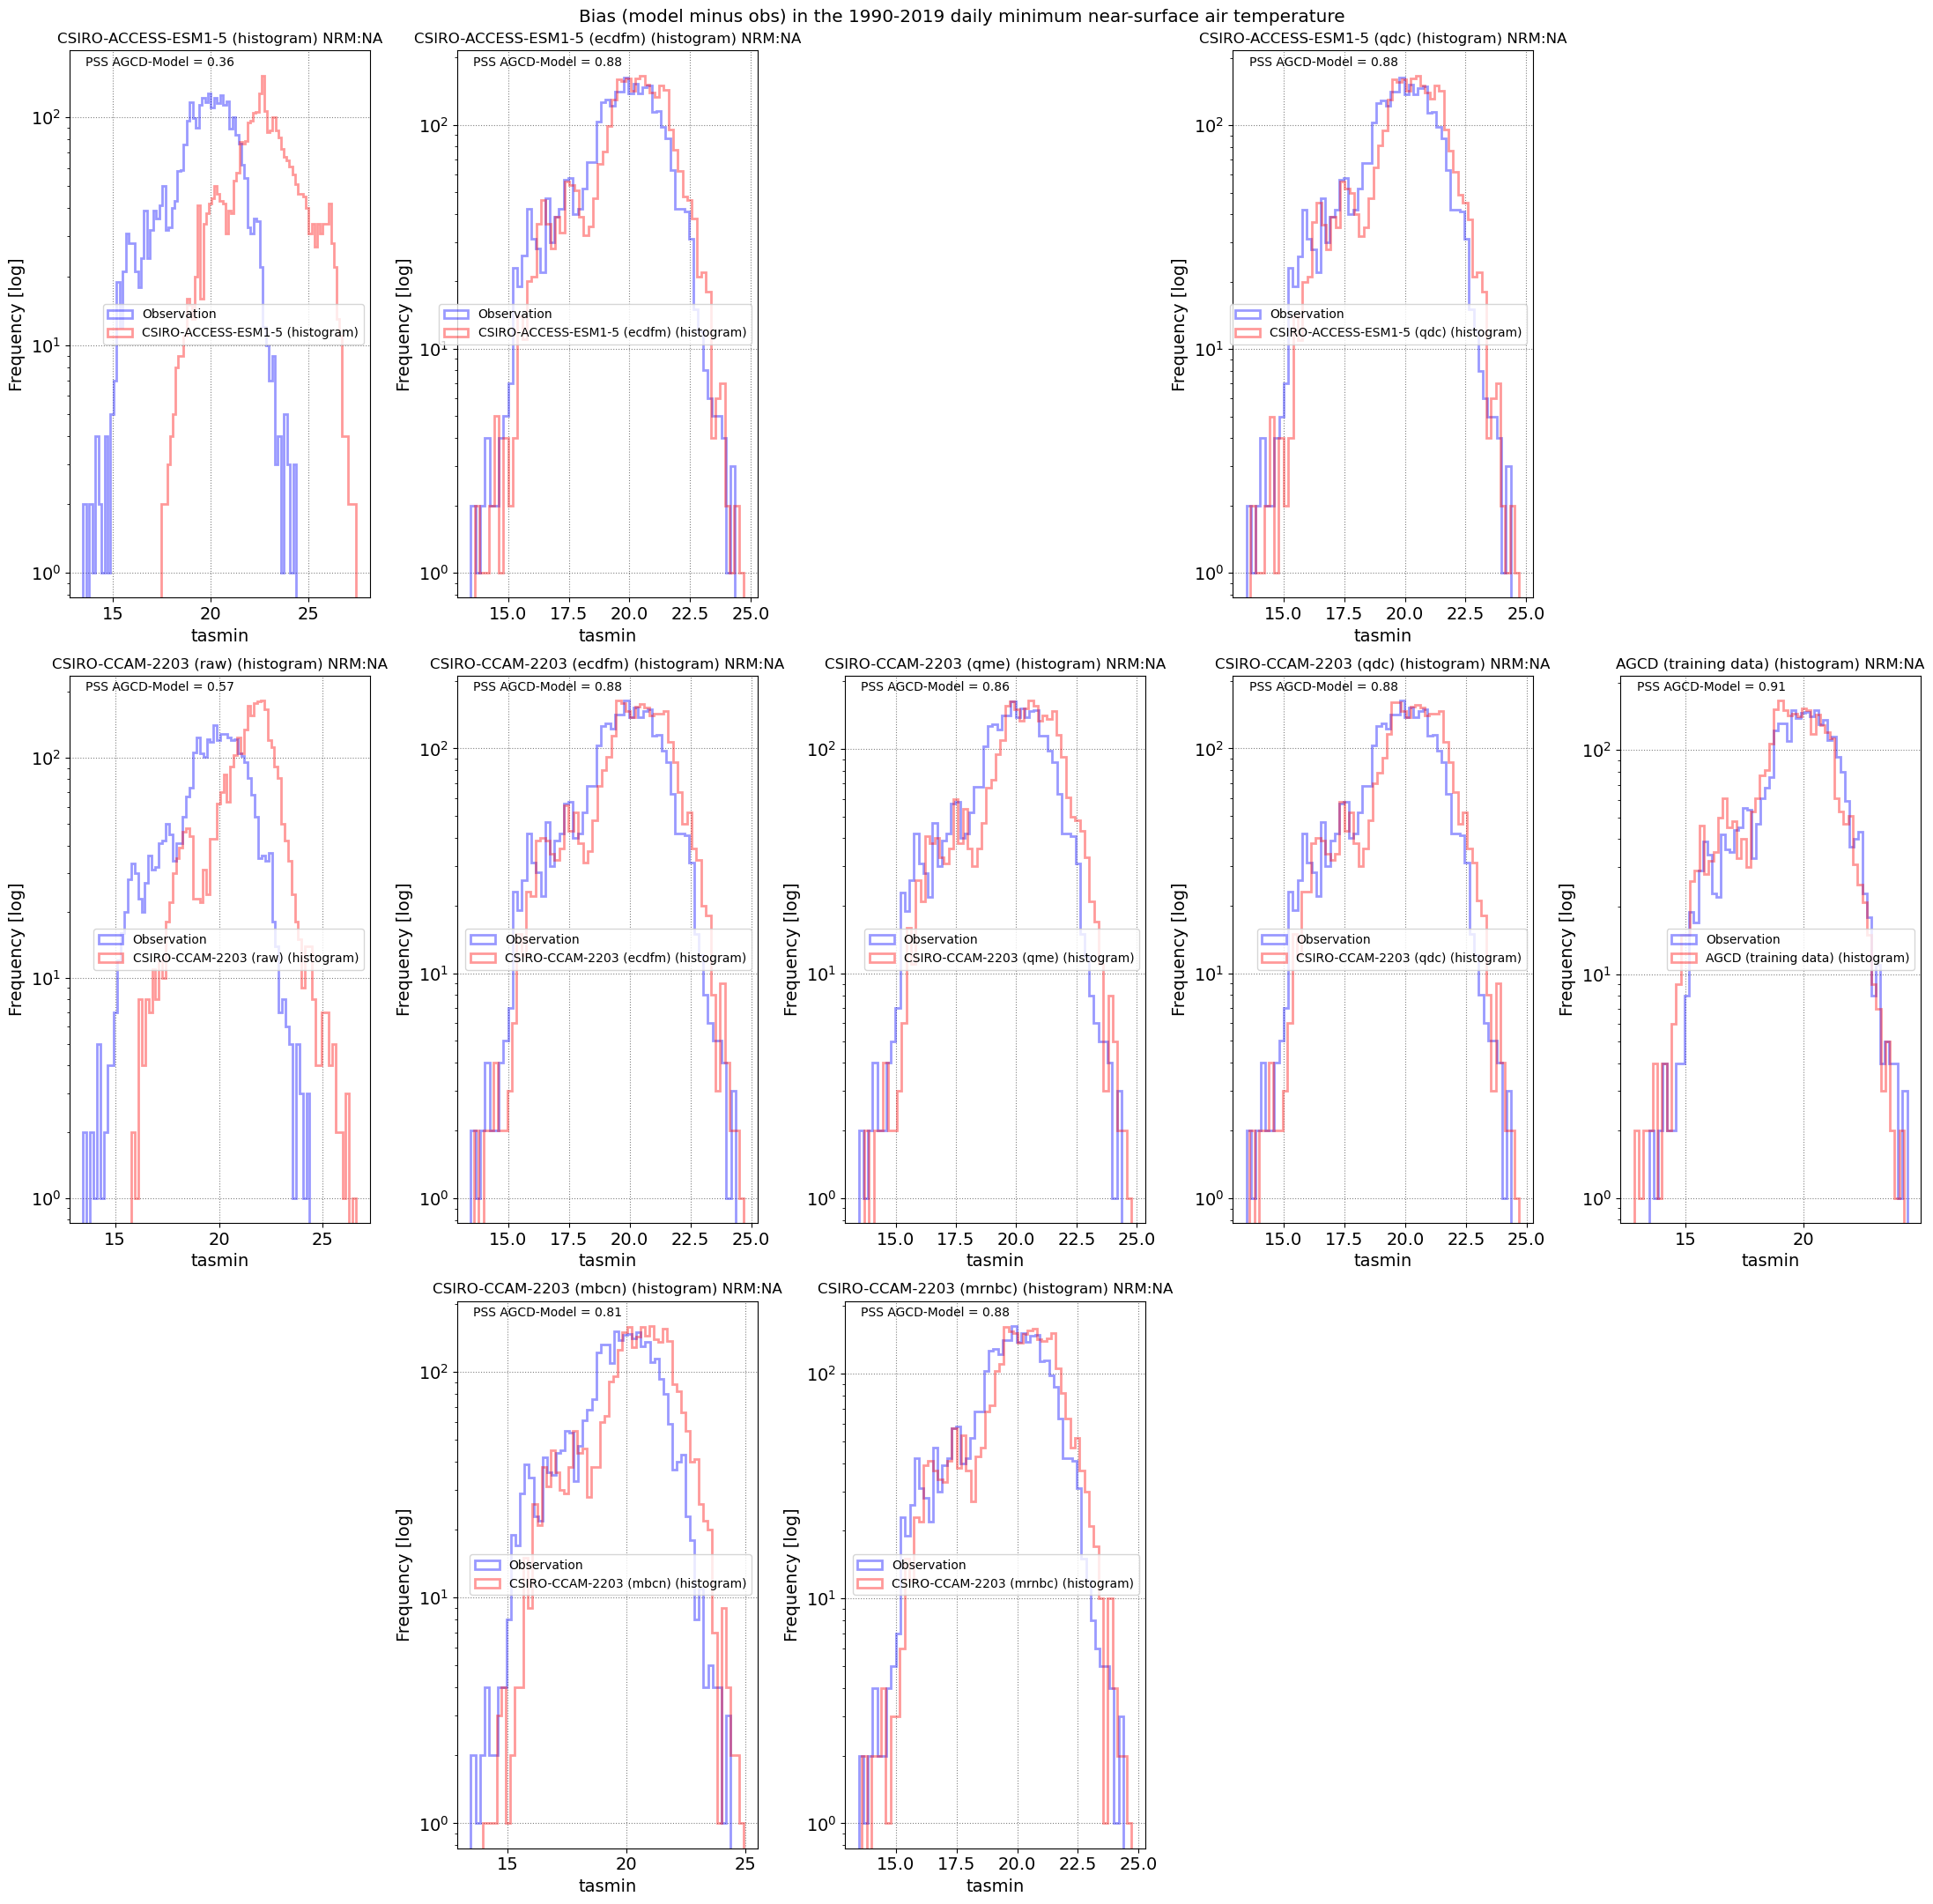

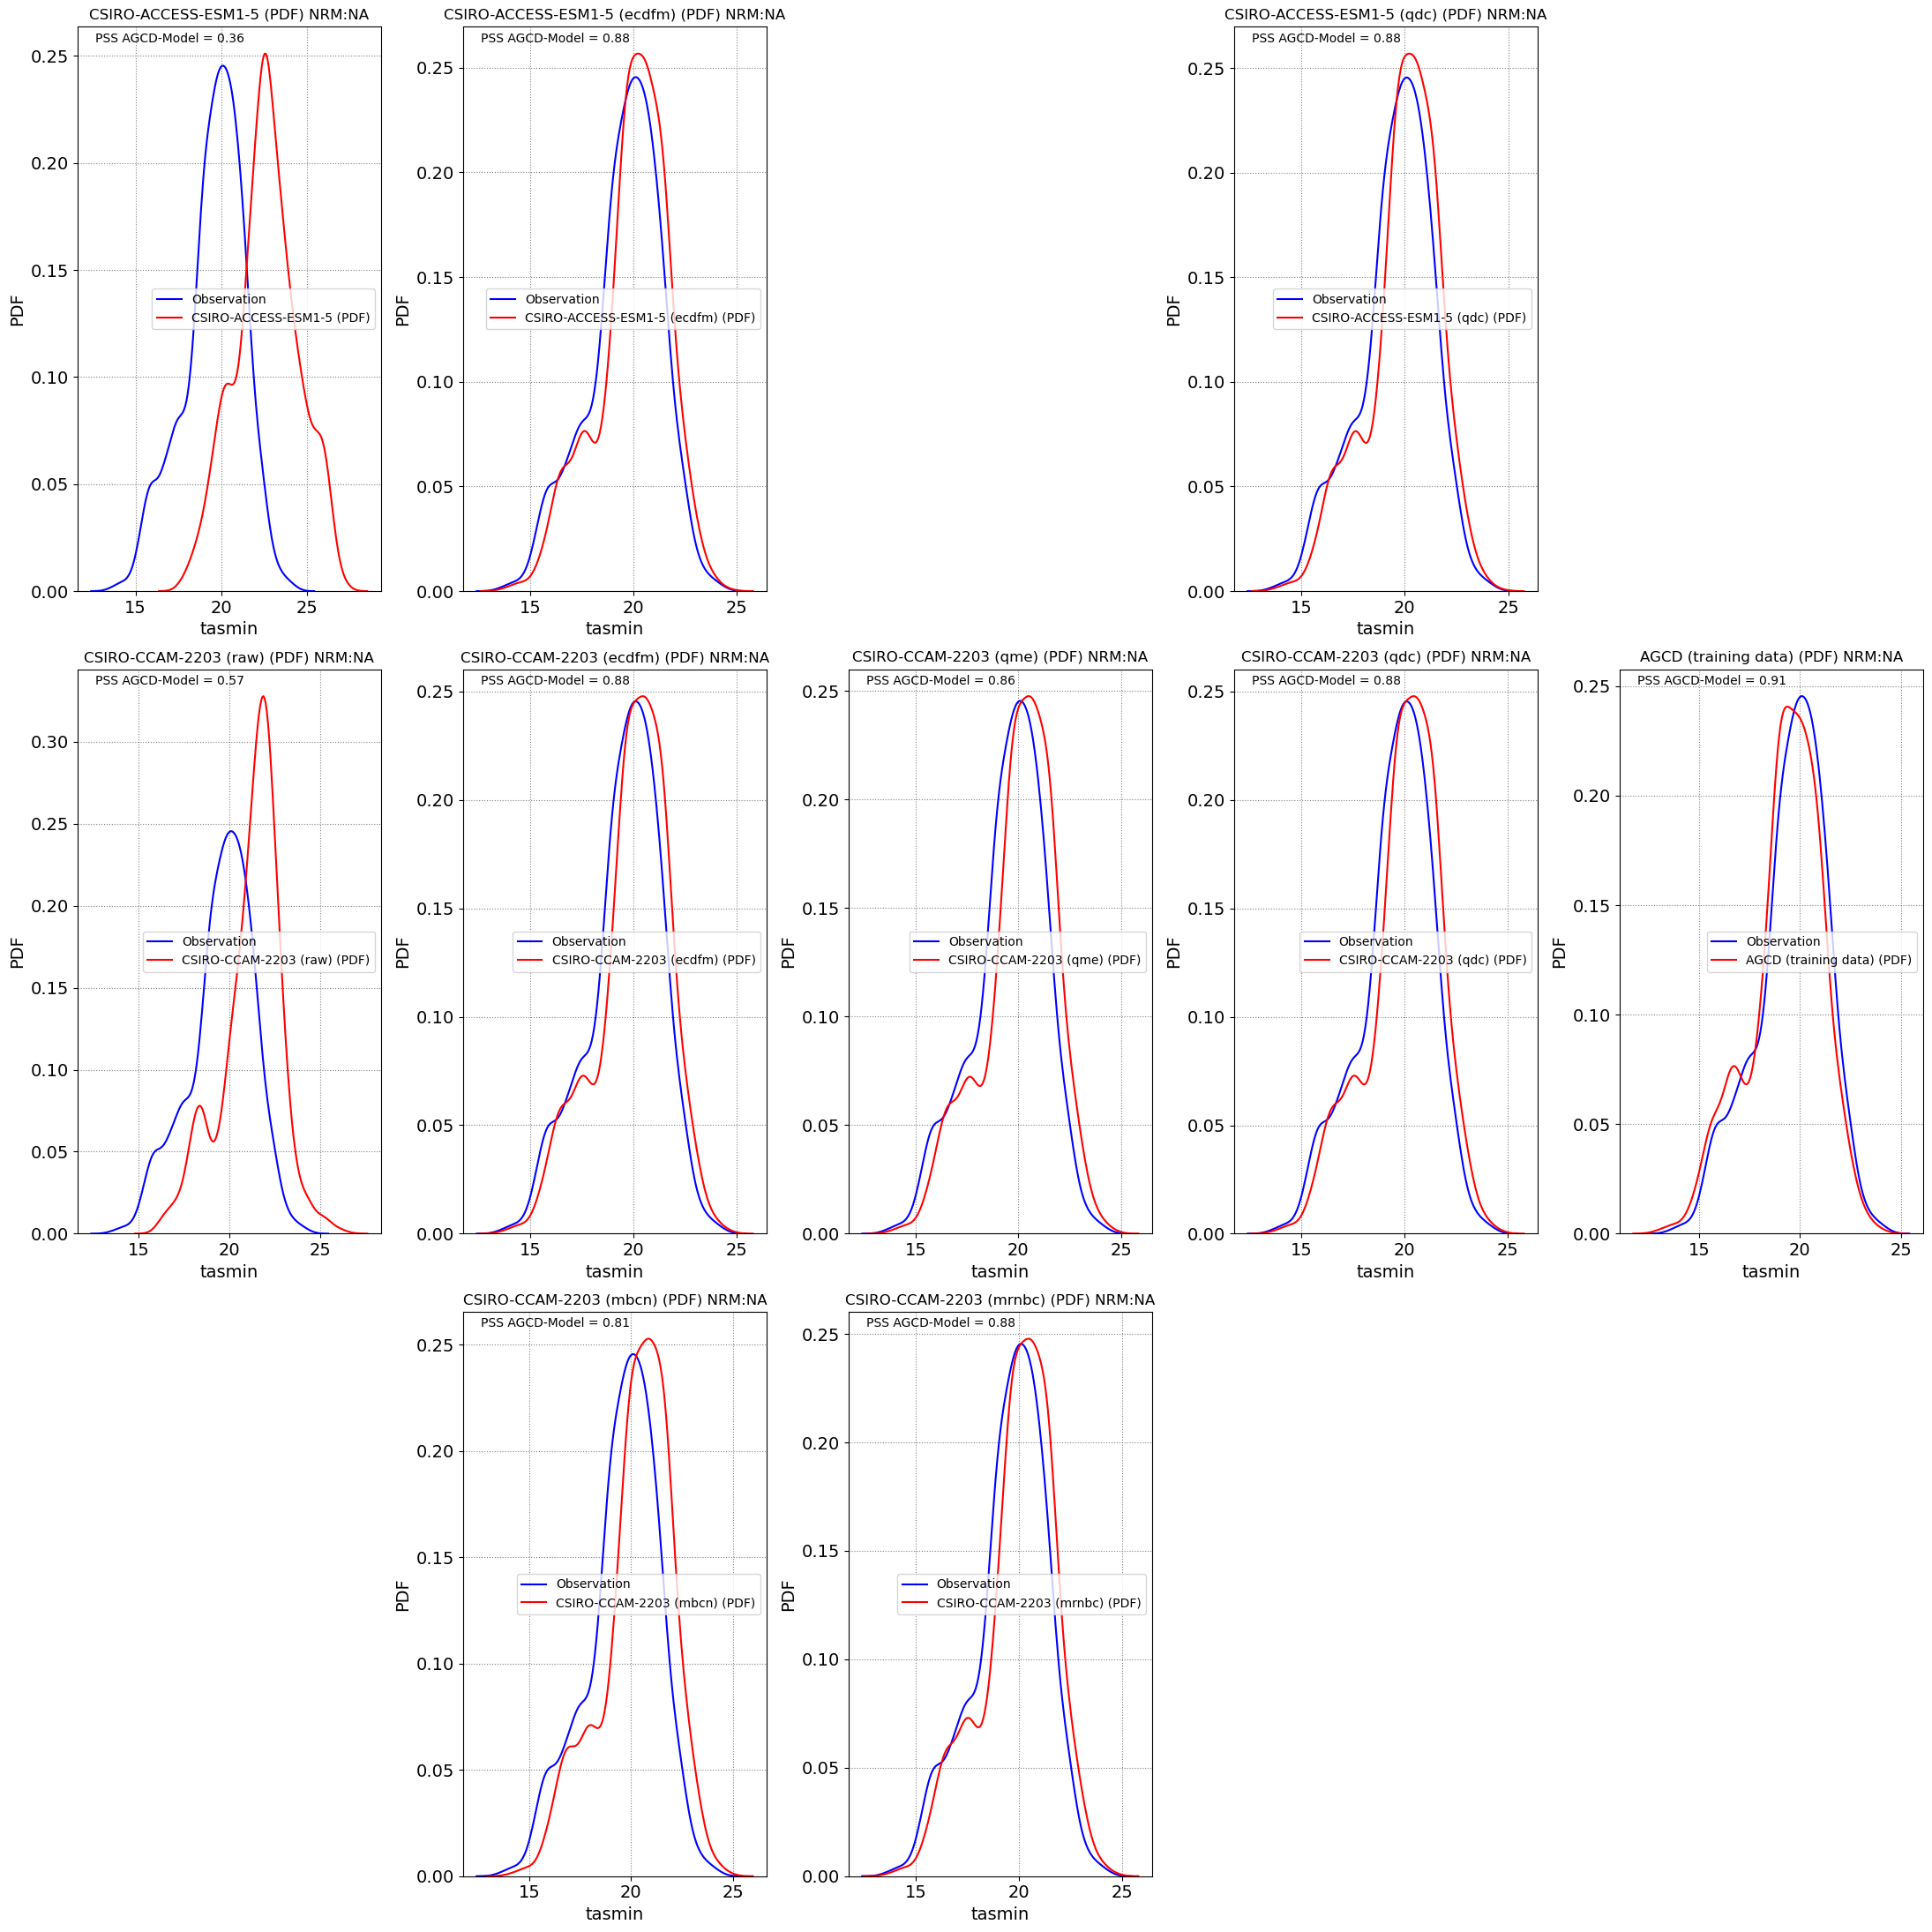

In [20]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=True)

tasmin_extreme-bias_task-xvalidation_CSIRO-ACCESS-ESM1-5_UQ-DES-CCAM-2105_NA.png


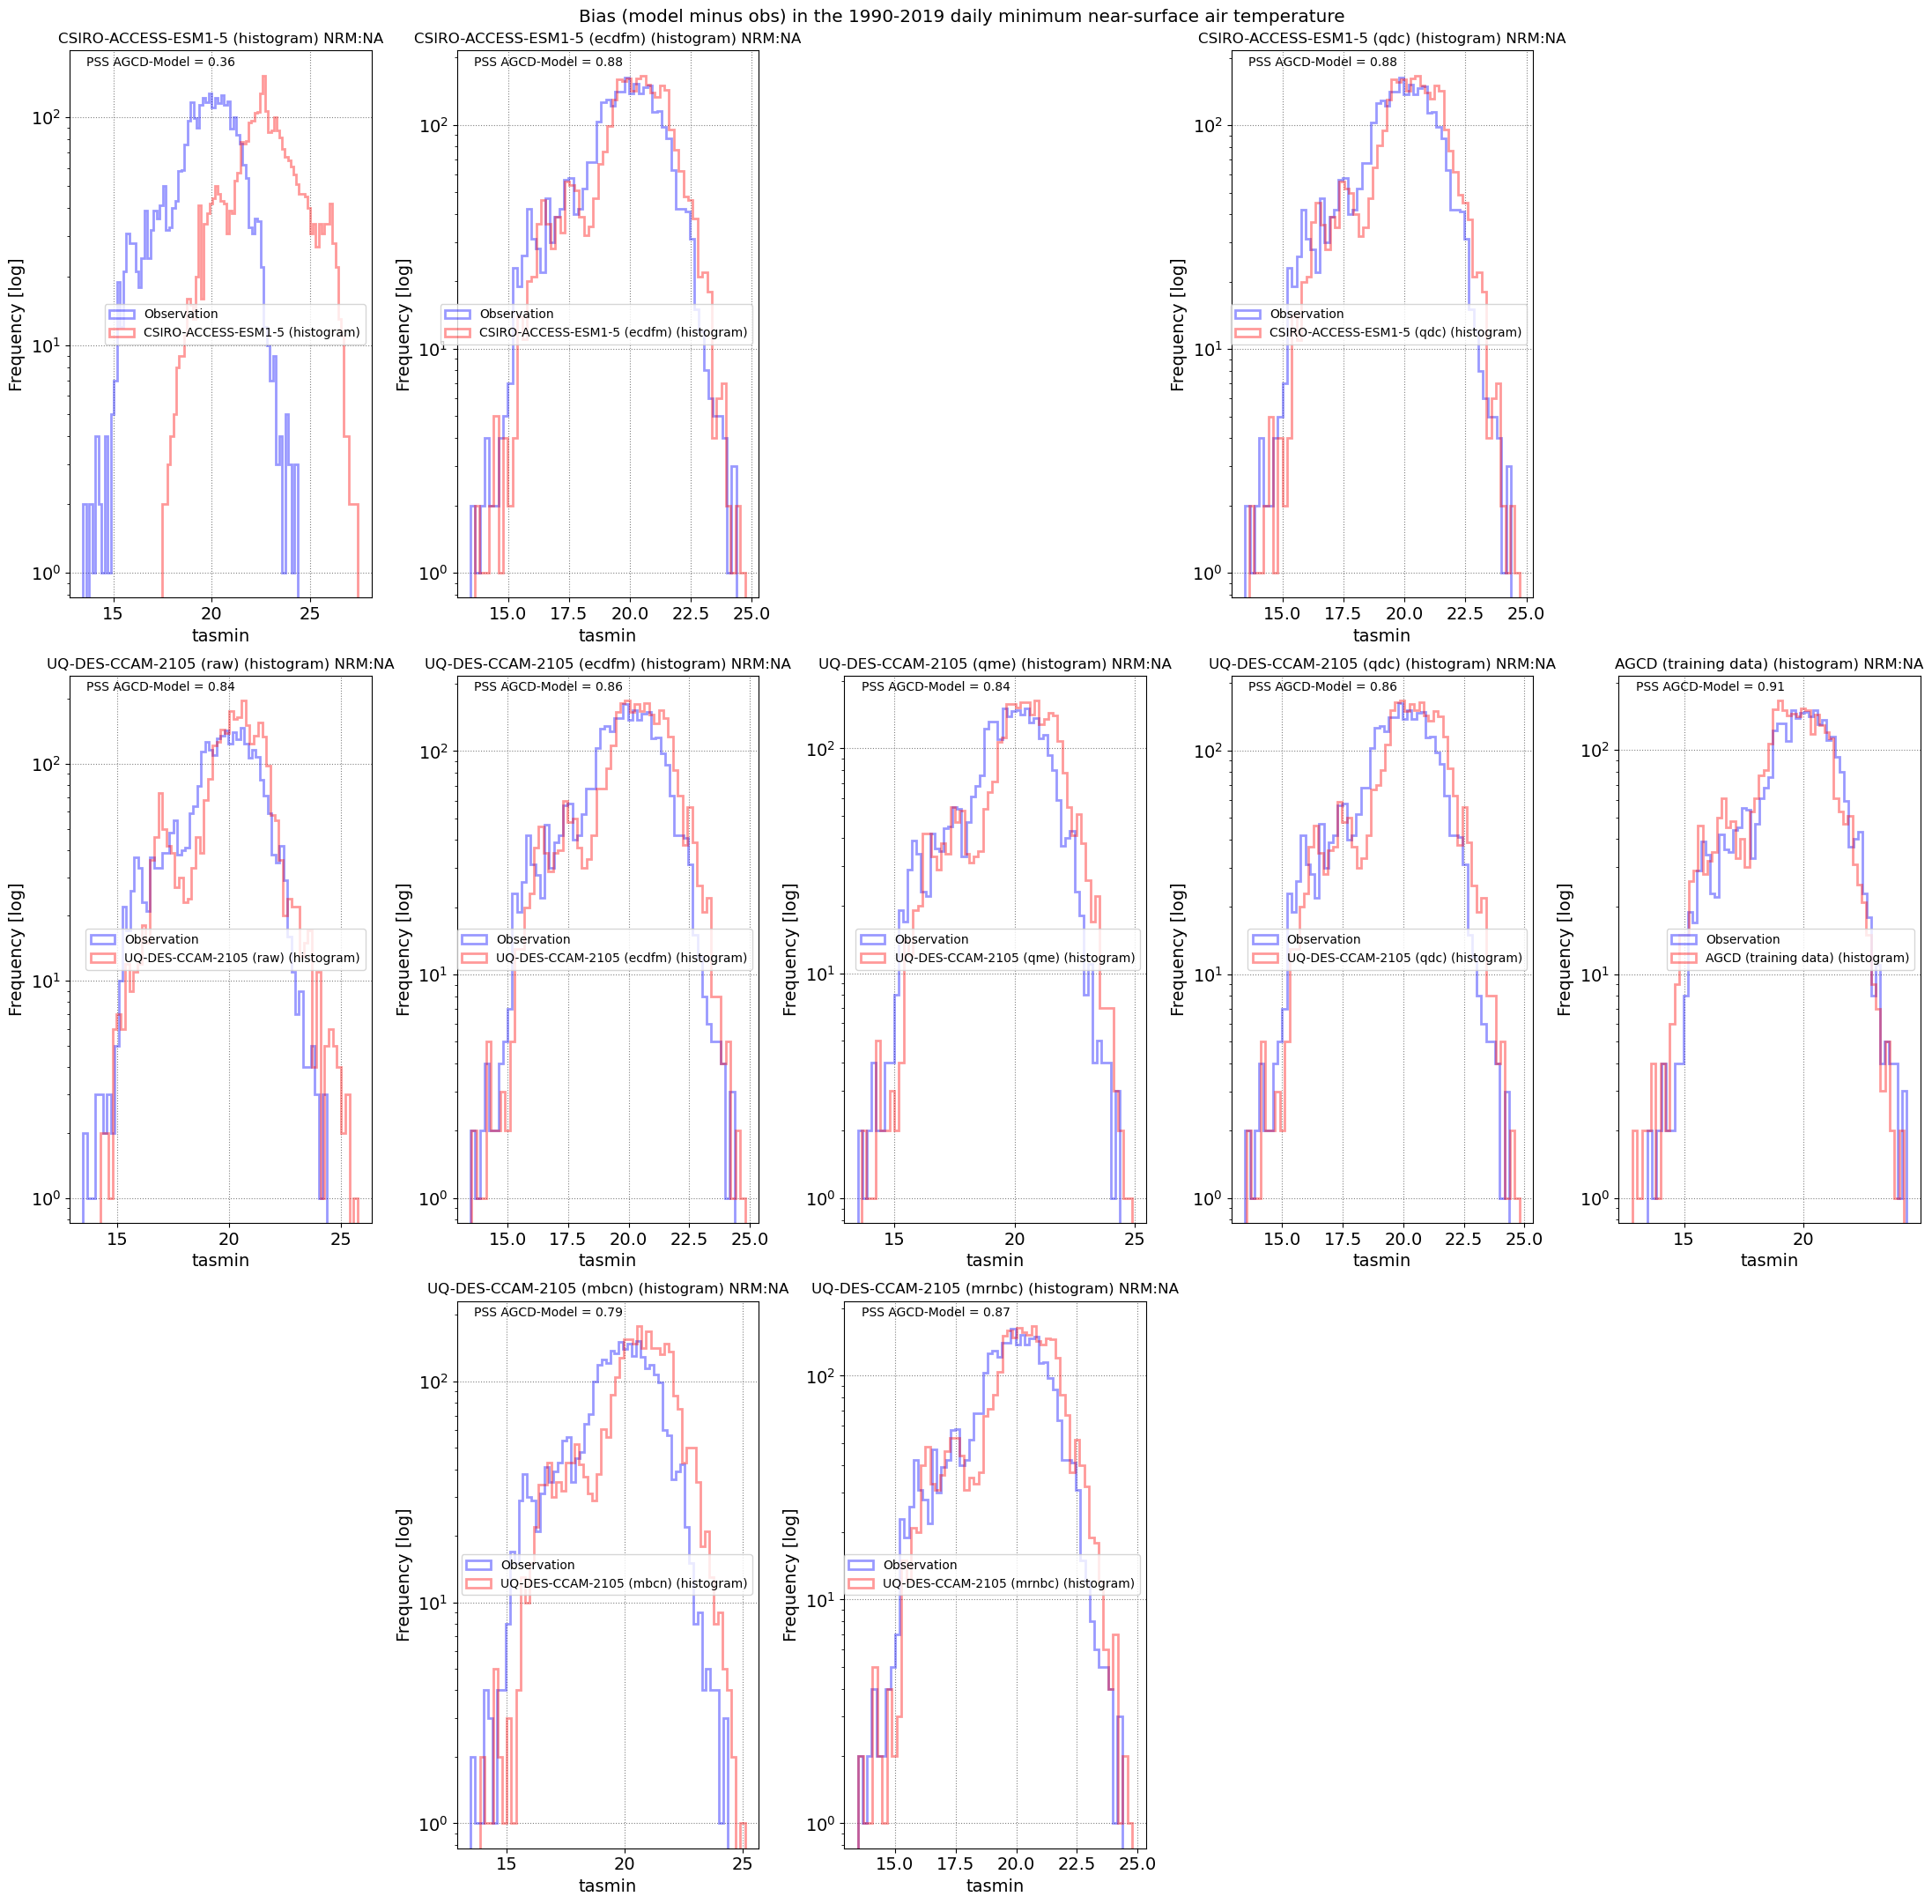

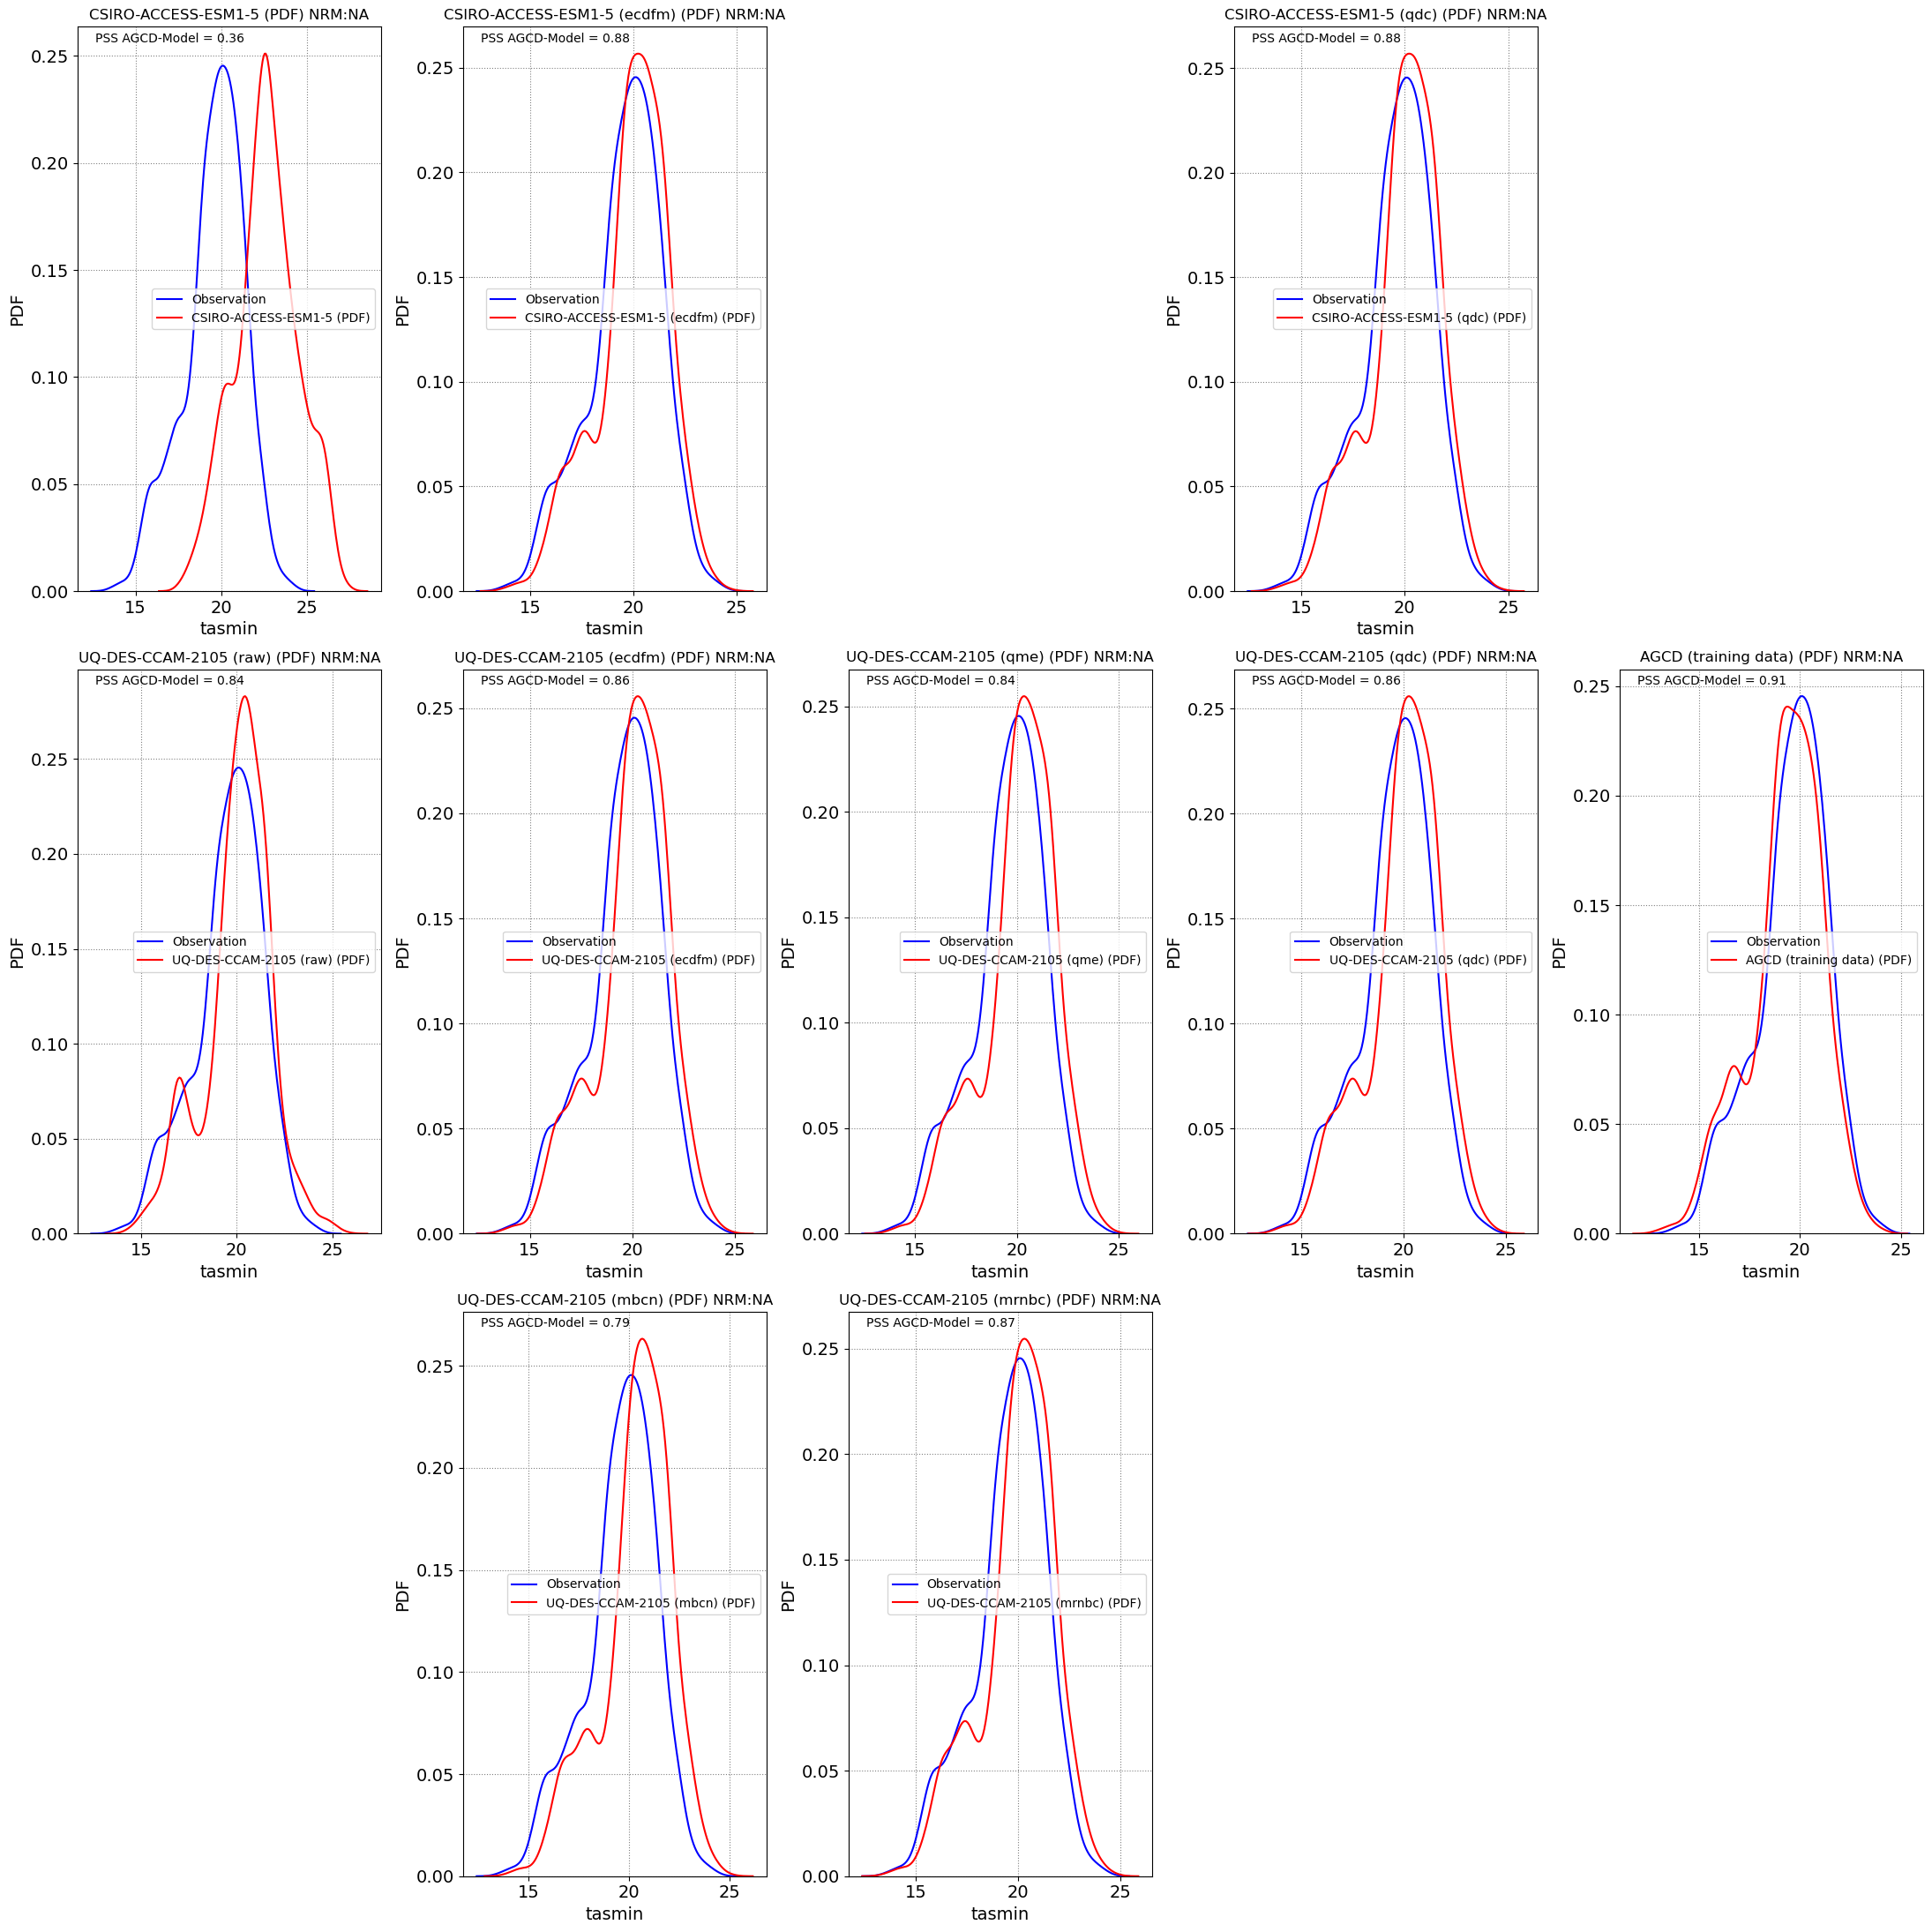

In [21]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, save_outfile=True)

#### CESM2

In [22]:
gcm = 'NCAR-CESM2'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

In [ ]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

In [ ]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

#### EC-Earth3

In [ ]:
gcm = 'EC-Earth-Consortium-EC-Earth3'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

In [ ]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)

In [ ]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs)